In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json 
import math
import numpy as np
import matplotlib as mpl
import networkx as nx
import matplotlib.pyplot as plt
# Import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr
mpl.rcParams.update(mpl.rcParamsDefault)
#import itertools
from utils.bag_of_words.skill_dataset import create_plot_bog_skills

from utils.bag_of_words.bipartite_multipartite_projection import create_plot_bog_modules,spectral_sparsification,get_projection
from utils.bag_of_words.network_property import get_network_property
import random
import torch

def set_random_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
def l_0_norm(vector):
    count = 0
    total = 0
    for element in vector:
        for sub_element in element:
            if sub_element != 0:
                count += 1
    return count
def take_average(dict):
    data = dict["0"]
    iterations_block = list(["0","1","2","3","4"])
    iterations_channel = list(["0","1","2","3","4"])
    #for style , iterations in zip (["block","channel","block_random","channel_random"],[iterations_block,iterations_channel,iterations_block,iterations_channel]):
    for style , iterations in zip (["block","channel"],[iterations_block,iterations_channel,iterations_block,iterations_channel]):
        for iter in iterations:
            if iter == "0":
                continue
            for ratio in dict[iter][style]:
                for dataset in dict[iter][style][ratio]:
                    for norm in dict[iter][style][ratio][dataset]:
                        value = np.array(dict[iter][style][ratio][dataset][norm])
                        if len( value.shape) != 1:
                            shape_model = value.shape
                        data[style][ratio][dataset][norm]= (np.array(data[style][ratio][dataset][norm])+value)
                        if iter == iterations[-1]:
                            data[style][ratio][dataset][norm] = data[style][ratio][dataset][norm]/len(iterations)
    return data, shape_model

def strip(name):
    name = name.split("/")[-1]
    name = name.split("_")[0]
    return name 

with open("result/distribution_llama_7b.json", 'r') as openfile:
    # Reading from json file
    llama_distribution = json.load(openfile)
with open("result/distribution_vicuna_7b.json", 'r') as openfile:
    # Reading from json file
    vicuna_distribution = json.load(openfile)
with open("result/distribution_llama_7b-chat.json", 'r') as openfile:
    # Reading from json file
    llama_chat_distribution= json.load(openfile)
def loop_over(dict):
    if isinstance(dict, list):
        print("end")
    else: 
        print(dict.keys())
        for keys in dict:
            loop_over(dict[keys])
def get_dataset_list(dataset_list):
    dataname = []
    for data in dataset_list:
        if "subset" not in dataset_list[data].keys():
            dataname.append(data)
        else:
            for subset in dataset_list[data]["subset"]:
                dataname.append(subset)
    return dataname
    #Dataset List
with open("/home/bhandk/MLNeuron/dataset_info.json", 'r') as openfile:
        # Reading from json file
        dataset_list = json.load(openfile)
#Original Distribution
with open("result/original_distribution_vicuna_7b.json", 'r') as openfile:
    vicuna_original = json.load(openfile)
with open("result/original_distribution_llama_7b.json", 'r') as openfile:
    # Reading from json file
    llama_original = json.load(openfile)
with open("result/original_distribution_llama_7b-chat.json", 'r') as openfile:
    # Reading from json file
    llama_chat_original = json.load(openfile)
#Pruned Distribution
with open("result/distribution_llama_7b.json", 'r') as openfile:
    # Reading from json file
    llama_distribution = json.load(openfile)
with open("result/distribution_vicuna_7b.json", 'r') as openfile:
    # Reading from json file
    vicuna_distribution = json.load(openfile)
with open("result/distribution_llama_7b-chat.json", 'r') as openfile:
    # Reading from json file
    llama_chat_distribution= json.load(openfile)
with open("result/dataNeuropsychologicalDomainsCluster.json", 'r') as openfile:
    # Reading from json file
    dataset_community= json.load(openfile)

dataset_list = get_dataset_list(dataset_list)
llama_distribution, model_shape = take_average(llama_distribution)
vicuna_distribution, model_shape = take_average(vicuna_distribution)
llama_chat_distribution, model_shape = take_average(llama_chat_distribution)

with open("result/dataNeuropsychologicalDomainsCluster.json", 'r') as openfile:
    # Reading from json file
    dataset_community= json.load(openfile)
with open("result/dataMultidisciplinaryCognitiveSkillsFrameworkRestrict.json", 'r') as openfile:
    #with open("result/dataCategory.json", 'r') as openfile:
    # Reading from json file
    dataCategory = json.load(openfile)
cognitive_skills_community = {
                    "cognitive_process_memory":[ 
                        "sustained_attention", "selective_attention", "divided_attention", "vigilance_attention","attention_shifting",
                        "processing_speed", "visual_processing_speed", "auditory_processing_speed",
                        "prospective_memory", "working_memory", "episodic_memory", "semantic_memory", "procedural_memory", "iconic_memory", "echoic_memory", "spatial_memory"],
                    "executive_function":[ 
                        "planning", "organization", "goal_setting","time_management", 
                        "problem_solving", "mental_flexibility", "strategic_thinking","adaptability",
                        "impulse_control", "decision_making","emotional_regulation","risk_assessment",
                        "abstract_thinking", "reasoning", "cognitive_flexibility", "creativity"], #concept_formation
                    "language_communication":[
                         "expressive_language", "receptive_language", "naming", "fluency", "comprehension", "repetition", "reading", "writing", 
                         "pragmatics", "discourse_ability", "linguistic_analysis", "narrative_skills"],
                    "social_cognition":
                        ["recognition_of_social_cues", "theory_of_mind", "empathy", "social_judgment","intercultural_competence","conflict_resolution","self_awareness","relationship_management"]
}
all_skill_label = []
for func, skill_list in cognitive_skills_community.items():
    all_skill_label += skill_list

In [2]:

def min_max(X):
    max, mean,  min = X.max(),X.mean(),X.min() 
    X_std = (X - mean) / (max - min)
    X_scaled = X_std * (max - min) + min
    return X_scaled
def get_community_for_alpha(dataCategory, dataset_list, distribution, original, pruner_style="block", sparsity_ratio="15",alpha1=None, alpha2=None, random_seed=True, modules_vs_modules=True):
    AB_dataset_skill, skill_label = create_plot_bog_skills(dataCategory, dataset_list, plot=False)
    BC_dataset_modules, module_label = create_plot_bog_modules(distribution,original, dataset_list,pruner_style=pruner_style, pruner_ratio=sparsity_ratio,norm="|W|_0",plot=False, alpha=alpha1)
    A_skill_modules =  np.dot(AB_dataset_skill.T,BC_dataset_modules)
    sparse_network = spectral_sparsification(A_skill_modules, alpha2)
    sparse_network =  sparse_network #min_max(sparse_network)
    if modules_vs_modules:
        _ ,A_modules_modules  = get_projection(sparse_network, plot_projection= False)
        G, network_property = get_network_property(A_modules_modules,module_label,module_label )
    else:
        A_skills_skills , _ = get_projection(sparse_network, plot_projection= False)
        G, network_property = get_network_property(A_skills_skills,skill_label,skill_label )
    return G, network_property, (sparse_network,skill_label,module_label), (AB_dataset_skill, BC_dataset_modules, A_skill_modules)
def collect_edge_weights(G, communities_dict):
    community_weights = {"community":[],"node":[],"neighbor":[],"weight":[]}
    community_node_weighted_sum = {"community":[],"node":[],"weight":[],"degree":[]} 
    for community, nodes in communities_dict.items():
        #if len(nodes) < 10:
        #    continue
        subGraph = nx.subgraph(G,nodes)
        for node in nodes:
            sum = []
            for neighbor in subGraph.neighbors(node):
                if subGraph.has_edge(node, neighbor):
                    community_weights["community"].append(community)
                    community_weights["node"].append(node)
                    community_weights["neighbor"].append(neighbor)
                    community_weights["weight"].append(subGraph[node][neighbor].get('weight', 1))
                    sum.append(community_weights["weight"][-1])
            community_node_weighted_sum["community"].append(community)
            community_node_weighted_sum["node"].append(node)
            community_node_weighted_sum["weight"].append(np.sum(sum))
            community_node_weighted_sum["degree"].append(len(sum))
    return pd.DataFrame.from_dict(community_weights),pd.DataFrame.from_dict(community_node_weighted_sum)
def within_module_z_score(G, communities):
    z_scores = {"node":[],"community":[],"z_scores":[]}
    for comm_id, nodes in communities.items():
        degrees = np.array([G.degree(node) for node in nodes])
        mean_degree = np.mean(degrees)
        std_degree = np.std(degrees) if len(degrees) > 1 else 1.0
        for node in nodes:
            z_scores["node"].append(node)
            z_scores["community"].append(comm_id)
            z_scores["z_scores"].append((G.degree(node) - mean_degree) / std_degree)
    return pd.DataFrame.from_dict(z_scores) 

def participation_coefficient(G, partition):
    part_coeff = {"node":[],"community":[],"part_coeff":[]}
    total_degree = dict(G.degree())
    
    for node in G.nodes():
        community_id = partition[node]
        degree = total_degree[node]
        comm_degrees = sum([G.degree(neigh) for neigh in G.neighbors(node) if partition[neigh] == community_id])
        
        if degree > 0:
            score = 1 - (comm_degrees / degree) ** 2
        else:
            score = 0
        part_coeff["node"].append(node)
        part_coeff["community"].append(community_id)
        part_coeff["part_coeff"].append(score)

    return  pd.DataFrame.from_dict(part_coeff) 
def compute_correlation_community(df, model, pruning_strategy):
    grouped = df.groupby('community')

    # Store the correlation results
    results = []

    # Iterate over each community group
    for community, group in grouped:
        z_scores = group['z_scores']
        part_coeff = group['part_coeff']
        
        # Calculate Pearson and Spearman correlation
        pearson_corr, _ = pearsonr(z_scores, part_coeff)
        spearman_corr, _ = spearmanr(z_scores, part_coeff)
        
        # Append results to a list
        results.append({
            'community': community,
            'pearson_correlation': pearson_corr,
            'spearman_correlation': spearman_corr,
            'model':model,
            'pruning_strategy':pruning_strategy 
        })
    return pd.DataFrame(results)

distribution_dist = [llama_distribution,llama_chat_distribution,vicuna_distribution]
original_dist = [llama_original,llama_chat_original,vicuna_original]

In [3]:
def node_data(nodes_skills, nodes_dataset, nodes_modules, name):
    results = []
    if nodes_dataset != None: 
        node_shape,node_label, node_data = [2,3,4],["modules","dataset","skill"],[nodes_modules,nodes_dataset,nodes_skills] 
    else:
        node_shape,node_label, node_data = [2,4],["modules","skill"],[nodes_modules,nodes_skills] 
    for id, (shape, node_type, node_list) in enumerate(zip(node_shape, node_label, node_data)):
        for node in node_list:
            if node_type == "skill":
                label = node
            elif node_type == "modules" and nodes_dataset == None:
                label = node
            else:  
                label = None
            results.append({"Id":node,"type":node_type,"size":id+2,"[z]":shape-1,"Label":label})
    node_data =pd.DataFrame(results)
    node_data.to_csv(f"./graph/{name}",index=False)
def network_data(adjacency_matrix_AB, nodes_A, nodes_B,edge_type, name):
    min_val = np.min(adjacency_matrix_AB)
    max_val = np.max(adjacency_matrix_AB)

    normalized_matrix = (adjacency_matrix_AB - min_val) / (max_val - min_val)
    assert adjacency_matrix_AB.shape[0] == len(nodes_A)
    assert adjacency_matrix_AB.shape[1] == len(nodes_B)
    
    if "_datasets_skills" in name:
        normalized_matrix[normalized_matrix <= 0.3] = 0
    elif "_skill_modules" in name:
        normalized_matrix = spectral_sparsification(normalized_matrix, 0.5)
    else:
        normalized_matrix = spectral_sparsification(normalized_matrix, 0.05)
    results = []
    for node_i in range(adjacency_matrix_AB.shape[0]):
        for node_j in range(adjacency_matrix_AB.shape[1]):
            if normalized_matrix[node_i,node_j] == 0:
                continue 
            #results.append({"Source":nodes_A[node_i], "Target":nodes_B[node_j],"Weight":normalized_matrix[node_i,node_j],"Edge_Type":edge_type})
            results.append({"Source":nodes_A[node_i], "Target":nodes_B[node_j],"Edge_Type":edge_type})
    edge_data =pd.DataFrame(results)
    edge_data.to_csv(f"./graph/{name}",index=False)

In [4]:
from utils.bag_of_words.projection_community import create_projection_network,all_skill_label
sparsity_ratio = "20"
set_random_seed(int(2))
modules_community_dataset = create_projection_network(dataCategory,dataset_list, distribution_dist, original_dist, sparsity_ratio = sparsity_ratio,get_graph=True)

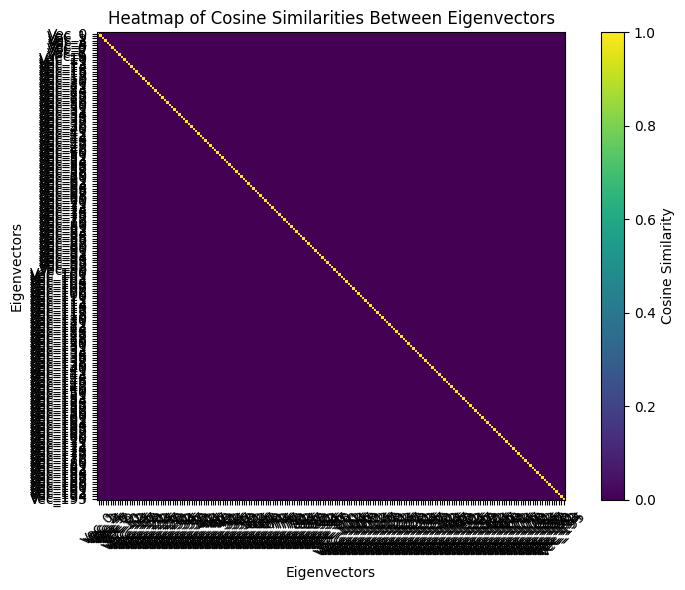

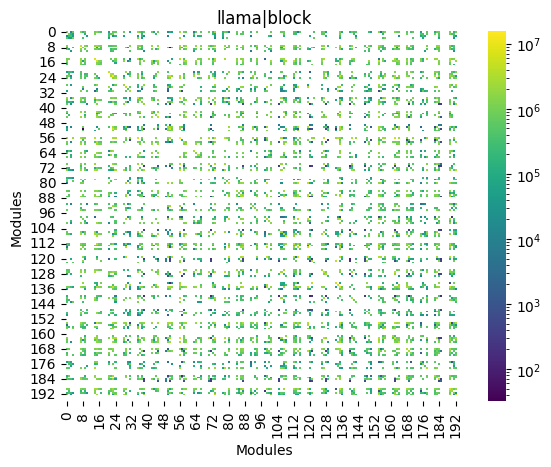

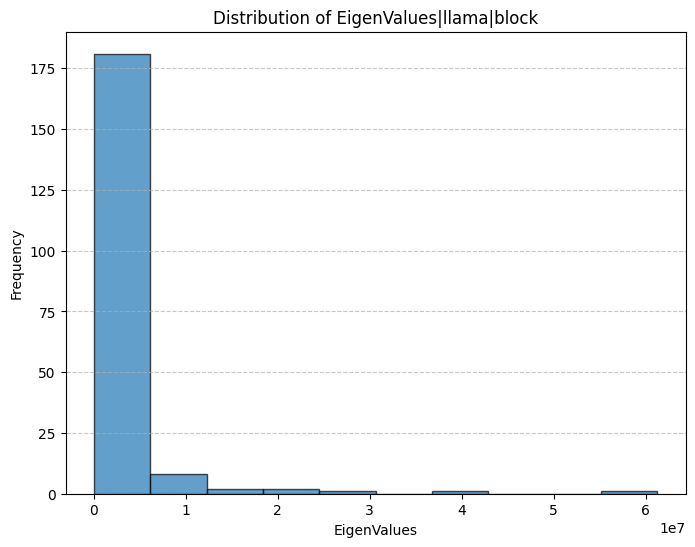

llama block
-7.852258906548962e-09
-6.5938628260225e-09
-5.004843784780255e-09
-4.460396381392239e-09
-4.311685109924251e-09
-4.029952001749843e-09
-3.584334252130413e-09
-3.290002315500299e-09
-2.7373925656179787e-09
-2.641142093308061e-09
-2.4479091552403015e-09
-2.255511063803264e-09
-2.1025454467839877e-09
-2.0379149388017947e-09
-1.892219730420018e-09
-1.6187841389731249e-09
-1.293095155536219e-09
-1.1579488331966203e-09
-1.0590135893568215e-09
-9.9448404394992e-10
-9.651328956204346e-10
-7.477890372280814e-10
-7.421024539651295e-10
-6.939029066100825e-10
-6.332214282029841e-10
-5.604090176730349e-10
-4.892189701250631e-10
-4.3056368928551464e-10
-4.2737250994557364e-10
-3.828797736434748e-10
-3.5594574803750964e-10
-3.4650445283530673e-10
-2.750958800068904e-10
-2.1108670871368254e-10
-2.027048938623762e-10
-1.9961429753629274e-10
-1.488477429383726e-10
-1.2450627081657853e-10
-1.2411367688208475e-10
-1.1048580239322145e-10
-9.364295424166261e-11
-6.047830028851038e-11
-4.7788984

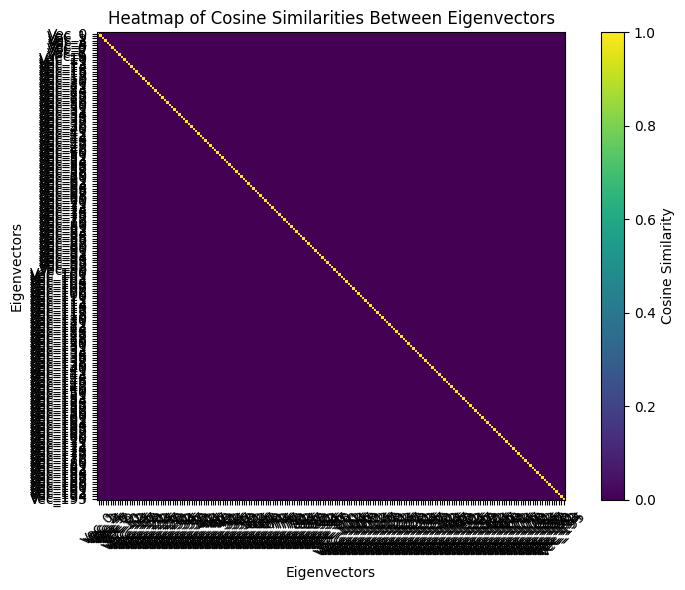

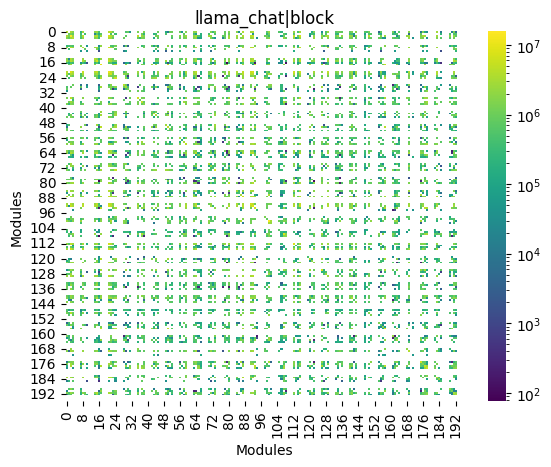

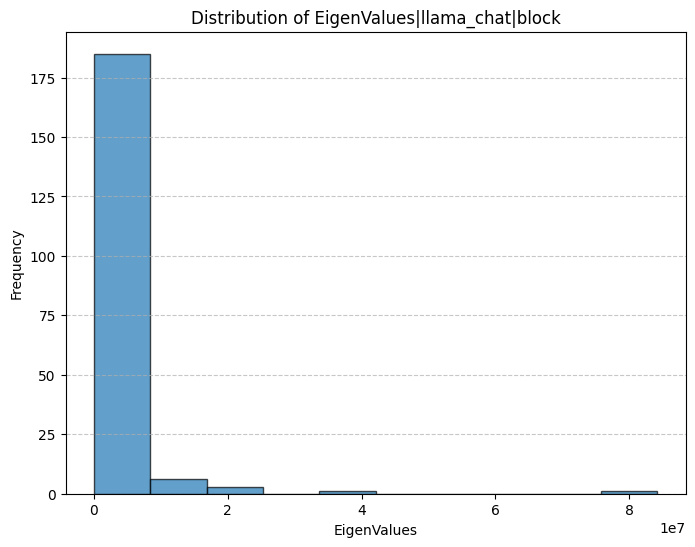

llama_chat block
-7.905707939827311e-09
-6.246753696154824e-09
-5.763869239382611e-09
-5.033129928029427e-09
-4.494489381115876e-09
-3.954761307993009e-09
-3.522096503481596e-09
-3.3212581870496707e-09
-2.938867518435197e-09
-2.86021026803855e-09
-2.8271400441205415e-09
-2.2806798189549707e-09
-2.1115053133333367e-09
-2.0599510342748636e-09
-1.7370356220928316e-09
-1.5257409999712357e-09
-1.3603809115915697e-09
-1.2214920001341835e-09
-1.1579254052285647e-09
-1.1122427201023386e-09
-9.896616720987293e-10
-9.41959436884462e-10
-8.370748650095208e-10
-6.938955219312164e-10
-5.540466838211359e-10
-5.004911144267122e-10
-3.5325744024978497e-10
-3.2694191592702313e-10
-2.7718024957639393e-10
-2.633386365233106e-10
-2.608710475607593e-10
-1.93273786423774e-10
-1.8160373737584122e-10
-1.6473106347378195e-10
-1.6032232441416635e-10
-1.0948561534437843e-10
-8.384488906656889e-11
-7.765212093404359e-11
-7.715295697453687e-11
-4.181058348902738e-11
-4.0156178651093917e-11
-1.9032194216671387e-11


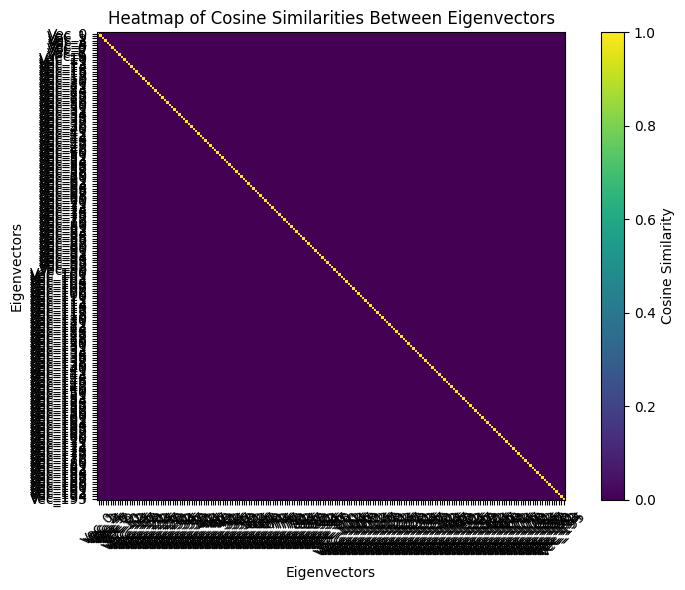

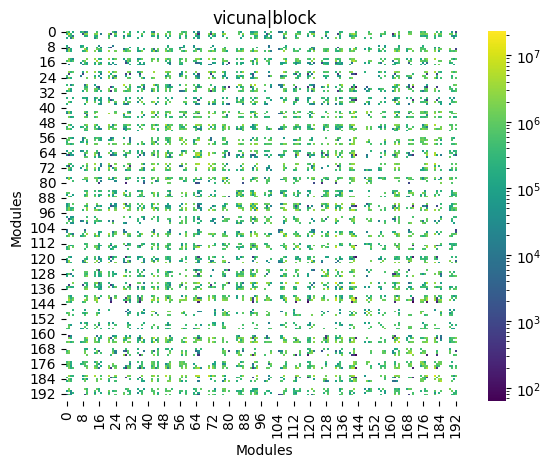

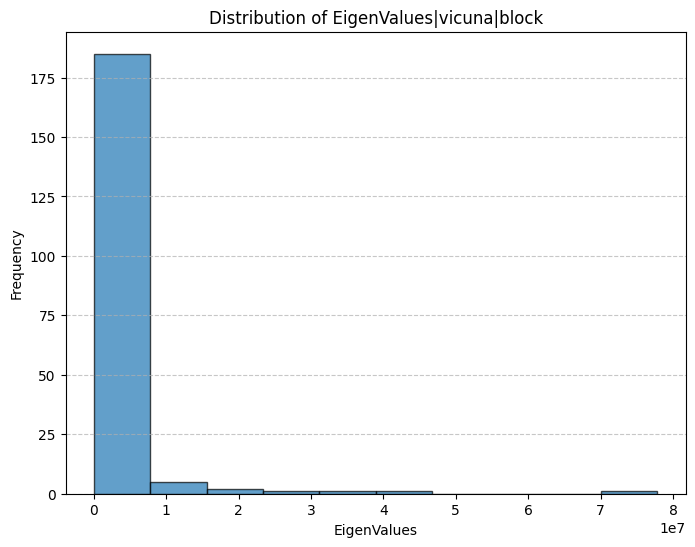

vicuna block
-7.45866536061645e-09
-6.264906105450651e-09
-5.3713479076547135e-09
-5.266518532502815e-09
-5.152025468285056e-09
-4.56412769051649e-09
-4.508921197894819e-09
-3.895653322592167e-09
-3.3693501116400692e-09
-2.9846415431529895e-09
-2.982950165596647e-09
-2.2813110253997923e-09
-2.174292859980199e-09
-2.03227574524359e-09
-1.981394482609203e-09
-1.6133450482977693e-09
-1.4122156968543843e-09
-1.336734088988617e-09
-1.3146245505231766e-09
-1.1571041625531784e-09
-1.0494025828374642e-09
-9.96780165979203e-10
-9.208272685651925e-10
-8.314405849874986e-10
-6.065253917699701e-10
-5.511085012211496e-10
-5.230896131593113e-10
-4.268939931480416e-10
-3.887917553641865e-10
-3.3469816956768223e-10
-3.1847924317861924e-10
-3.036884038546414e-10
-2.9815882300674765e-10
-2.6392374751293044e-10
-2.3420543782417643e-10
-1.9630239822348974e-10
-1.6515169437772748e-10
-1.4636724636372487e-10
-1.0583158050129163e-10
-1.0142727069749553e-10
-7.606561682019443e-11
-6.206862363524808e-11
-5.829

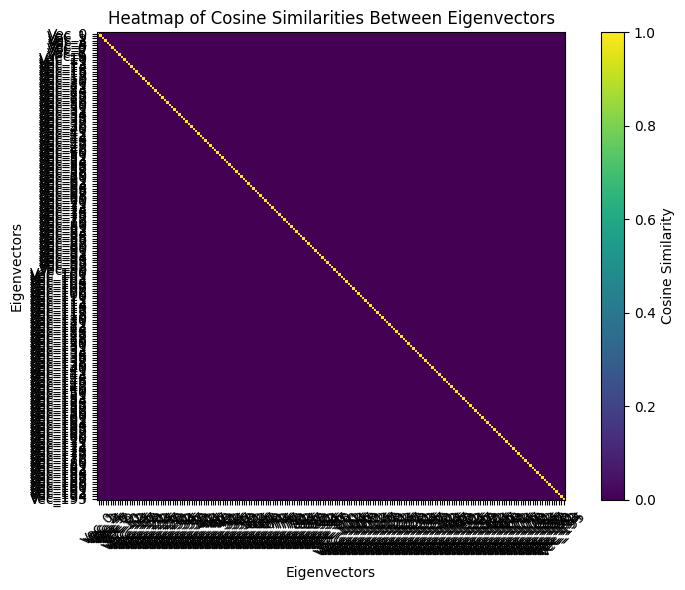

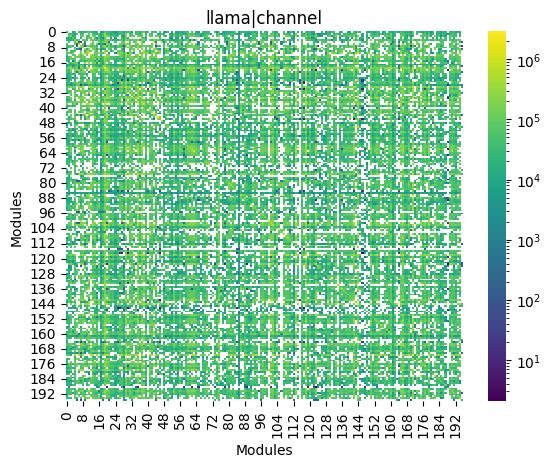

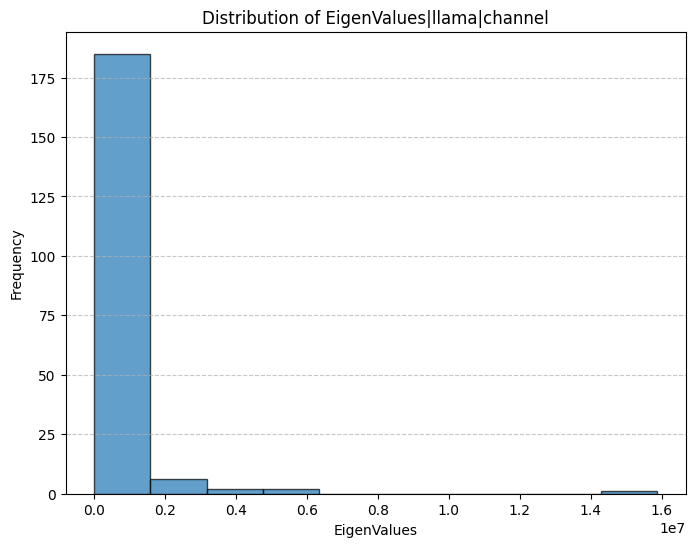

llama channel
-2.23038581534333e-09
-1.7026381249829742e-09
-1.4785054679894475e-09
-1.273443087523555e-09
-1.138536042280674e-09
-1.002199532830307e-09
-8.56890719998e-10
-8.342049581118377e-10
-7.029995751597414e-10
-6.915056641567659e-10
-6.397367905103526e-10
-5.932704010191167e-10
-5.40651772526179e-10
-5.090545395095575e-10
-4.925074601488317e-10
-4.6512195206438364e-10
-4.3716765844063134e-10
-3.848352561495928e-10
-3.7320792380955233e-10
-3.634285014193672e-10
-3.5645381118141084e-10
-3.1483178769801746e-10
-2.97027092411838e-10
-2.735095418124557e-10
-2.722693234299596e-10
-2.3149792240690798e-10
-2.3110487125212823e-10
-2.252955477213994e-10
-2.1031103520792454e-10
-1.9404189888236098e-10
-1.9339029681020346e-10
-1.8123403534575342e-10
-1.6925163276244974e-10
-1.6475543346669137e-10
-1.5748074581353453e-10
-1.3902900163299047e-10
-1.3141025115326645e-10
-1.2941513492821511e-10
-1.2307775390141707e-10
-1.216076121769812e-10
-1.1045029250245293e-10
-9.890824365009808e-11
-9.822

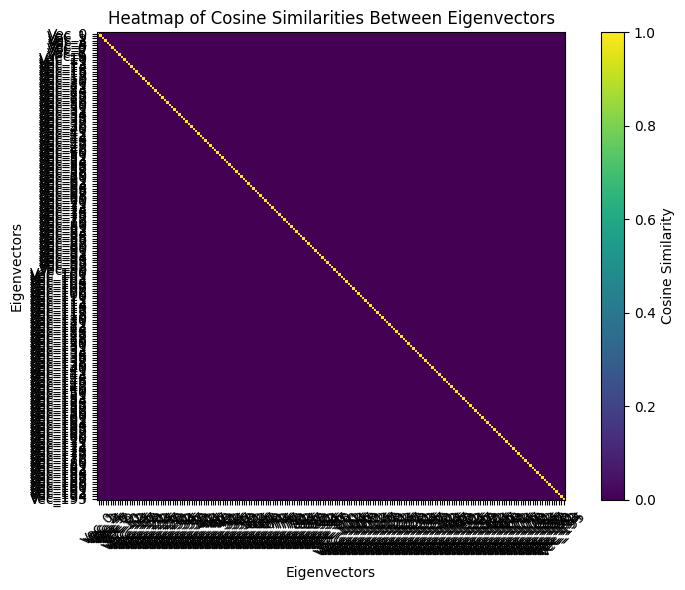

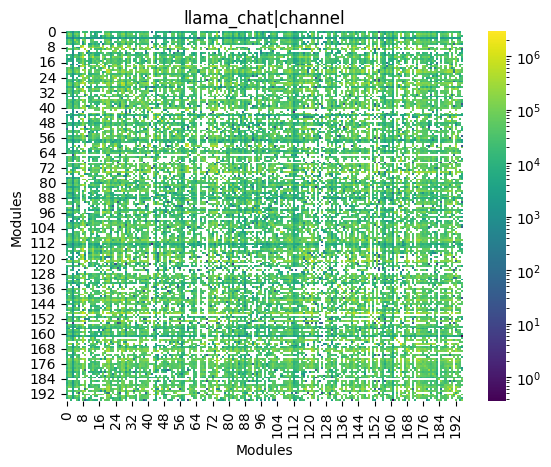

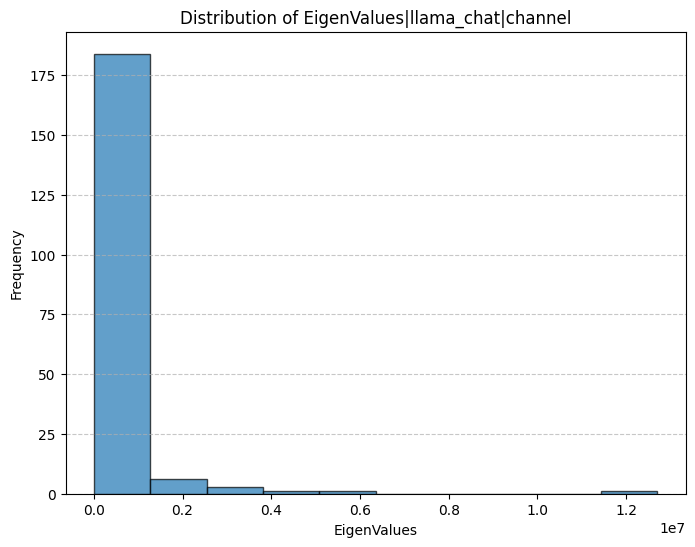

llama_chat channel
-1.886423891308051e-09
-1.750754825724554e-09
-1.5481503191167186e-09
-1.1256180622154967e-09
-9.77087014913361e-10
-9.142494446571897e-10
-7.989383830254472e-10
-7.707121221859107e-10
-7.556149850137532e-10
-6.41744699914477e-10
-5.722881623411677e-10
-5.409356017363343e-10
-4.915287954588077e-10
-4.790983001361895e-10
-4.4761425101359024e-10
-3.9458010269279914e-10
-3.76204232440686e-10
-3.695784323127283e-10
-3.5054127360034734e-10
-3.426923295839637e-10
-2.7850350781604367e-10
-2.7123261963669544e-10
-2.5534399320365403e-10
-2.499167030822783e-10
-2.4062074765355e-10
-2.2820214770088102e-10
-2.1123970987066115e-10
-2.0499202645154267e-10
-2.031441330808415e-10
-1.83482413284881e-10
-1.7005883207619112e-10
-1.6876693343608314e-10
-1.6136170892460013e-10
-1.56298189116107e-10
-1.4610324410211517e-10
-1.4555472992655216e-10
-1.3126962786803256e-10
-1.2748859713795948e-10
-1.2236083563415848e-10
-1.1007534852413183e-10
-1.0994660435425767e-10
-1.0381766068107552e-10


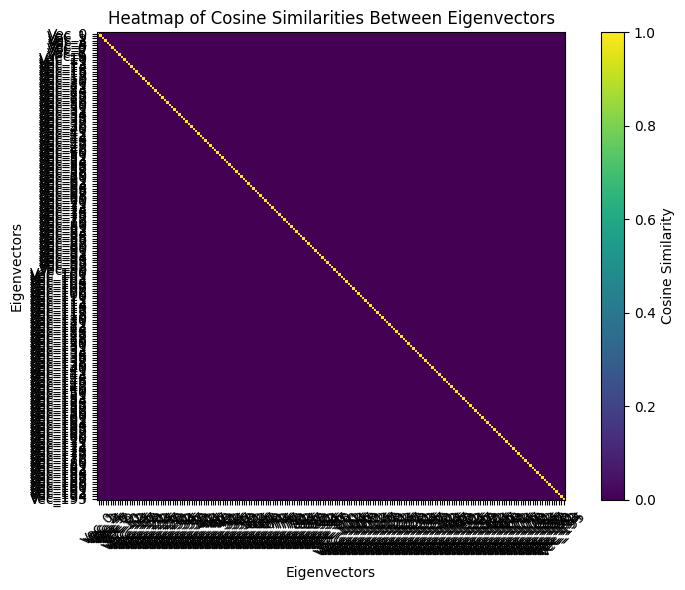

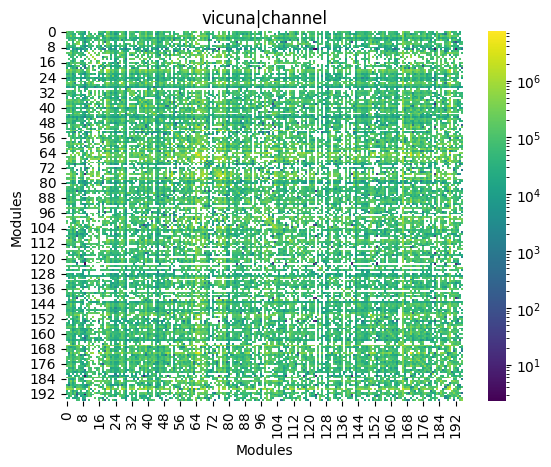

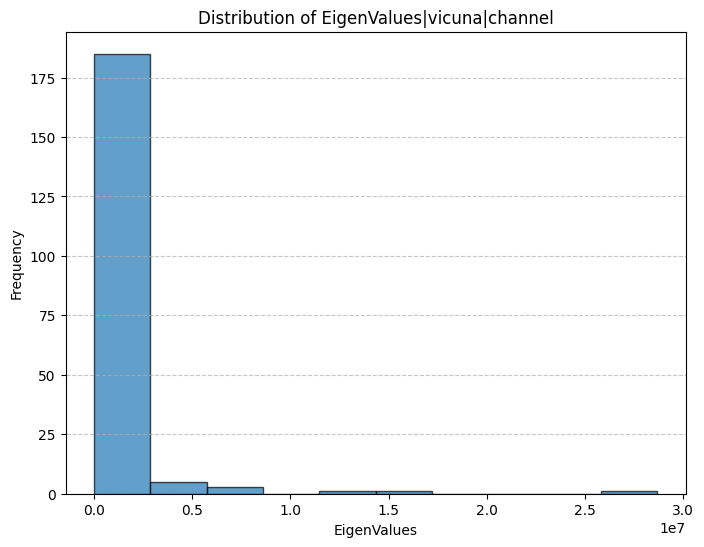

vicuna channel
-6.463093797235978e-09
-2.865951014005372e-09
-2.562008697724289e-09
-2.1448564569563487e-09
-1.930629354046868e-09
-1.703451997251578e-09
-1.5770711448982268e-09
-1.4296445708962236e-09
-1.4179646466056296e-09
-1.3482912846589213e-09
-1.254238241613812e-09
-1.220741755135937e-09
-1.0605383982759778e-09
-1.060340972622268e-09
-1.0559281503765261e-09
-9.216937893003334e-10
-8.279109751560503e-10
-7.764550412610808e-10
-6.981821639969302e-10
-6.882166771552474e-10
-6.591370562162137e-10
-6.183404630096469e-10
-6.088431549826839e-10
-5.378631409376958e-10
-5.287640553151332e-10
-5.252988210497261e-10
-5.138798535715687e-10
-4.67529238458411e-10
-4.539578659410035e-10
-3.894026651905708e-10
-3.4249872485254974e-10
-3.3415778222803703e-10
-3.143753305664585e-10
-2.86852748267198e-10
-2.811771914327773e-10
-2.6990070950172173e-10
-2.501099103821336e-10
-2.387718904918369e-10
-2.2925874488906612e-10
-2.1497617376623947e-10
-2.0676000918587474e-10
-1.9250627724616945e-10
-1.8816

In [8]:
from numpy import linalg as LA
from matplotlib.colors import LogNorm, Normalize

# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

for idx, network_data in enumerate(modules_community_dataset["network_data"]):
    (skill_label,dataset_list,module_label),(skill_dataset, dataset_modules,skills_modules) = network_data
    C = np.dot(skills_modules.T,skills_modules)
    eigenvalues, eigenvectors = LA.eigh(C)
    pruner_style = modules_community_dataset["pruner_style"][idx]
    model = modules_community_dataset["model"][idx]
    # Compute cosine similarity between all pairs of eigenvectors
    num_vectors = len(eigenvectors)
    cosine_similarities = np.zeros((num_vectors, num_vectors))

    for i in range(num_vectors):
        for j in range(num_vectors):
            cosine_similarities[i, j] = cosine_similarity(eigenvectors[i], eigenvectors[j])

    plt.figure(figsize=(8, 6))
    plt.imshow(cosine_similarities, cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Cosine Similarity")
    plt.title("Heatmap of Cosine Similarities Between Eigenvectors")
    plt.xticks(range(num_vectors), [f"Vec_{i}" for i in range(num_vectors)], rotation=45)
    plt.yticks(range(num_vectors), [f"Vec_{i}" for i in range(num_vectors)])
    plt.xlabel("Eigenvectors")
    plt.ylabel("Eigenvectors")
    plt.tight_layout()
    plt.show()

    ax = sns.heatmap(C, cmap='viridis',norm=LogNorm())
    plt.xlabel('Modules')
    plt.ylabel('Modules')
    plt.title(f"{model}|{pruner_style}")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(eigenvalues, bins=10, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of EigenValues|{model}|{pruner_style}')
    plt.xlabel('EigenValues')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    print(model, pruner_style)
    for e in eigenvalues:
        print(e)
    print("+"*100)
            

In [5]:
for c, cc in modules_community_dataset["network_property"][0]["community"].items():
    print(c, cc)
_, all_label_skills = all_skill_label()
print(modules_community_dataset["frequency_skill"][0])
#module_dataset_kl = get_high_datasets(modules_community_dataset["community"]["kl"][idx][comm_name]["dataset"]["all"], top_skill=5)

0 ['3_attn.q', '3_attn.o', '5_attn.q', '6_attn.o', '7_attn.q', '8_attn.q', '8_attn.o', '11_attn.q', '13_attn.q', '13_attn.o', '14_attn.k', '14_attn.v', '16_attn.q', '18_attn.k', '20_attn.o', '21_attn.k', '23_attn.k', '23_attn.v', '23_attn.o', '25_attn.v', '25_attn.o', '26_attn.k', '27_attn.o', '28_attn.o', '29_attn.k', '30_attn.v', '30_attn.o']
1 ['3_attn.v', '6_attn.v', '7_attn.o', '9_attn.k', '10_attn.v', '12_attn.q', '14_attn.q', '22_attn.o', '28_attn.q', '29_attn.q', '3_attn.k', '6_attn.k', '9_attn.v', '28_attn.k', '30_attn.k', '4_attn.o', '12_attn.v', '17_attn.v', '20_attn.k', '28_attn.v', '17_attn.q', '21_attn.o', '24_attn.q', '26_attn.q', '18_attn.o', '22_attn.k', '16_attn.k']
2 ['4_attn.q', '4_attn.v', '5_attn.k', '5_attn.v', '5_attn.o', '8_attn.k', '9_attn.q', '9_attn.o', '11_attn.v', '11_attn.o', '12_attn.k', '12_attn.o', '13_attn.v', '15_attn.q', '17_attn.o', '18_attn.v', '19_attn.q', '19_attn.k', '19_attn.o', '21_attn.q', '23_attn.q', '24_attn.v', '25_attn.q', '26_attn.v', 

## Community Density

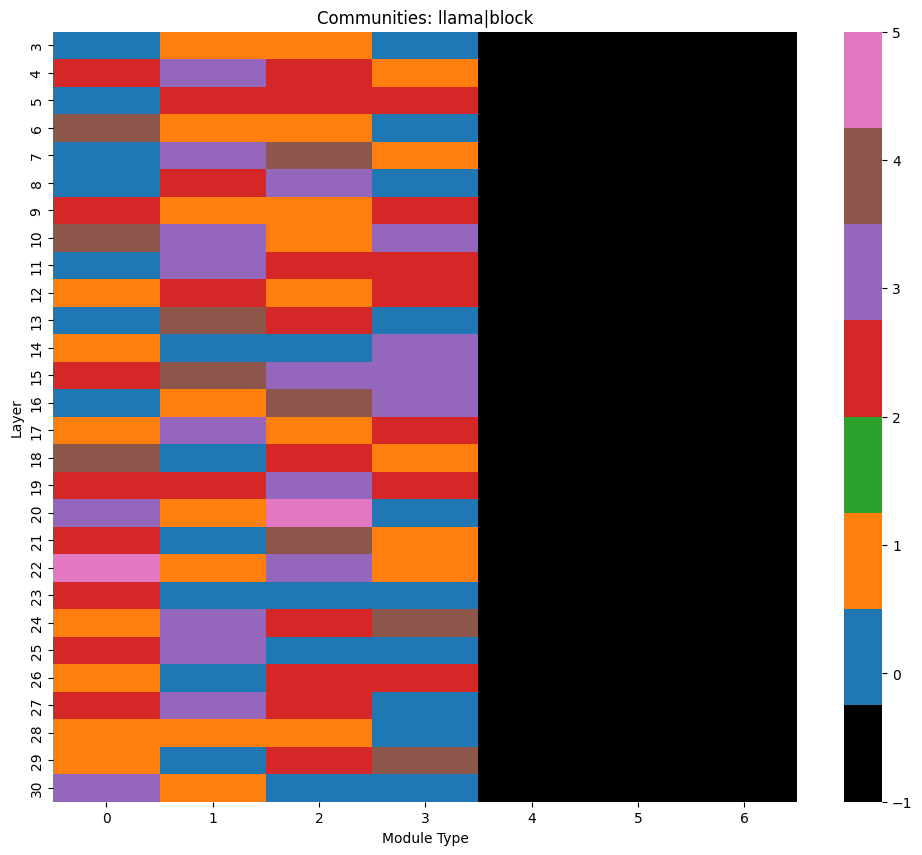

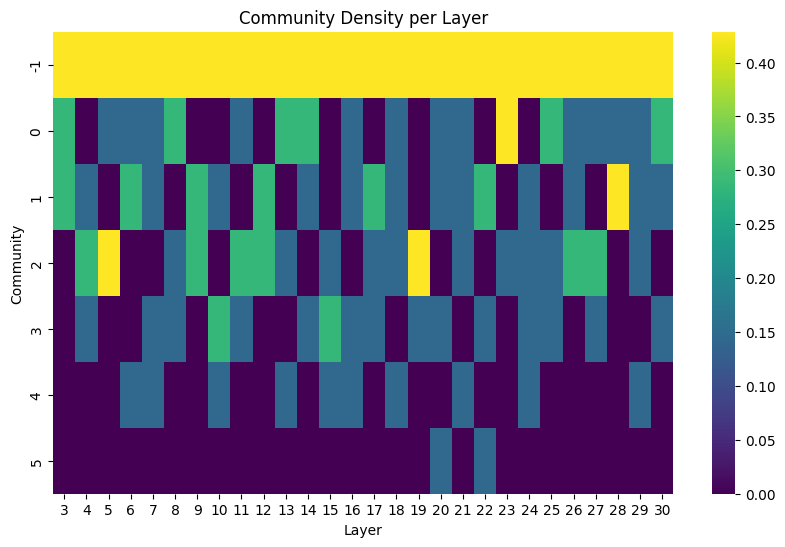

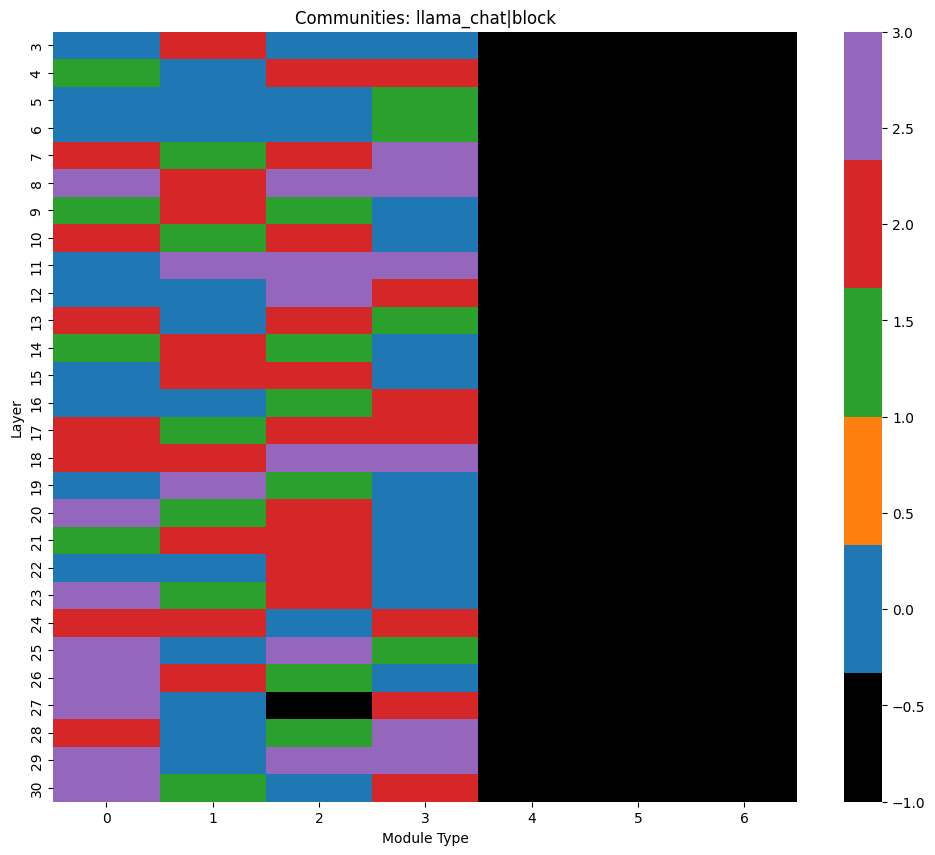

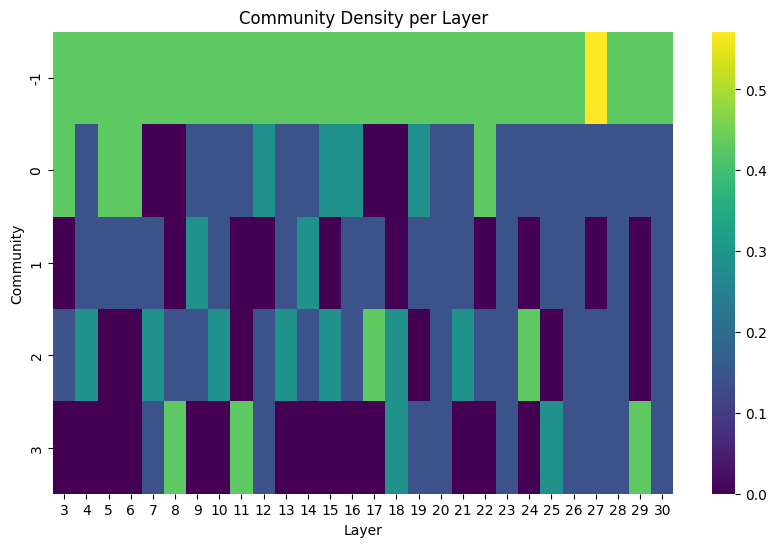

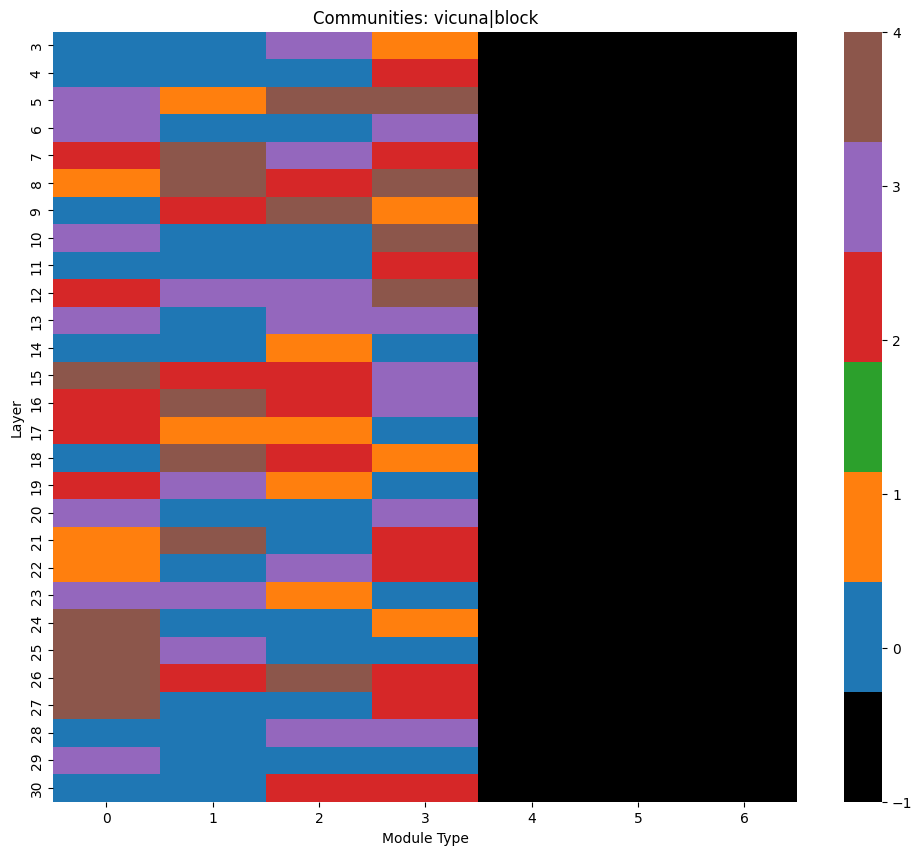

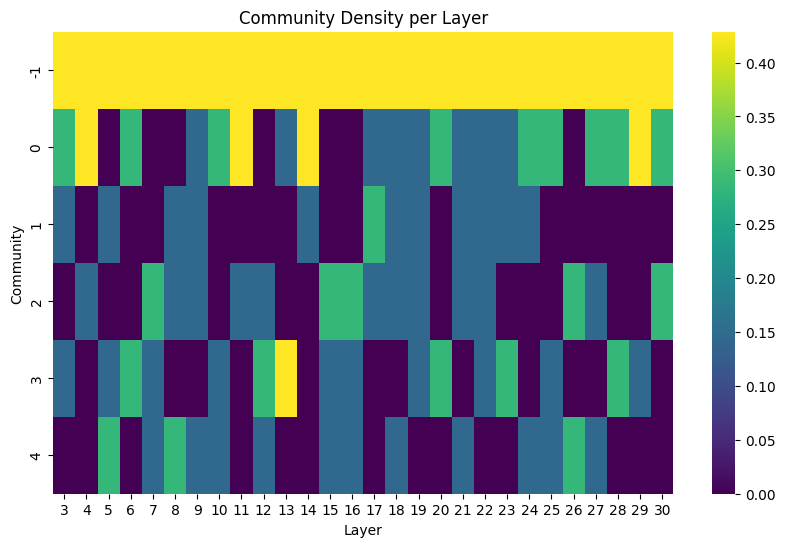

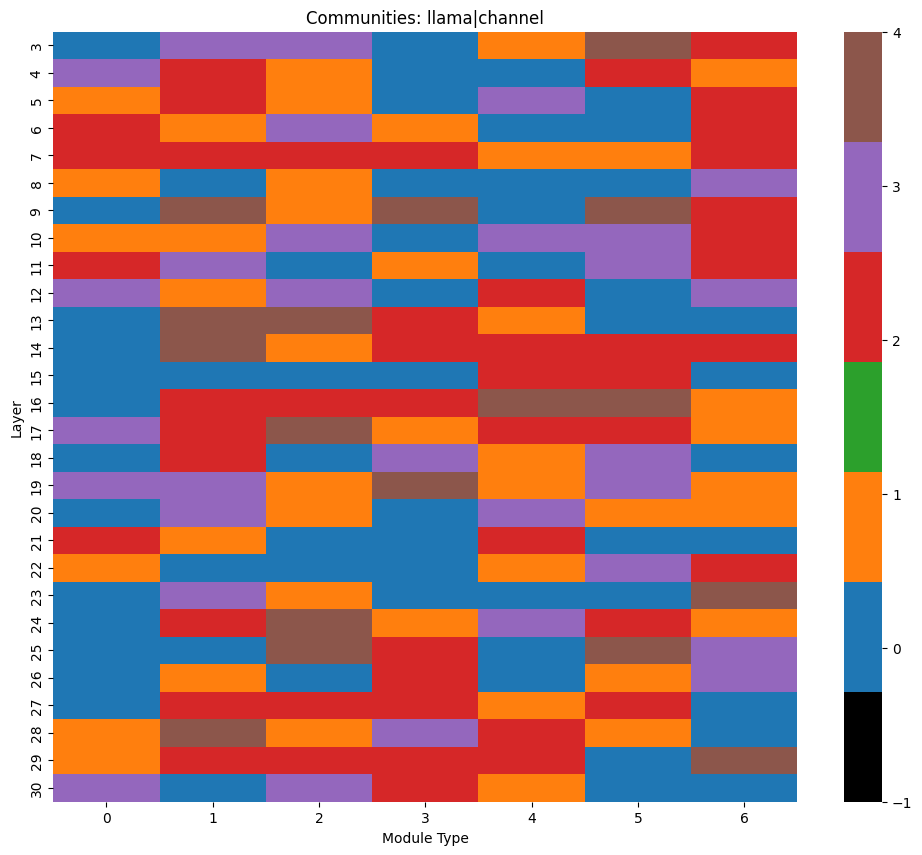

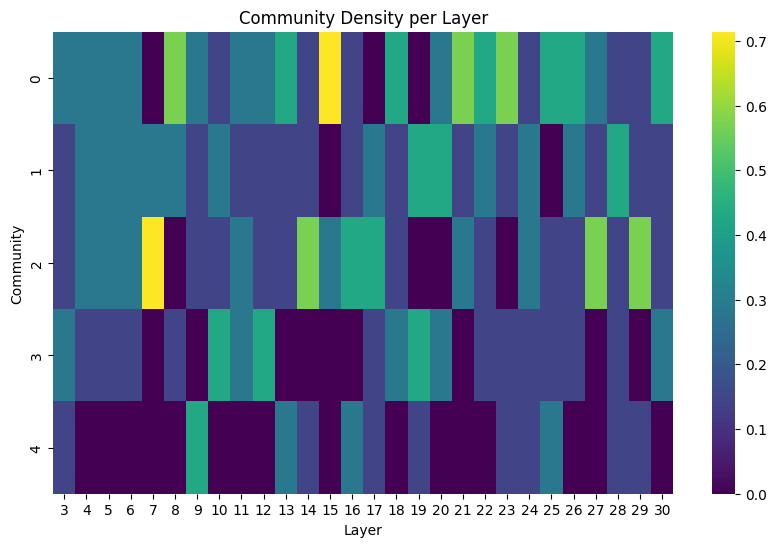

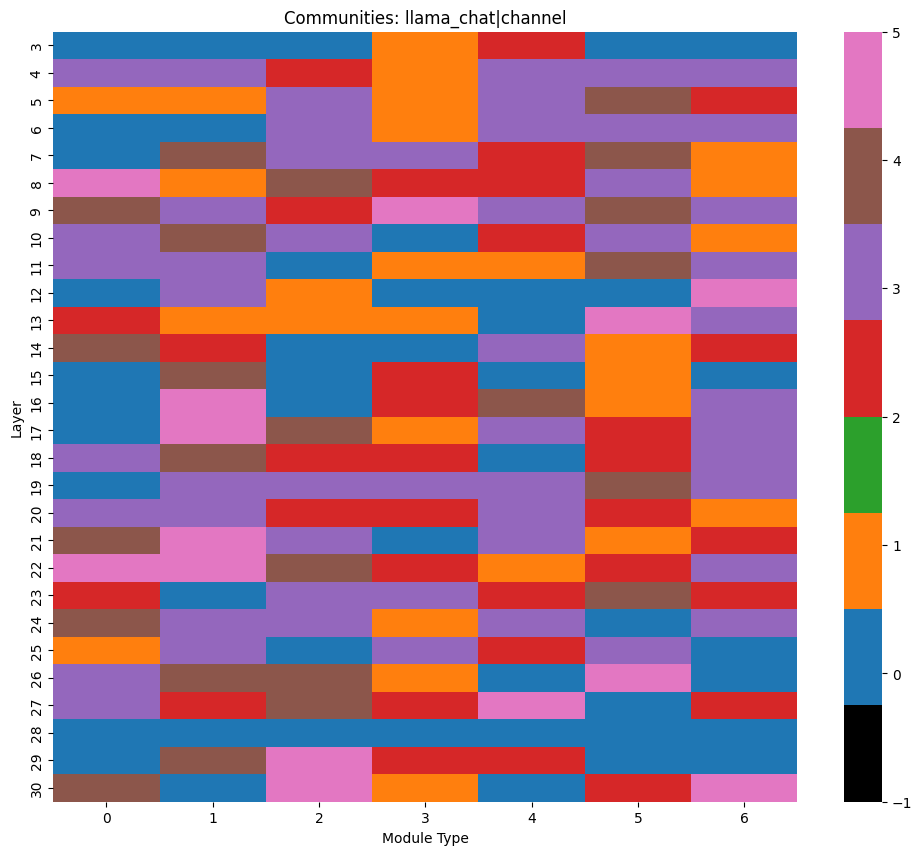

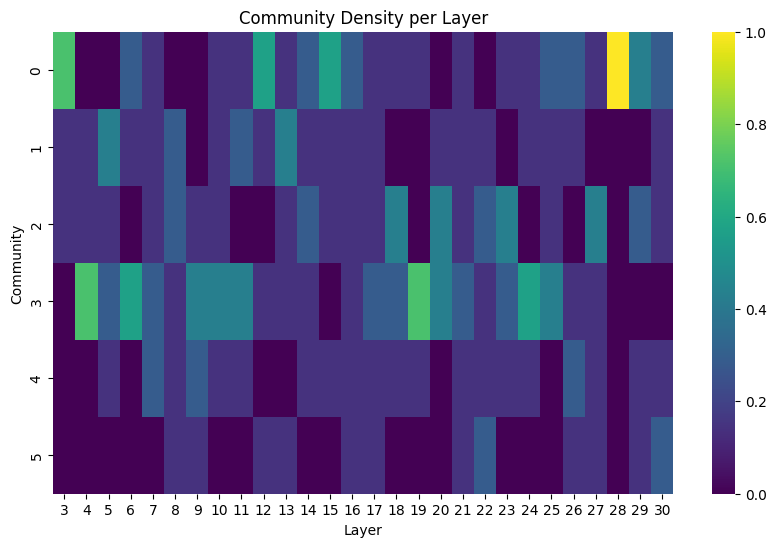

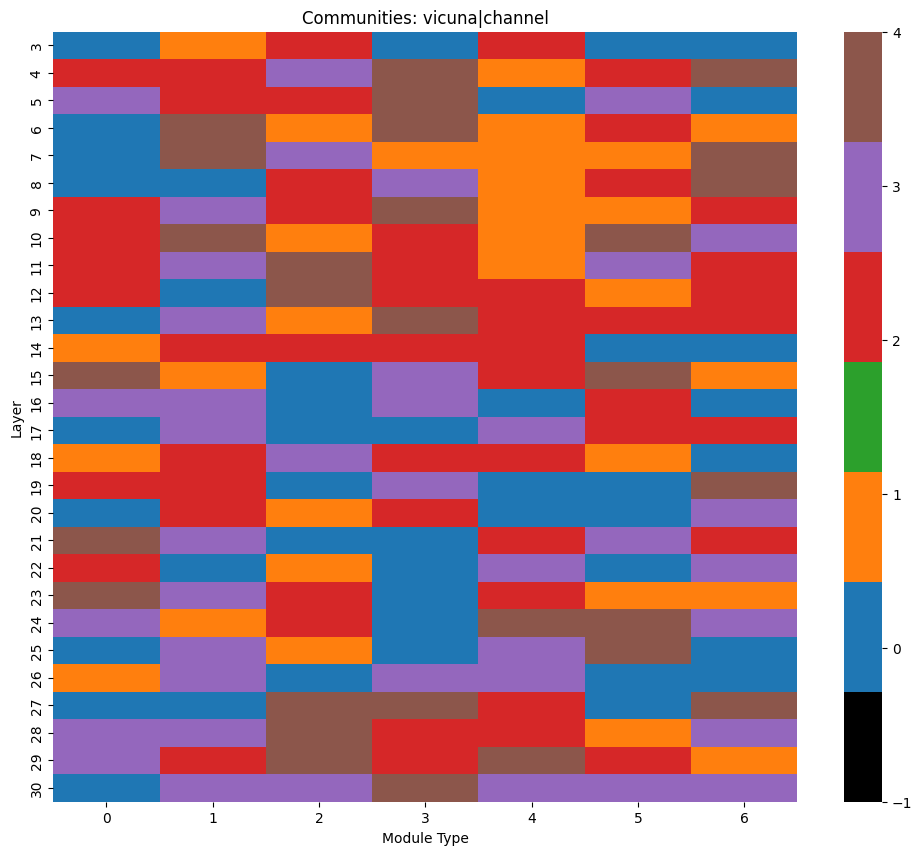

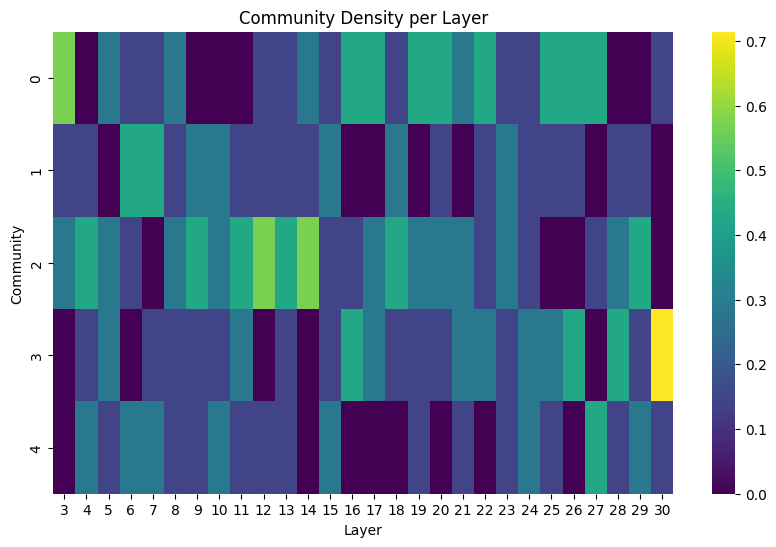

In [7]:
import matplotlib.colors as mcolors

def create_matrix(community):
    modules=["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
    all_layer = [str(i) for i in range(3,31)]
    data = []
    for l_idx ,l in enumerate(all_layer):
        for m_idx,  m in enumerate(modules):
            if f"{l}_{m}" in community:
                c = community[f"{l}_{m}"]
            else:
                c = -1
            data.append({"Layer":int(l),
                    "Modules":m_idx, 
                    "Community":int(c)})
    return pd.DataFrame(data), modules, all_layer

def density(df):
    density_df = df.groupby(['Layer', 'Community']).size().unstack(fill_value=0)

    # Normalize to get density
    density_df = density_df.div(density_df.sum(axis=1), axis=0)

    # Calculate Shannon Diversity Index for each layer
    diversity_index = -np.sum(density_df * np.log(density_df + 1e-10), axis=1)

    # Plot Density Heatmap
    plt.figure(figsize=(10, 6))
    plt.title("Community Density per Layer")
    sns.heatmap(density_df.T, cmap="viridis", cbar=True)
    plt.xlabel("Layer")
    plt.ylabel("Community")
    plt.show() 

for idx, model in enumerate(modules_community_dataset["model"]):
    pruner_style = modules_community_dataset["pruner_style"][idx]
    partition = modules_community_dataset["network_property"][idx]["partition"]
    num_colors = len(modules_community_dataset["network_property"][idx]["community"])
    
    data,m,l = create_matrix(partition)
    if -1 in data["Community"].unique():
        isolated = True
    else: 
        False
    pivot_data = data.pivot(index="Layer", columns="Modules", values="Community").sort_index(ascending=True)
    pivot_data.index = pivot_data.index.astype(int)
    sorted_data = pivot_data.sort_index()
    if isolated:
        cmap = sns.color_palette("tab10", num_colors+1)
        cmap.insert(0, (0, 0, 0))
    else:
        cmap = sns.color_palette("tab10", num_colors)
    # Create a custom colormap from the discrete colors
    discrete_cmap = mcolors.ListedColormap(cmap)
    # Plotting the heatmap with hierarchical y-axis labels for layers and module types
    plt.figure(figsize=(12, 10))
    sns.heatmap(sorted_data, yticklabels=True,vmin=-1,cmap=discrete_cmap)
    plt.title(f"Communities: {model}|{pruner_style}")
    plt.xlabel("Module Type")
    plt.ylabel("Layer")
    plt.show()
    density(data)


## Community Skill Analysis

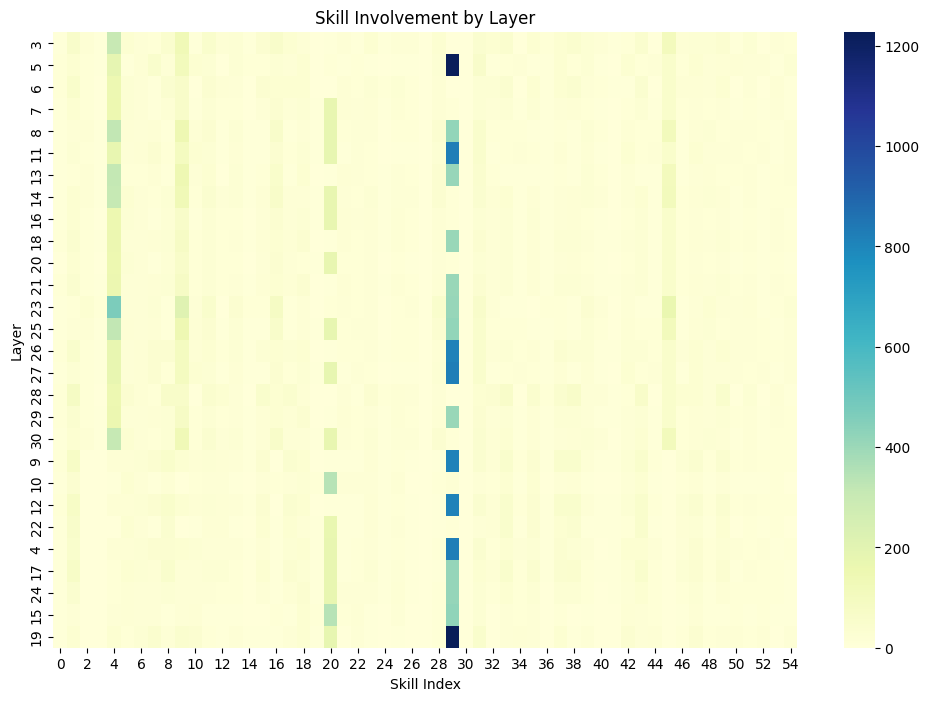

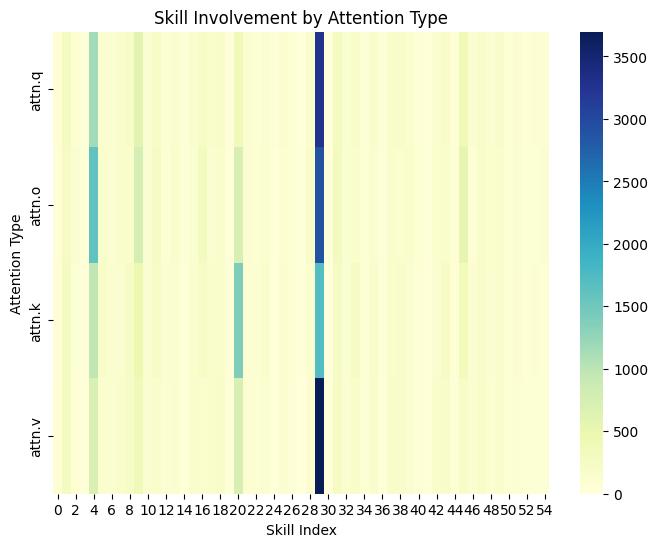

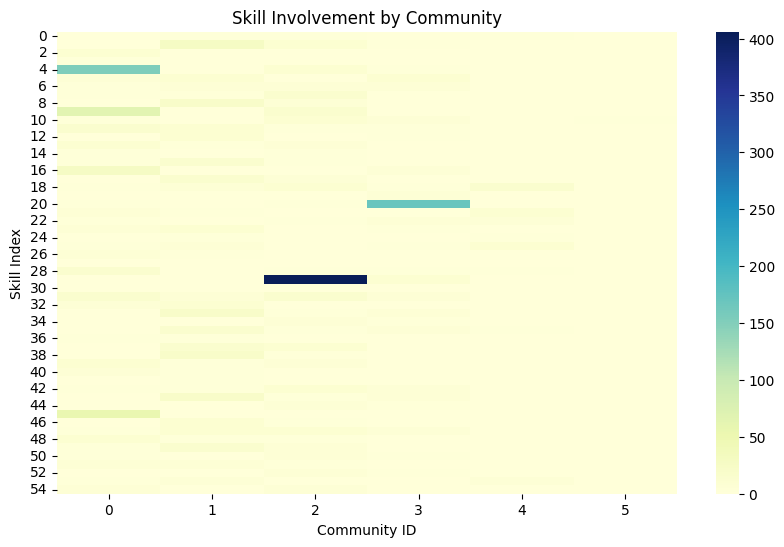

In [11]:
from collections import Counter
from scipy.stats import pearsonr
from collections import defaultdict, Counter
for idx, model in enumerate(modules_community_dataset["model"]):
    pruner_style = modules_community_dataset["pruner_style"][idx]
    communities = modules_community_dataset["network_property"][idx]["community"]
    skill_frequencies = modules_community_dataset["frequency_skill"][idx]
    G = modules_community_dataset["graph"][idx]

    skill_involvement = defaultdict(lambda: defaultdict(int))

    for community_id, skills in skill_frequencies.items():
        for skill_index, freq in enumerate(skills):
            skill_involvement[community_id][skill_index] += freq

    # Step 2: Aggregate skill involvement by layer and attention type across communities
    layer_skill_involvement = defaultdict(lambda: defaultdict(int))
    attn_type_skill_involvement = defaultdict(lambda: defaultdict(int))

    for community_id, modules in communities.items():
        skill_freqs = skill_frequencies[community_id]
        
        for module in modules:
            layer = int(module.split('_')[0])  # Extract the layer number
            attn_type = module.split('_')[1]  # Extract attention type (q, k, v, o)
            
            for skill_index, freq in enumerate(skill_freqs):
                # Aggregate by layer
                layer_skill_involvement[layer][skill_index] += freq
                
                # Aggregate by attention type
                attn_type_skill_involvement[attn_type][skill_index] += freq

    # Convert skill involvement data to DataFrames for easier visualization
    layer_skill_df = pd.DataFrame(layer_skill_involvement).fillna(0).T
    attn_type_skill_df = pd.DataFrame(attn_type_skill_involvement).fillna(0).T

    # Step 3: Visualization
    # Heatmap for Skill Involvement by Layer
    plt.figure(figsize=(12, 8))
    sns.heatmap(layer_skill_df, cmap="YlGnBu", annot=False, fmt=".0f")
    plt.title("Skill Involvement by Layer")
    plt.xlabel("Skill Index")
    plt.ylabel("Layer")
    plt.show()

    # Heatmap for Skill Involvement by Attention Type
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn_type_skill_df, cmap="YlGnBu", annot=False, fmt=".0f")
    plt.title("Skill Involvement by Attention Type")
    plt.xlabel("Skill Index")
    plt.ylabel("Attention Type")
    plt.show()

    # Step 4: Community-wise skill involvement
    community_skill_df = pd.DataFrame(skill_involvement).fillna(0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(community_skill_df, cmap="YlGnBu", annot=False, fmt=".0f")
    plt.title("Skill Involvement by Community")
    plt.xlabel("Community ID")
    plt.ylabel("Skill Index")
    plt.show()

    break

## Accuracy and Distribution

<Figure size 640x480 with 0 Axes>

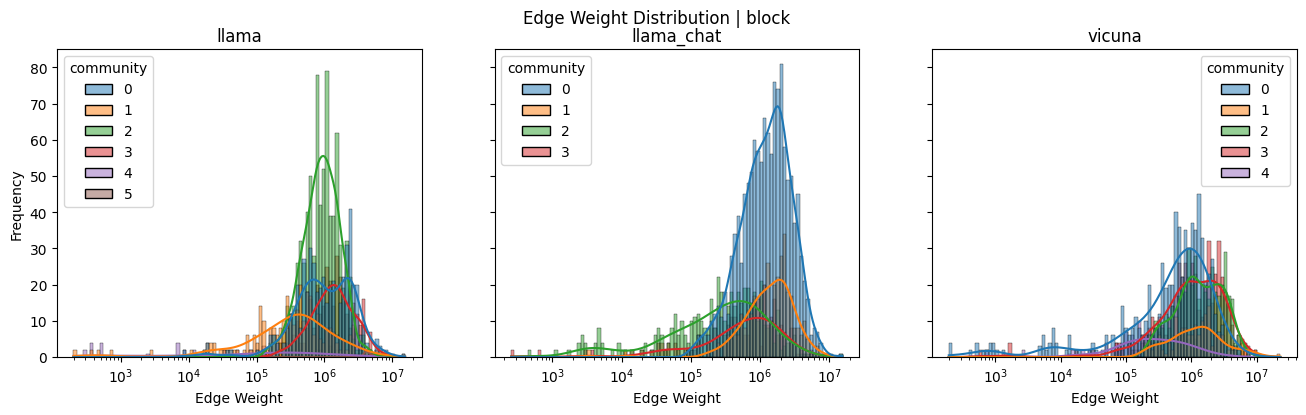

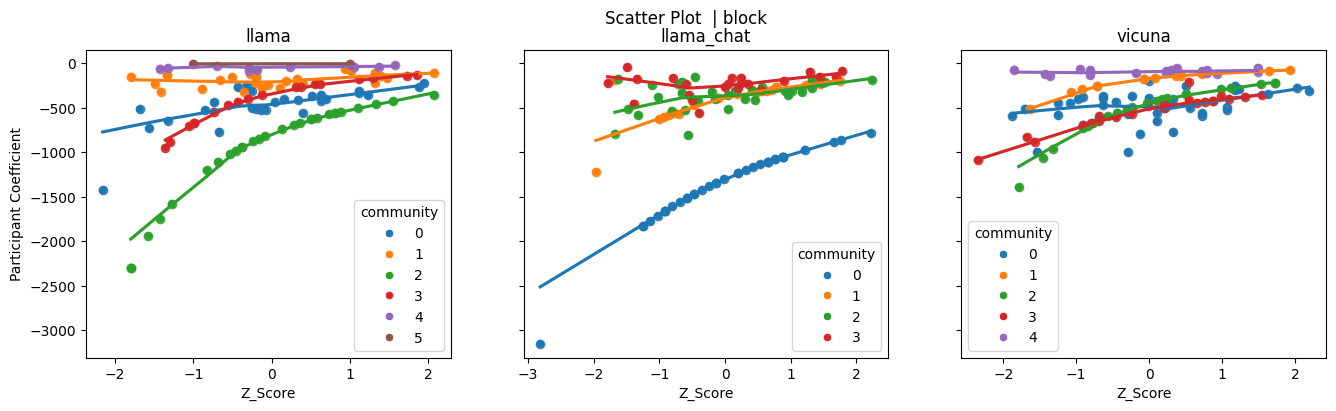

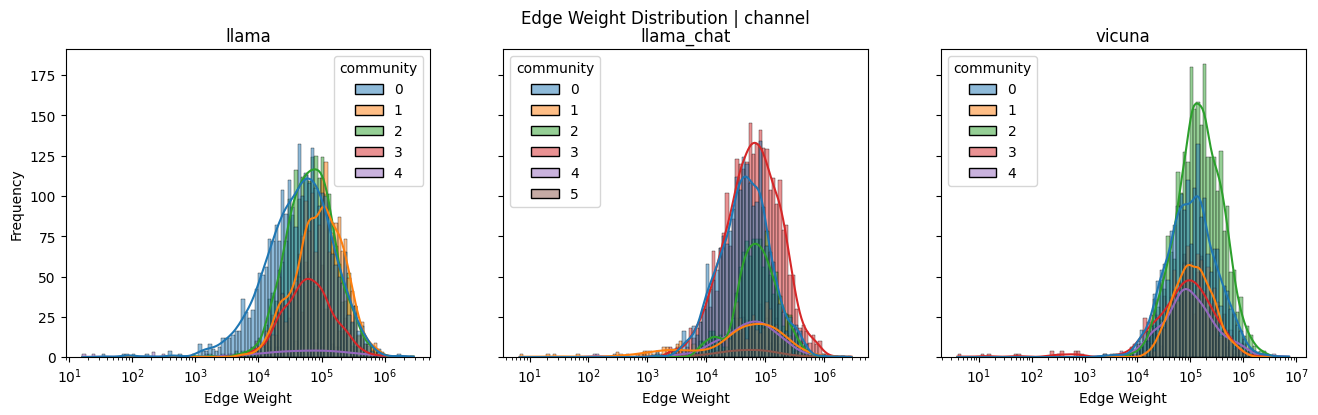

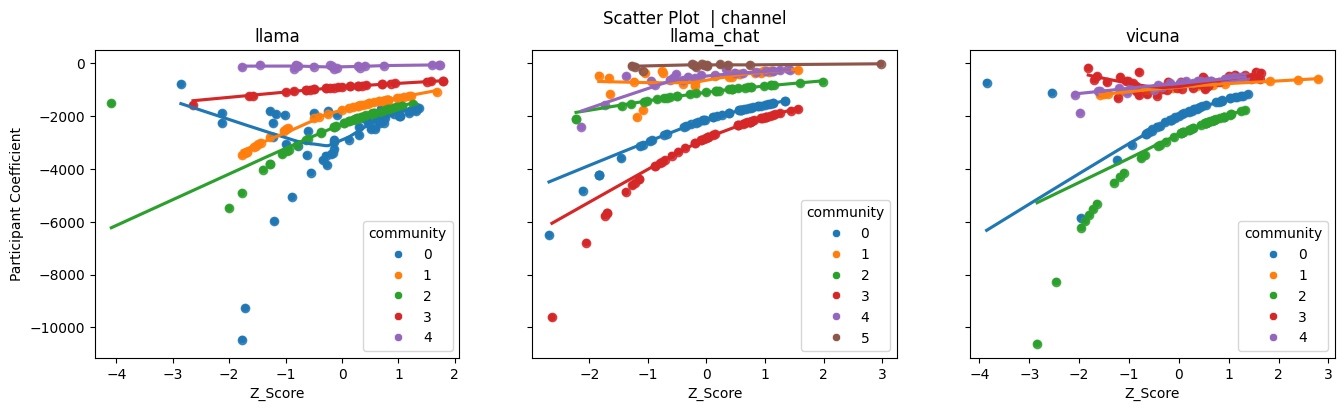

In [12]:
from math import floor
set_random_seed(int(2))
plt.clf()
modules=["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
layer_modules_label=[ str(i)+"_"+m  for i in range(3,31) for m in modules]
data_zscore_part = []
data_dist = []
data_correlation = []
for idx, model in enumerate(modules_community_dataset["model"]):
    pruner_style = modules_community_dataset["pruner_style"][idx]
    G = modules_community_dataset["graph"][idx]
    network_property = modules_community_dataset["network_property"][idx] 
    if idx%3 == 0:
        fig, ax = plt.subplots(figsize=(16,4),ncols=3, sharey=True)
        fig_node, ax_node = plt.subplots(figsize=(16,4),ncols=3,sharey=True)
        fig.suptitle(f'Edge Weight Distribution | {pruner_style}')
        fig_node.suptitle(f'Scatter Plot  | {pruner_style}') 
    if model== "llama" and pruner_style == "block":
        ((skill_label,dataset_list,module_label),(dataset_shape, dataset_modules,skills_modules))= modules_community_dataset["network_data"][idx]  
        node_data(skill_label, dataset_list, module_label, f"{model}_{pruner_style}_{sparsity_ratio}_nodes.csv")
        network_data(dataset_shape, dataset_list,skill_label,0,f"{model}_{pruner_style}_{sparsity_ratio}_datasets_skills.csv")
        network_data(dataset_modules, dataset_list, module_label,1, f"{model}_{pruner_style}_{sparsity_ratio}_datasets_modules.csv")
        network_data(skills_modules, skill_label, module_label,1, f"{model}_{pruner_style}_{sparsity_ratio}_skill_modules.csv")
        node_data(skill_label, None, module_label, f"{model}_{pruner_style}_{sparsity_ratio}_nodes_wo_dataset.csv")
    z_scores = within_module_z_score(G, network_property["community"])
    part_coeff = participation_coefficient(G, network_property["partition"])
    z_score_part_coeff = z_scores.merge(part_coeff, on=["node","community"], how="inner")
    z_score_part_coeff["pruner_style"] = [pruner_style]*z_score_part_coeff.shape[0] 
    z_score_part_coeff["model"] = [model]*z_score_part_coeff.shape[0] 
    
    community_weights,community_node_weighted_sum = collect_edge_weights(G, network_property["community"])
    community_weights["pruner_style"] = [pruner_style]*community_weights.shape[0] 
    community_weights["model"] = [model]*community_weights.shape[0] 
    sns.histplot(data=community_weights, x="weight", hue="community", kde=True, bins=100, log_scale=True, palette="tab10",ax= ax[idx-floor(int(idx/3)*3)])
    ax[idx-floor(int(idx/3)*3)].set_title(model)
    ax[idx-floor(int(idx/3)*3)].set_xlabel('Edge Weight')
    ax[idx-floor(int(idx/3)*3)].set_ylabel('Frequency')
    
    sns.scatterplot(data=z_score_part_coeff,x="z_scores",y="part_coeff",hue="community",ax= ax_node[idx-floor(int(idx/3)*3)], palette="tab10")
    for comm,color in zip(z_score_part_coeff["community"].unique(),sns.color_palette("tab10", len(z_score_part_coeff["community"].unique()))):
        sns.regplot(data=z_score_part_coeff[z_score_part_coeff["community"]==comm],x="z_scores",y="part_coeff",ax= ax_node[idx-floor(int(idx/3)*3)], color=color,lowess=True)
    ax_node[idx-floor(int(idx/3)*3)].set_title(model)
    ax_node[idx-floor(int(idx/3)*3)].set_ylabel('Participant Coefficient')
    ax_node[idx-floor(int(idx/3)*3)].set_xlabel('Z_Score')
    
    data_zscore_part.append(z_score_part_coeff)
    data_dist.append(community_weights)
    data_correlation.append(compute_correlation_community(z_score_part_coeff, model, pruner_style))

    '''sns.lineplot(data=community_node_weighted_sum, y="weight",x="degree", hue="community",  palette="tab10",ax= ax_node[pruner_idx])
    ax_node[pruner_idx].set_title(pruner_style)
    ax_node[pruner_idx].set_xlabel('Total Node Weight')
    ax_node[pruner_idx].set_ylabel('Frequency')'''
    if idx in  [2, 5]:
        plt.show()
data_zscore_part_concat = pd.concat(data_zscore_part, ignore_index=True)
data_zscore_part_concat.to_csv("./result/z_scores_part_coefficient.csv", index=False)
data_dist_concat = pd.concat(data_dist, ignore_index=True)
data_dist_concat.to_csv("./result/distribution_comm.csv", index=False)
data_corr_concat = pd.concat(data_correlation, ignore_index=True)
data_corr_concat.to_csv("./result/z_scores_part_correlation.csv", index=False) 

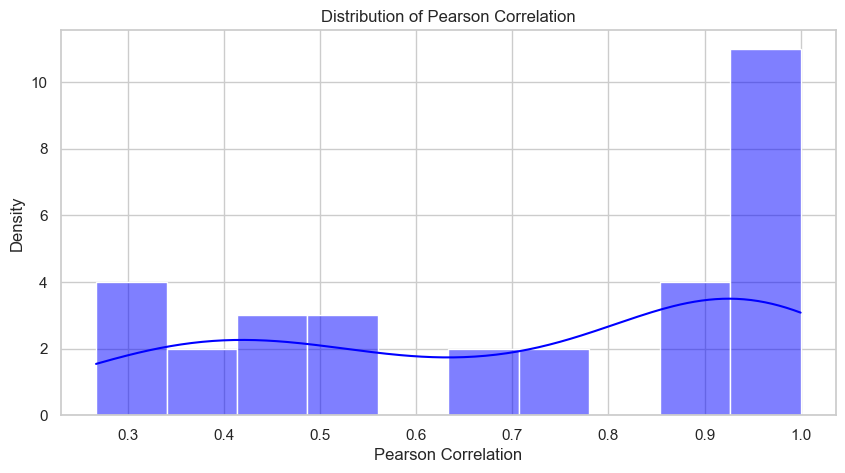

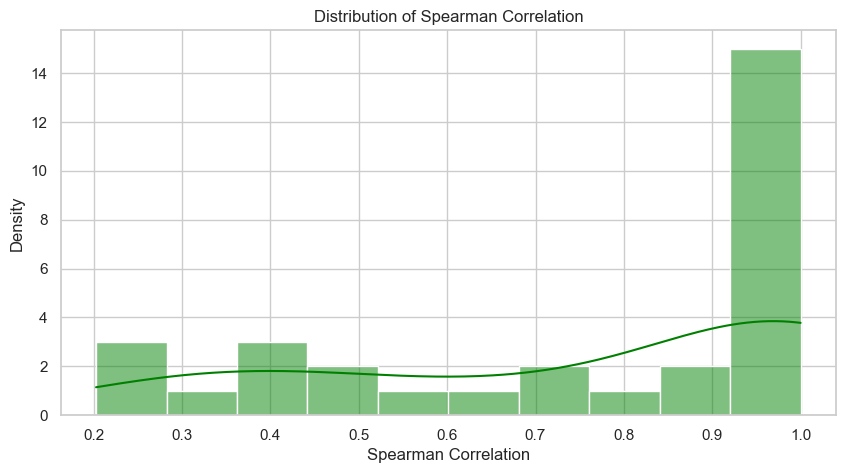

In [13]:

sns.set(style="whitegrid")

# Plot distribution for Pearson Correlation
plt.figure(figsize=(10, 5))
sns.histplot(data_corr_concat['pearson_correlation'], kde=True, color='blue', bins=10)
plt.title('Distribution of Pearson Correlation')
plt.xlabel('Pearson Correlation')
plt.ylabel('Density')
plt.show()

# Plot distribution for Spearman Correlation
plt.figure(figsize=(10, 5))
sns.histplot(data_corr_concat['spearman_correlation'], kde=True, color='green', bins=10)
plt.title('Distribution of Spearman Correlation')
plt.xlabel('Spearman Correlation')
plt.ylabel('Density')
plt.show()

# Accuracy for FineTuning

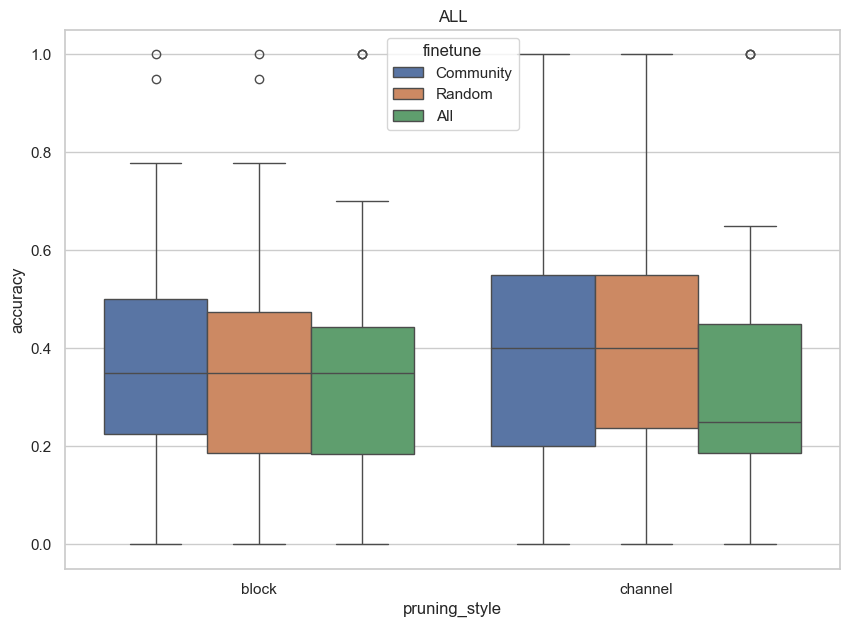

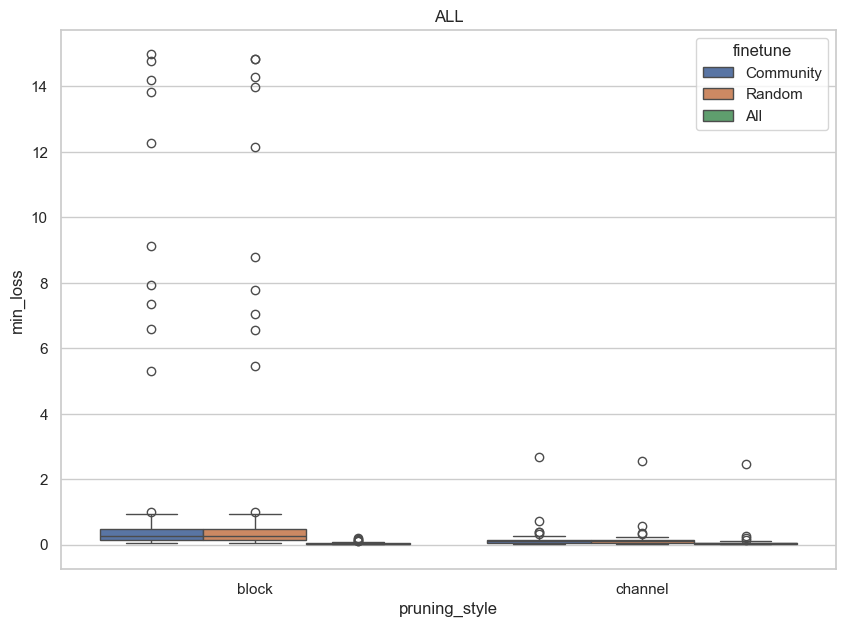

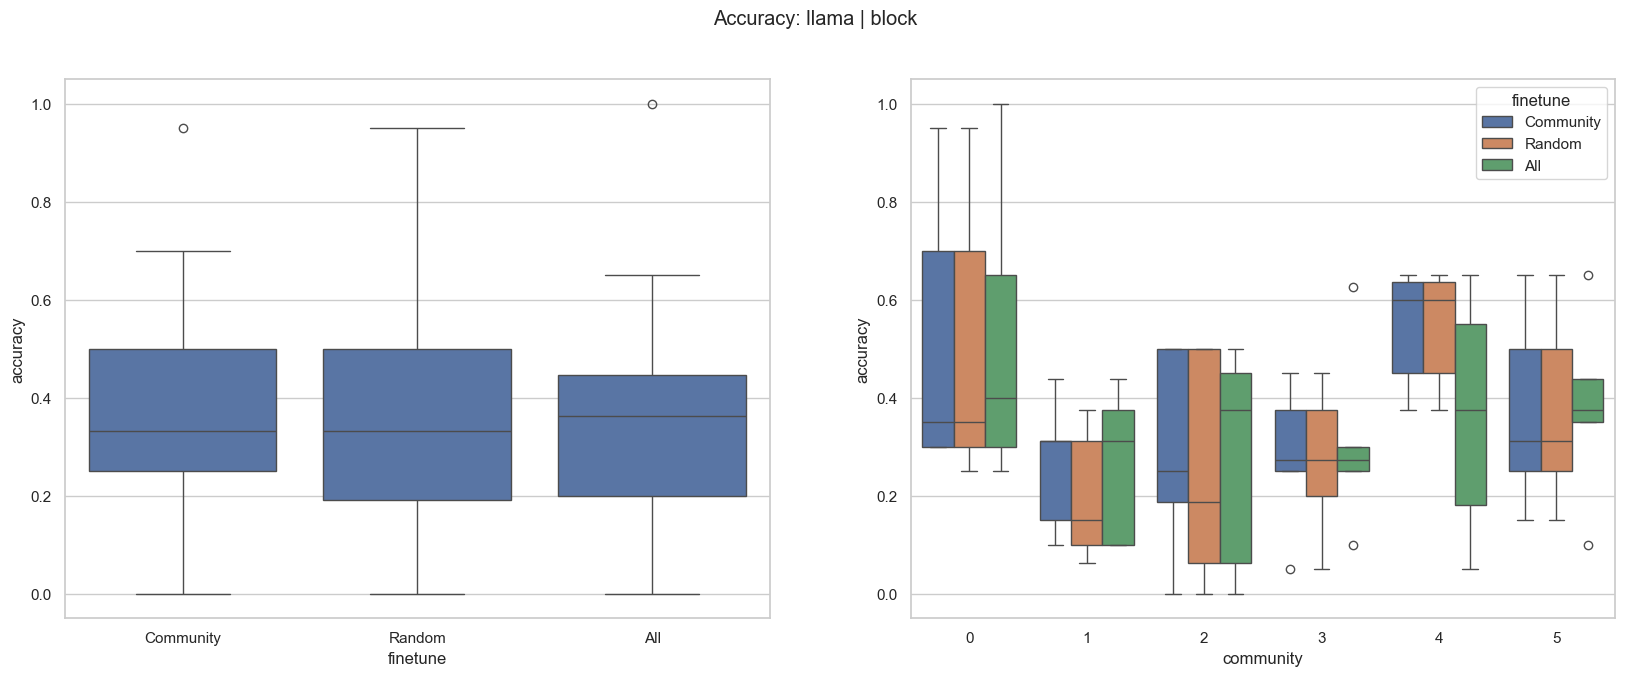

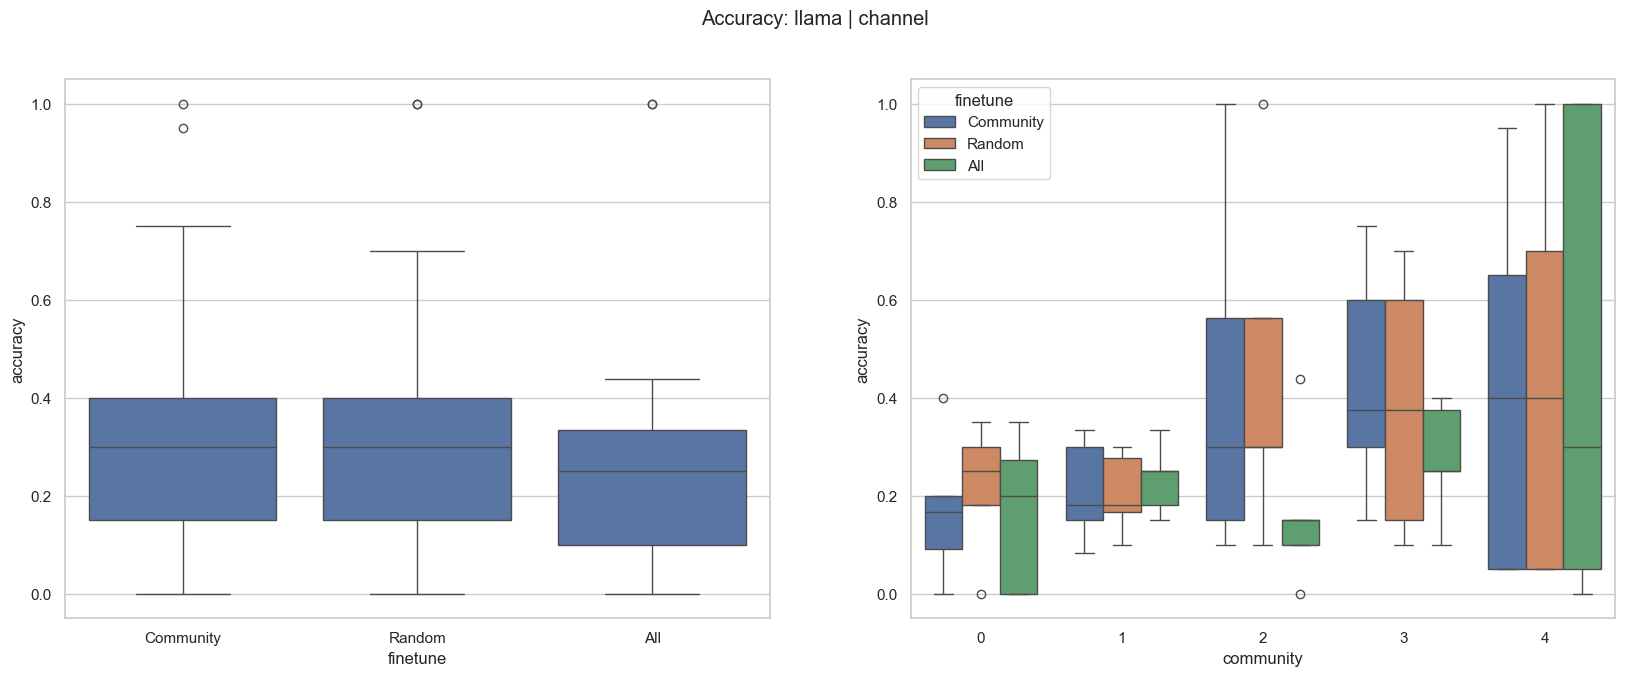

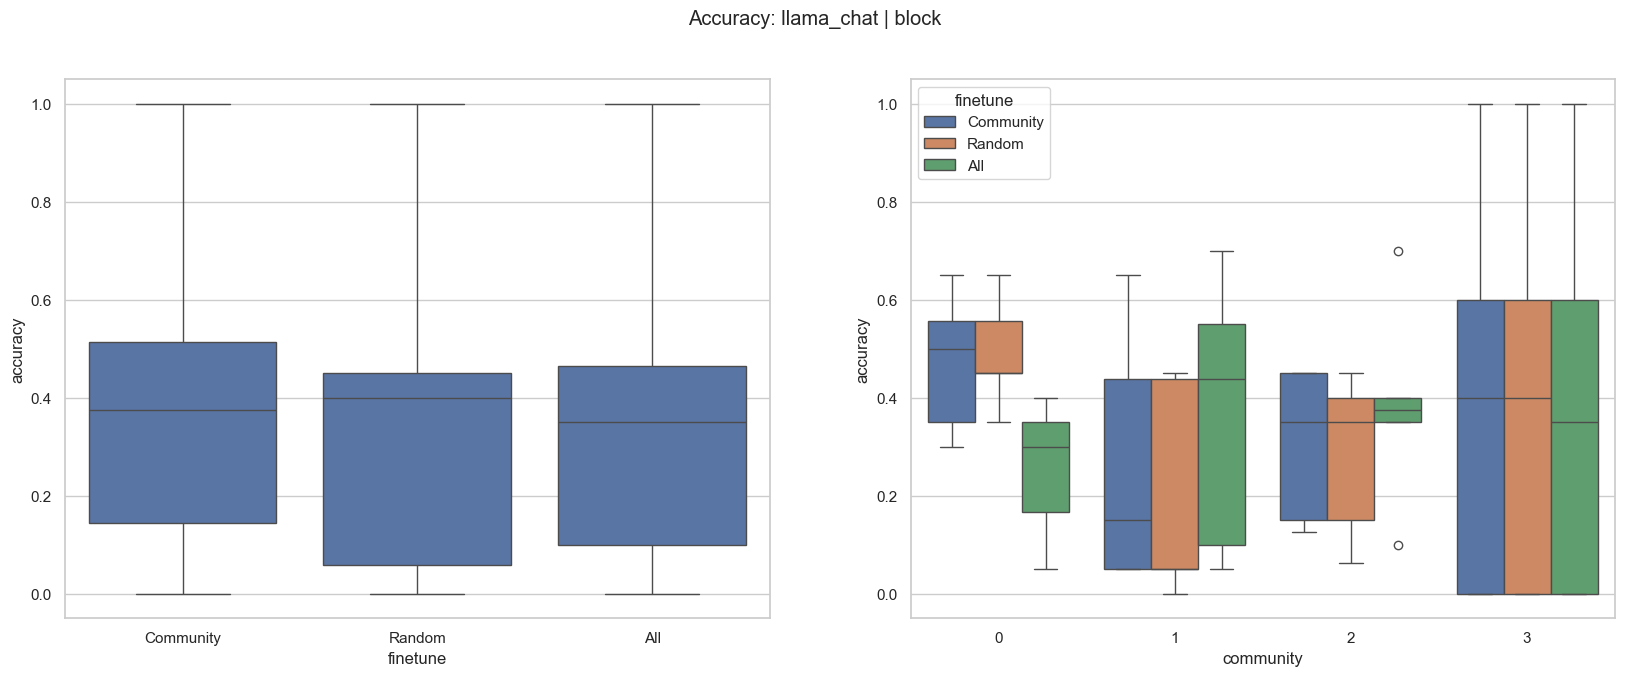

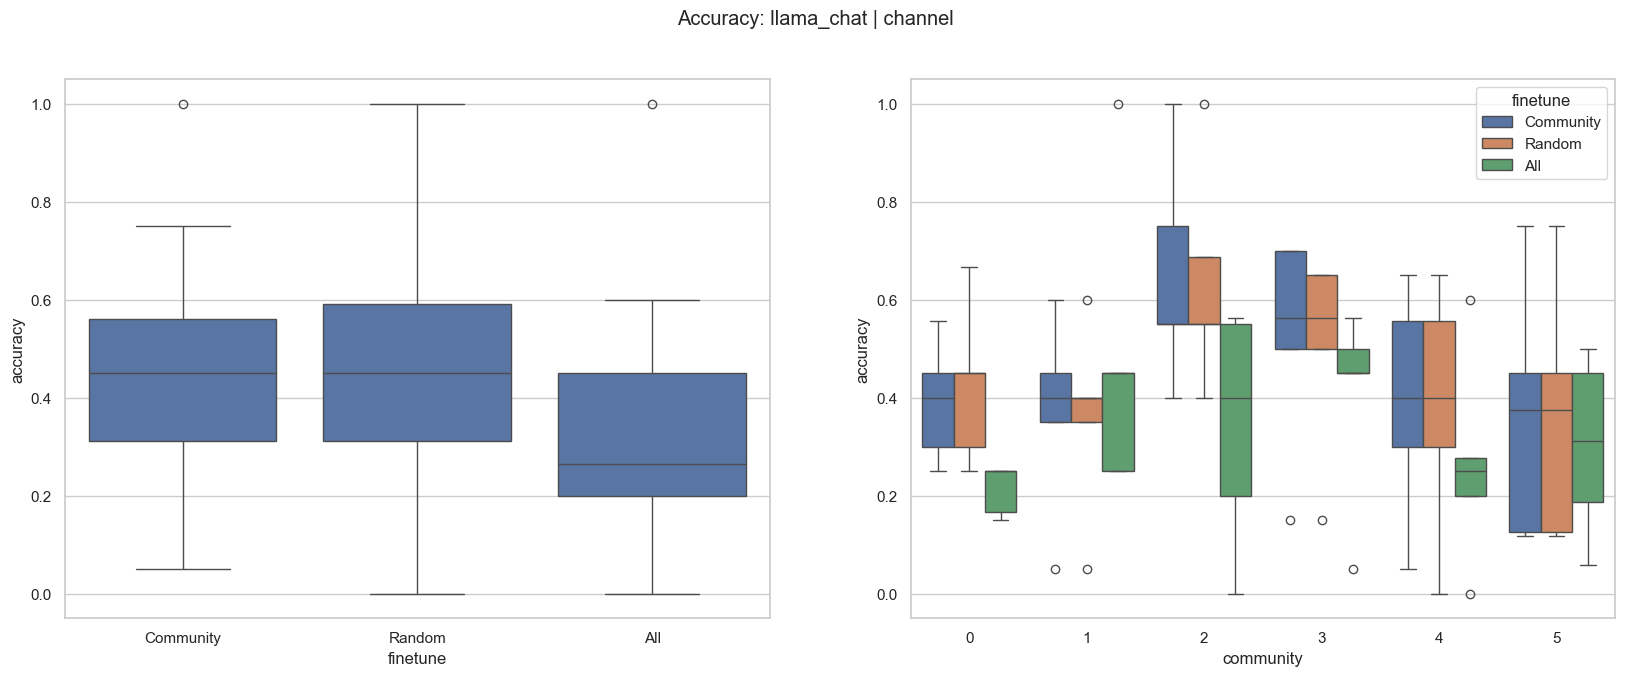

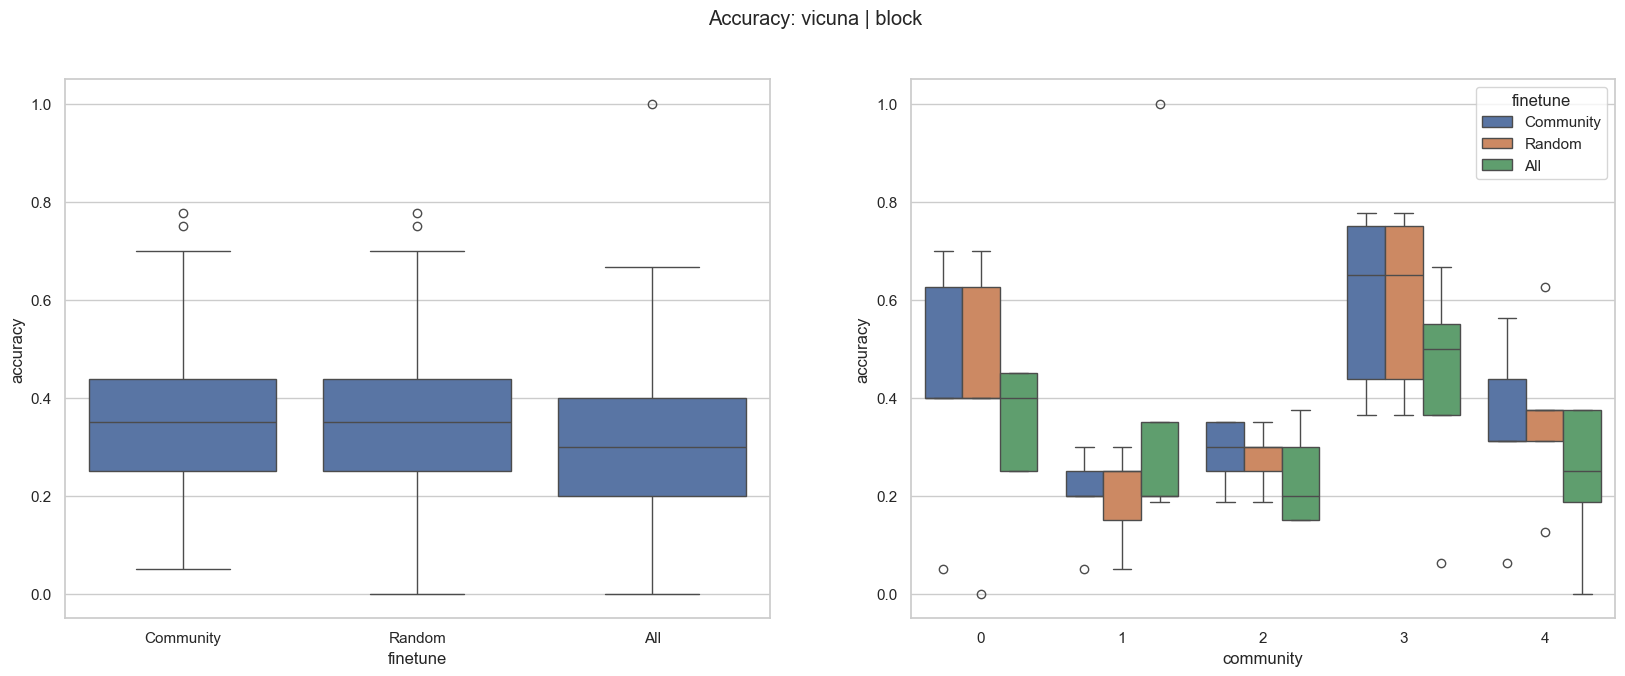

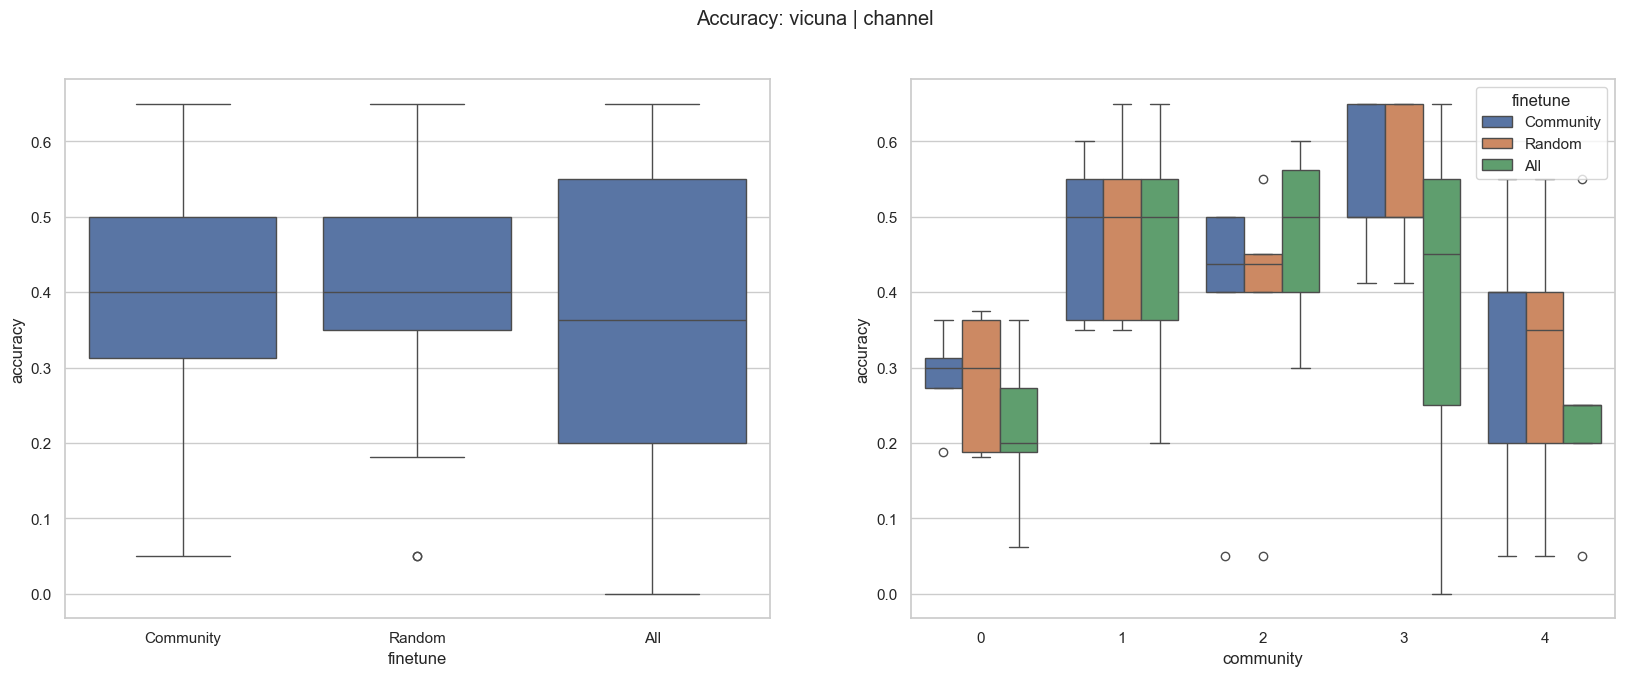

****************************************************************************************************


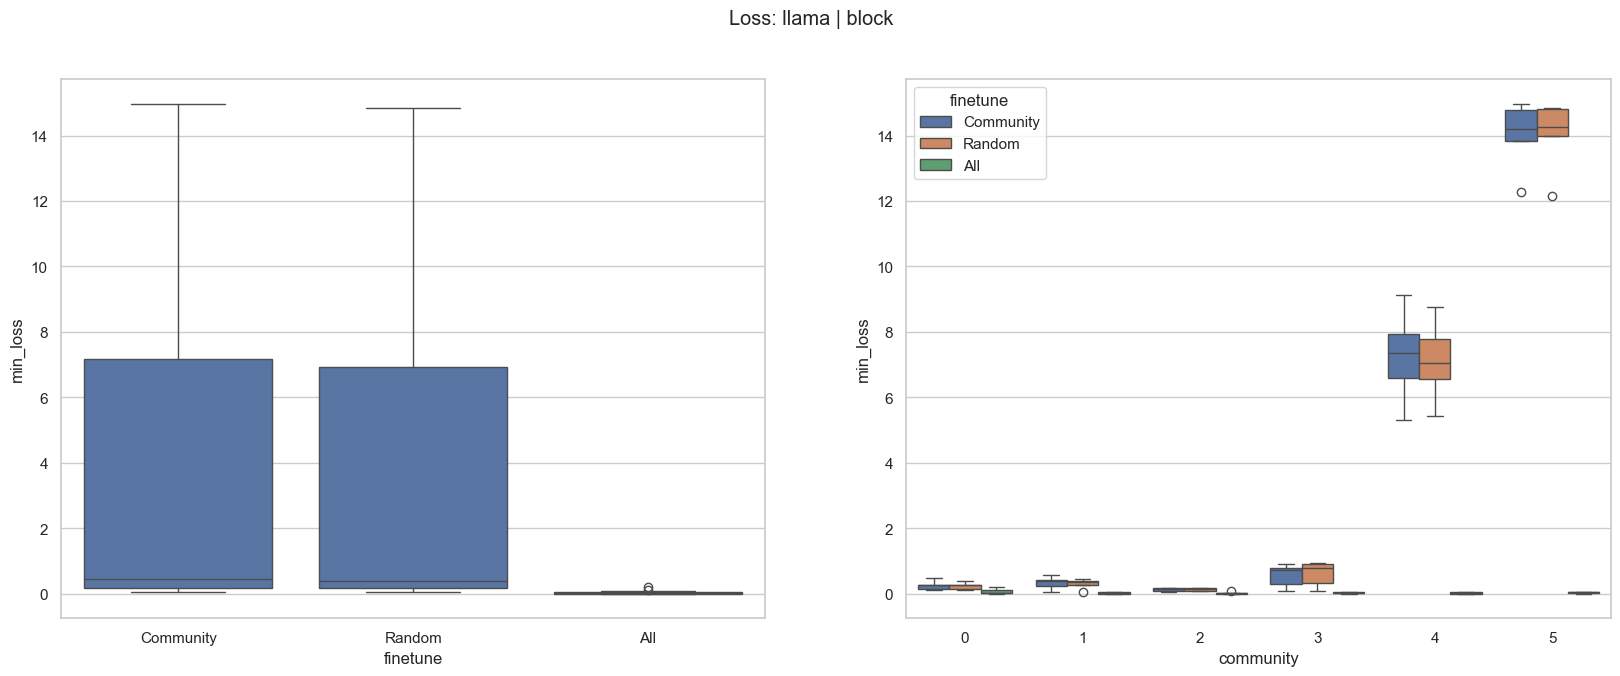

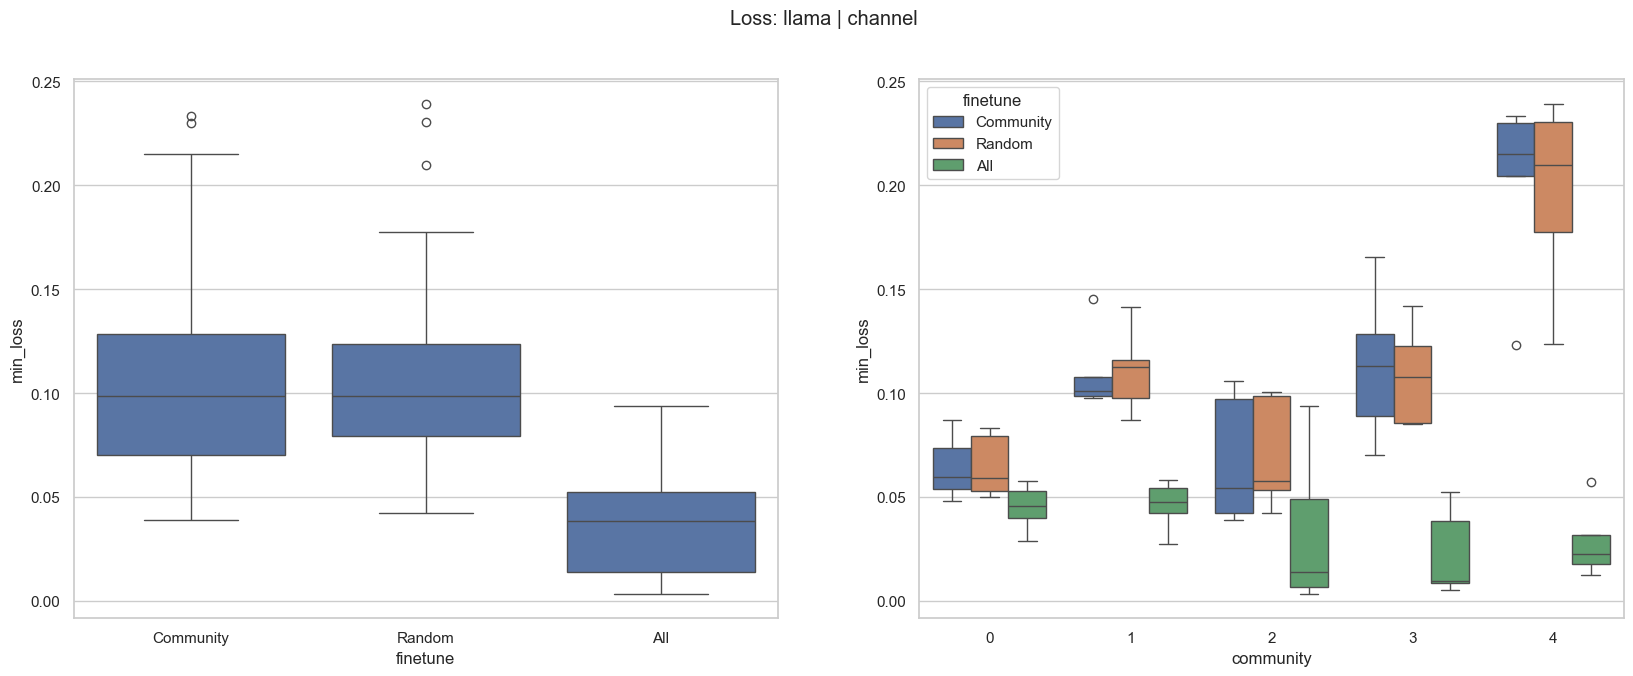

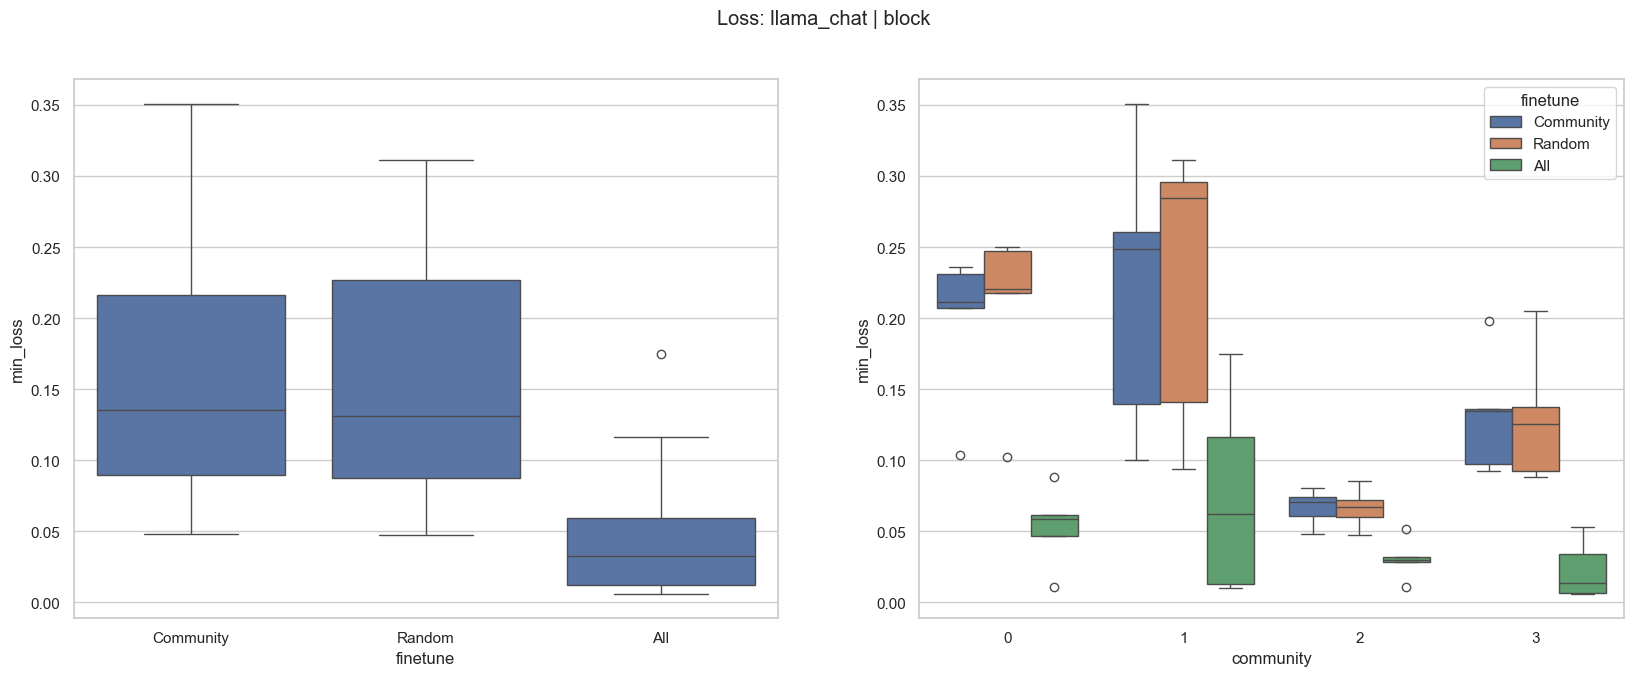

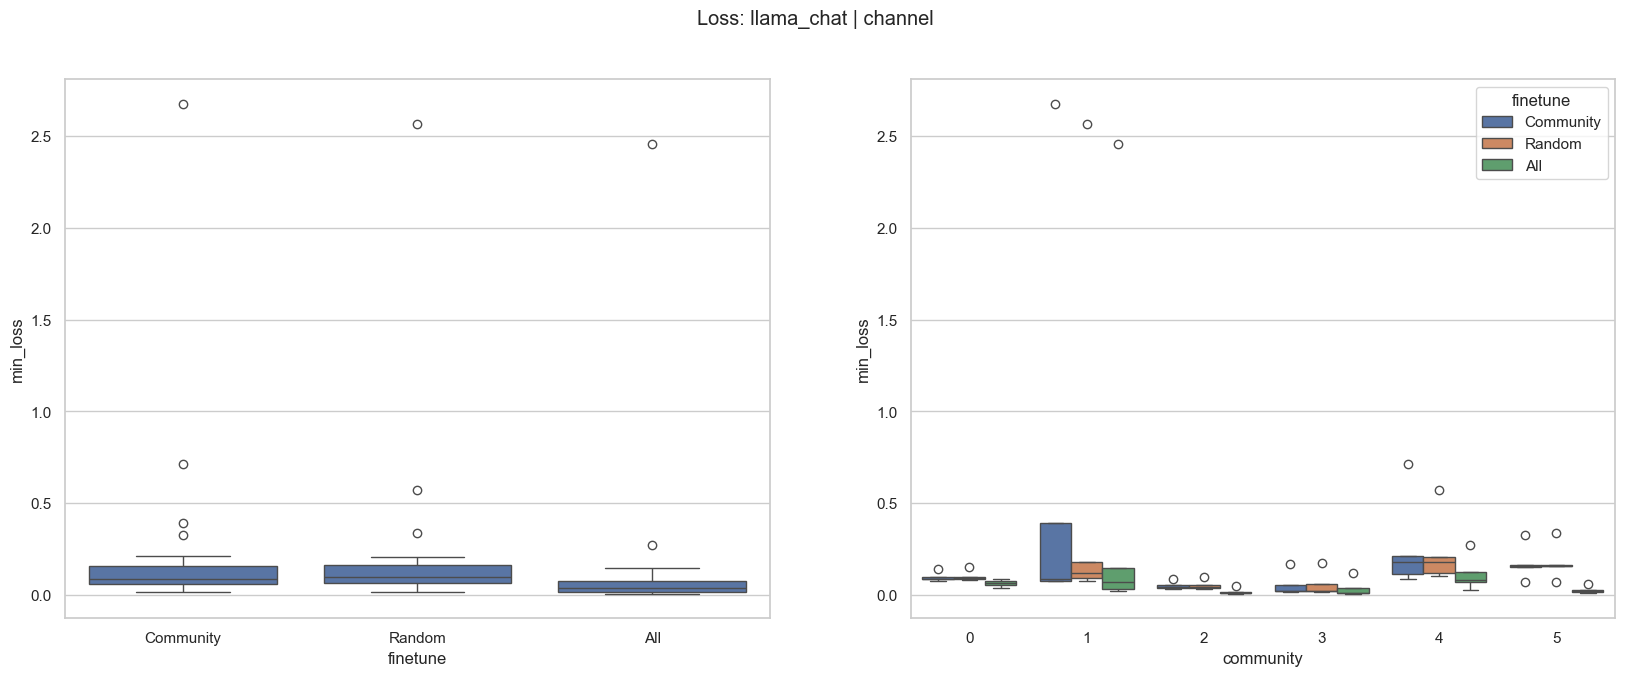

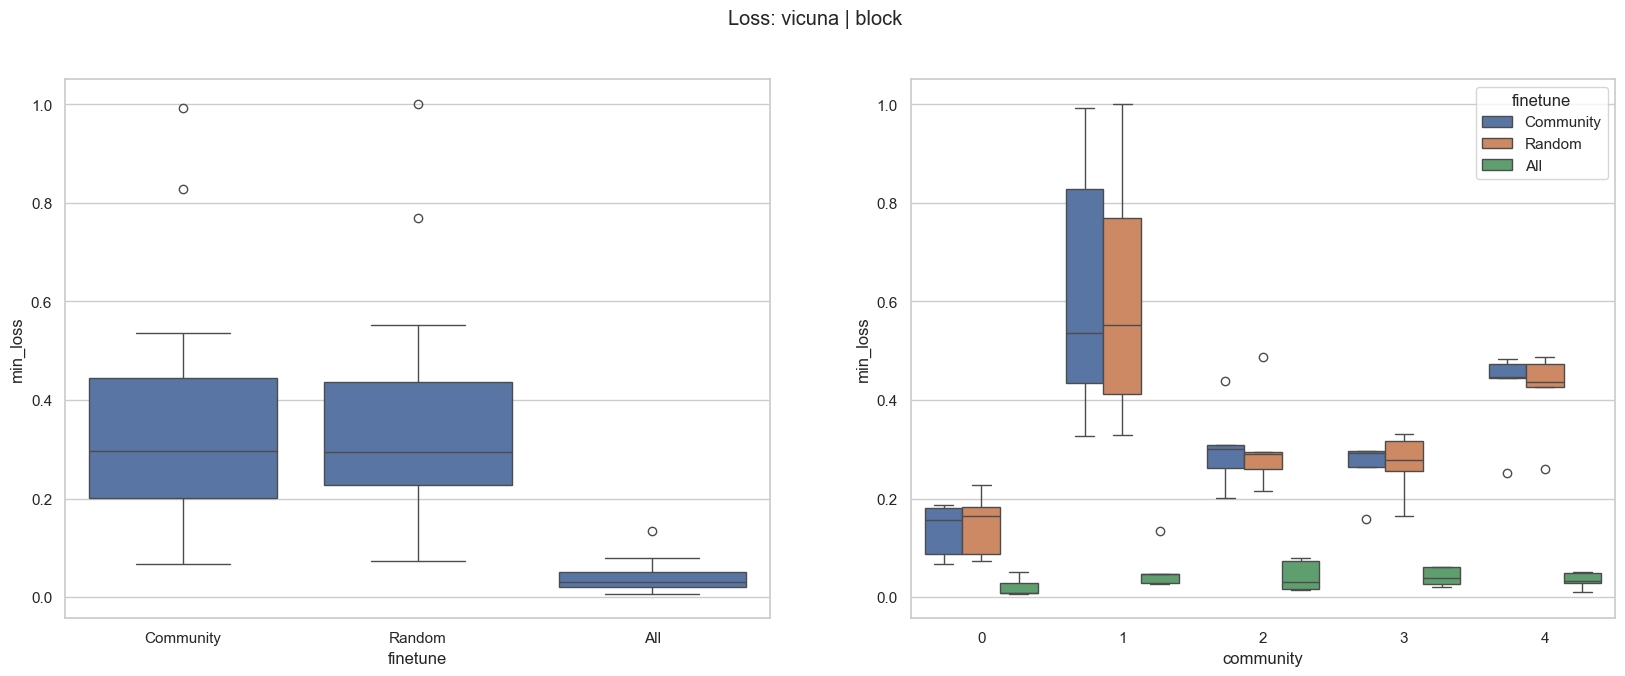

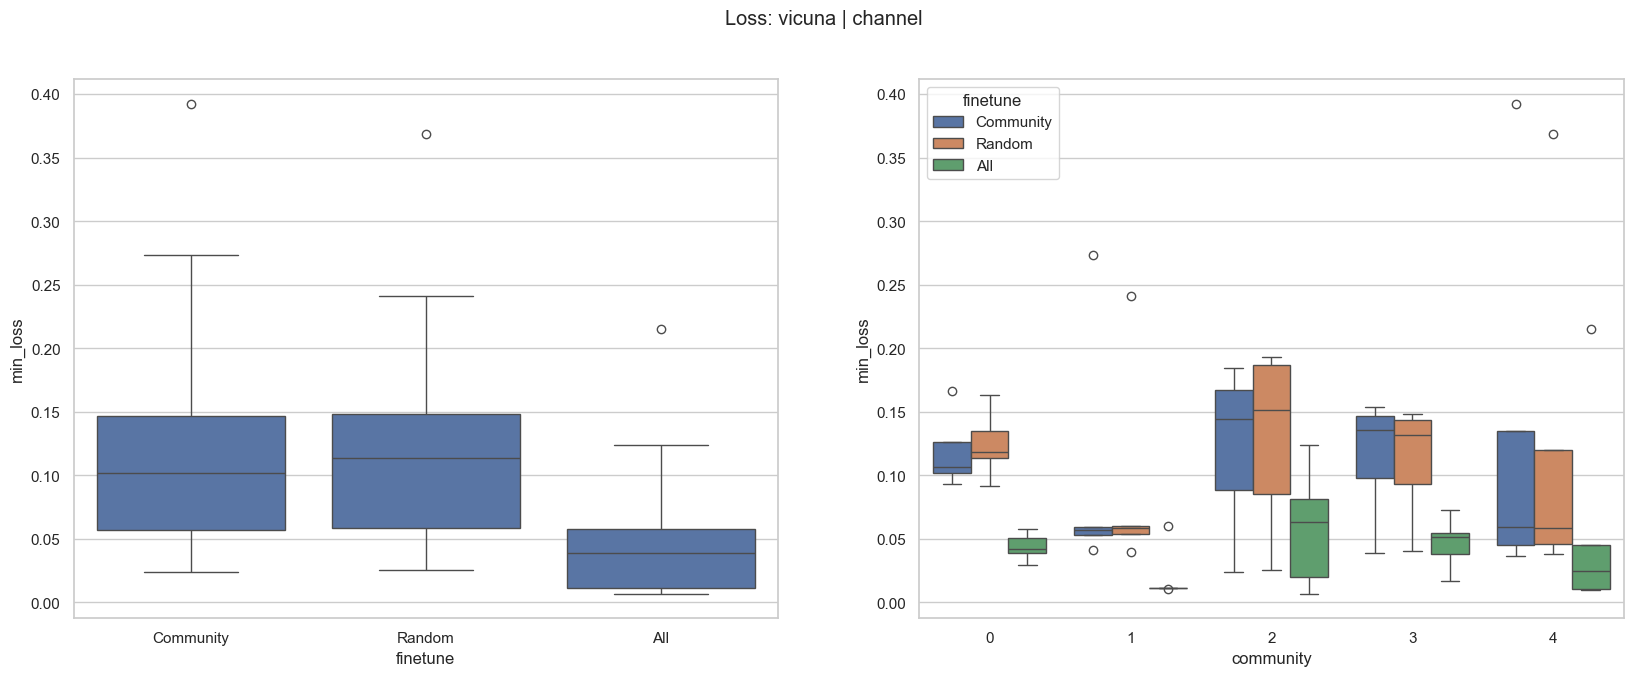

In [14]:
from ast import literal_eval
def fill_nan(df):
    df.dropna()
    #df["finetune"] = df["finetune"].fillna("None")
    #df["rank"] = df["rank"].fillna("None")
    return df
df_2 = pd.read_csv('result/randomize_accuracy/randomize_data_new_kl_2.csv')
df_2["min_loss"] = df_2["loss"].apply(lambda x: [float(xx) for xx in literal_eval(x)][-1])
#df_2["min_loss"] = df_2["min_loss"].apply(lambda x: float(x))
# Group by all columns except for 'accuracy' and 'l2', then calculate the mean for 'accuracy' and 'l2'
finetuned = df_2.groupby(['iteration','model', 'pruning_style', 'community', 'pruning_ratio', 'dataset', 'rank', 'modules', 'modules_size', 'finetune']).agg({'accuracy': 'mean','min_loss':
                                                                                                                                                              'mean'}).reset_index()
#average_accuracy_by_group = finetuned.groupby([ 'model','pruning_style','community','finetune'])['accuracy'].mean().reset_index()

plt.figure(figsize=(10,7))
sns.boxplot(data=finetuned, x="pruning_style",hue="finetune", y="accuracy",hue_order=[ "Community","Random", "All"]) 
plt.title(f"ALL")
plt.show()
plt.figure(figsize=(10,7))
sns.boxplot(data=finetuned, x="pruning_style",hue="finetune", y="min_loss",hue_order=[ "Community","Random", "All"]) 
plt.title(f"ALL")
plt.show()
#average_accuracy_by_group.rename(columns={'accuracy': 'average_accuracy'}, inplace=True)
average_accuracy_by_group =finetuned
'''with pd.option_context('display.max_rows', None,):
    print(average_accuracy_by_group.head(1000))'''
for model in ["llama","llama_chat","vicuna"]:
    for pruning_style in ["block","channel"]:
        filtered_pd = average_accuracy_by_group[(average_accuracy_by_group["model"]==model) & (average_accuracy_by_group["pruning_style"]==pruning_style)]
        fig, [ax0, ax1]= plt.subplots(figsize=(20,7), ncols= 2)
        sns.boxplot(data=filtered_pd, x="finetune", y="accuracy",ax=ax0, order=["Community","Random", "All"]) 
        sns.boxplot(data=filtered_pd, x="community", hue="finetune", y="accuracy",ax=ax1,hue_order=["Community","Random", "All"]) 
        fig.suptitle(f"Accuracy: {model} | {pruning_style}")
        plt.show()
print("*"*100)
for model in ["llama","llama_chat","vicuna"]:
    for pruning_style in ["block","channel"]:
        filtered_pd = average_accuracy_by_group[(average_accuracy_by_group["model"]==model) & (average_accuracy_by_group["pruning_style"]==pruning_style)]
        fig, [ax0, ax1]= plt.subplots(figsize=(20,7), ncols= 2)
        sns.boxplot(data=filtered_pd, x="finetune", y="min_loss",ax=ax0, order=["Community","Random", "All"]) 
        sns.boxplot(data=filtered_pd, x="community", hue="finetune", y="min_loss",ax=ax1,hue_order=["Community","Random", "All"]) 
        fig.suptitle(f"Loss: {model} | {pruning_style}")
        plt.show()

## Analyze the Community Analysis Correlation vs Accuracy and Loss of the Finetune model

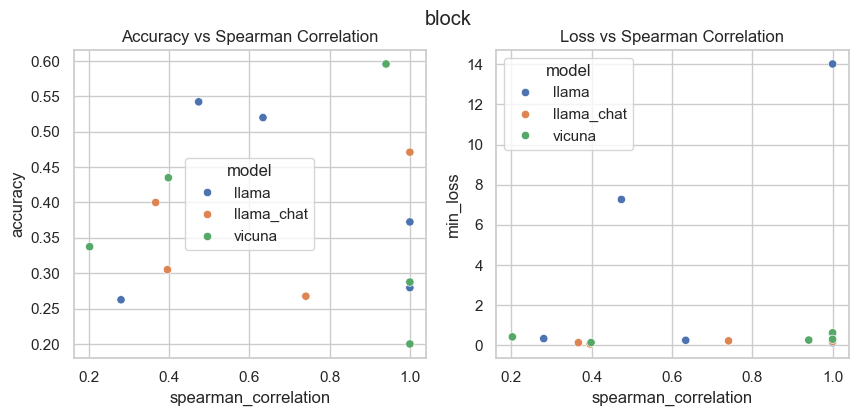

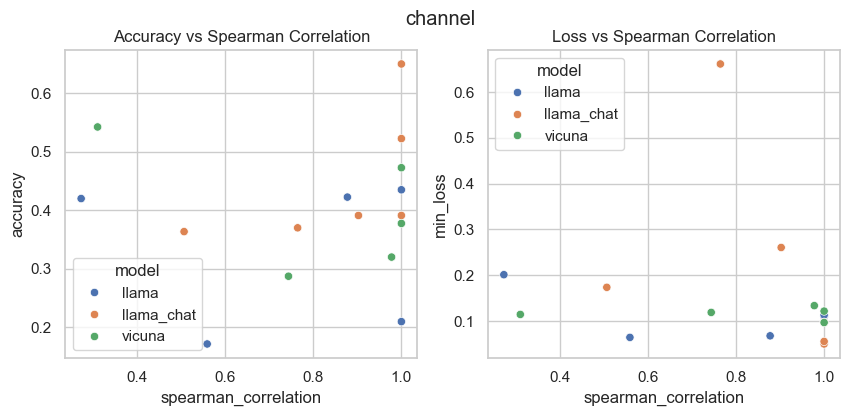

In [28]:
average_accuracy_by_group = finetuned.groupby([ 'model','pruning_style','community','finetune'])['accuracy'].mean().reset_index()
average_loss_by_group = finetuned.groupby([ 'model','pruning_style','community','finetune'])['min_loss'].mean().reset_index()

# Merging the DataFrames on 'model', 'community', and 'pruning_style'/'pruning_strategy'
merged_df = pd.merge(average_accuracy_by_group, data_corr_concat, how='inner', left_on=['model', 'community', 'pruning_style'], right_on=['model', 'community', 'pruning_strategy'])
merged_df_loss = pd.merge(average_loss_by_group, data_corr_concat, how='inner', left_on=['model', 'community', 'pruning_style'], right_on=['model', 'community', 'pruning_strategy'])

# Plotting scatter plot of accuracy vs spearman_correlation
for pruning_style in ["block","channel"]:
        fig, [ax0,ax1] = plt.subplots(figsize=(10,4),ncols=2)
        filtered_pd_acc = merged_df[ (merged_df["pruning_style"]==pruning_style)&(merged_df["finetune"]=="Community")]
        filtered_pd_loss = merged_df_loss[ (merged_df_loss["pruning_style"]==pruning_style)&(merged_df["finetune"]=="Community")]
        sns.scatterplot(data = filtered_pd_loss, y ='min_loss', x = 'spearman_correlation',ax=ax1,hue="model")
        sns.scatterplot(data = filtered_pd_acc, y ='accuracy', x = 'spearman_correlation',ax=ax0,hue="model")
        ax0.set_title(f'Accuracy vs Spearman Correlation')
        ax0.grid(True)
        ax1.set_title(f'Loss vs Spearman Correlation')
        ax1.grid(True)
        fig.suptitle(pruning_style)
        plt.show()


# Analyze the Distribution of the Performance of the Finetuned Model

(2, 'llama', 'block', 20)
Correlation between L2 norm and final loss(All): 0.09762968889958554
Correlation between L2 norm and final loss(Actual): -0.8939119843866393
Correlation between L2 norm and final loss(Random): -0.8932080490537434
T-test for accuracy difference between actual and Randoms: t-stat=0.35236874634997123, p-value=0.7258389541510843
Spearman correlation between loss and accuracy (All): 0.13633889819614986
Spearman correlation between loss and accuracy (Actual): 0.3702224408802358
Spearman correlation between loss and accuracy (Random): 0.4095370400322619


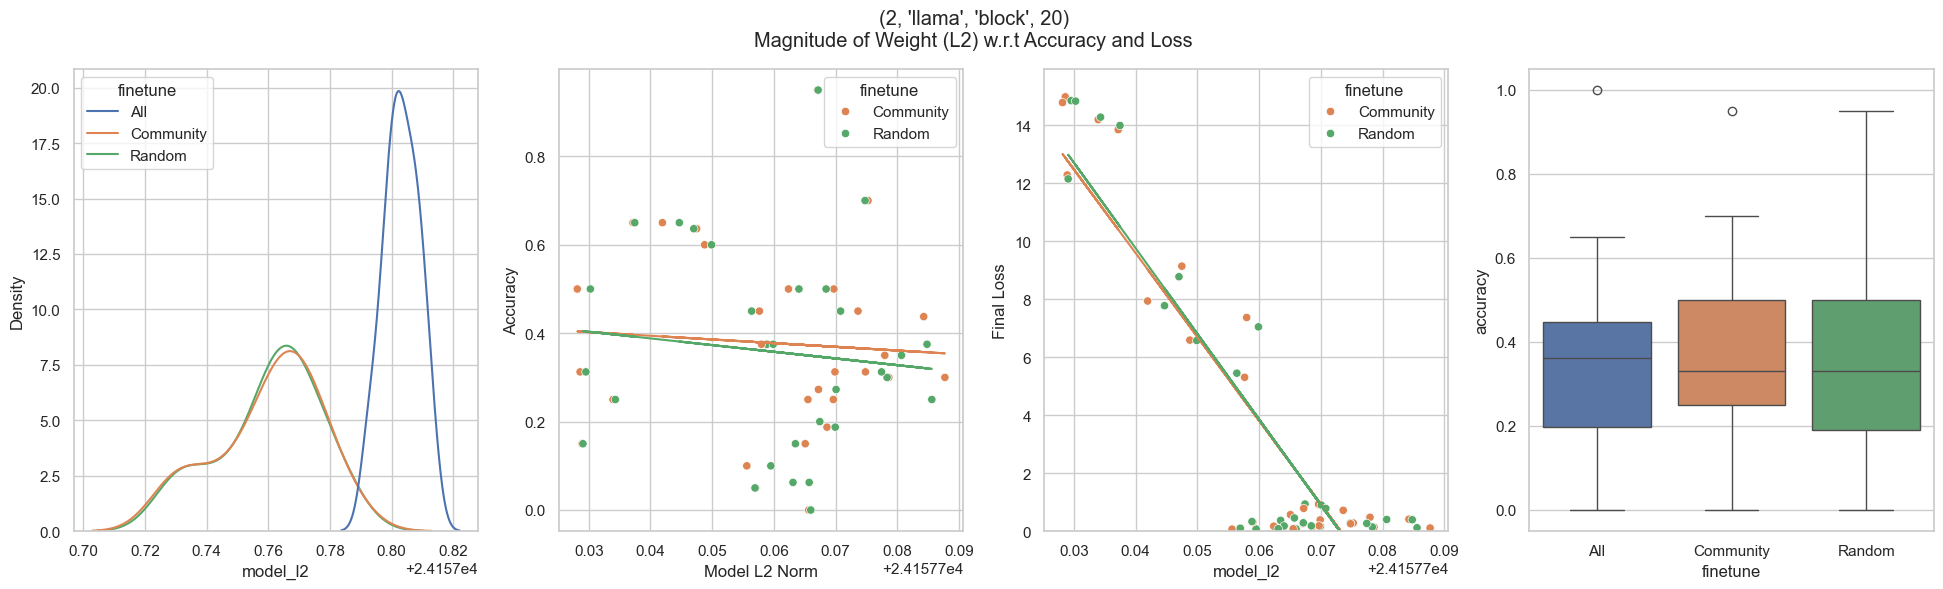

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2, 'llama', 'channel', 20)
Correlation between L2 norm and final loss(All): 0.24191859401129287
Correlation between L2 norm and final loss(Actual): -0.5203037465820834
Correlation between L2 norm and final loss(Random): -0.508503475919541
T-test for accuracy difference between actual and Randoms: t-stat=-0.10295275452738745, p-value=0.9184293960549564
Spearman correlation between loss and accuracy (All): -0.12872215095435294
Spearman correlation between loss and accuracy (Actual): -0.047398931

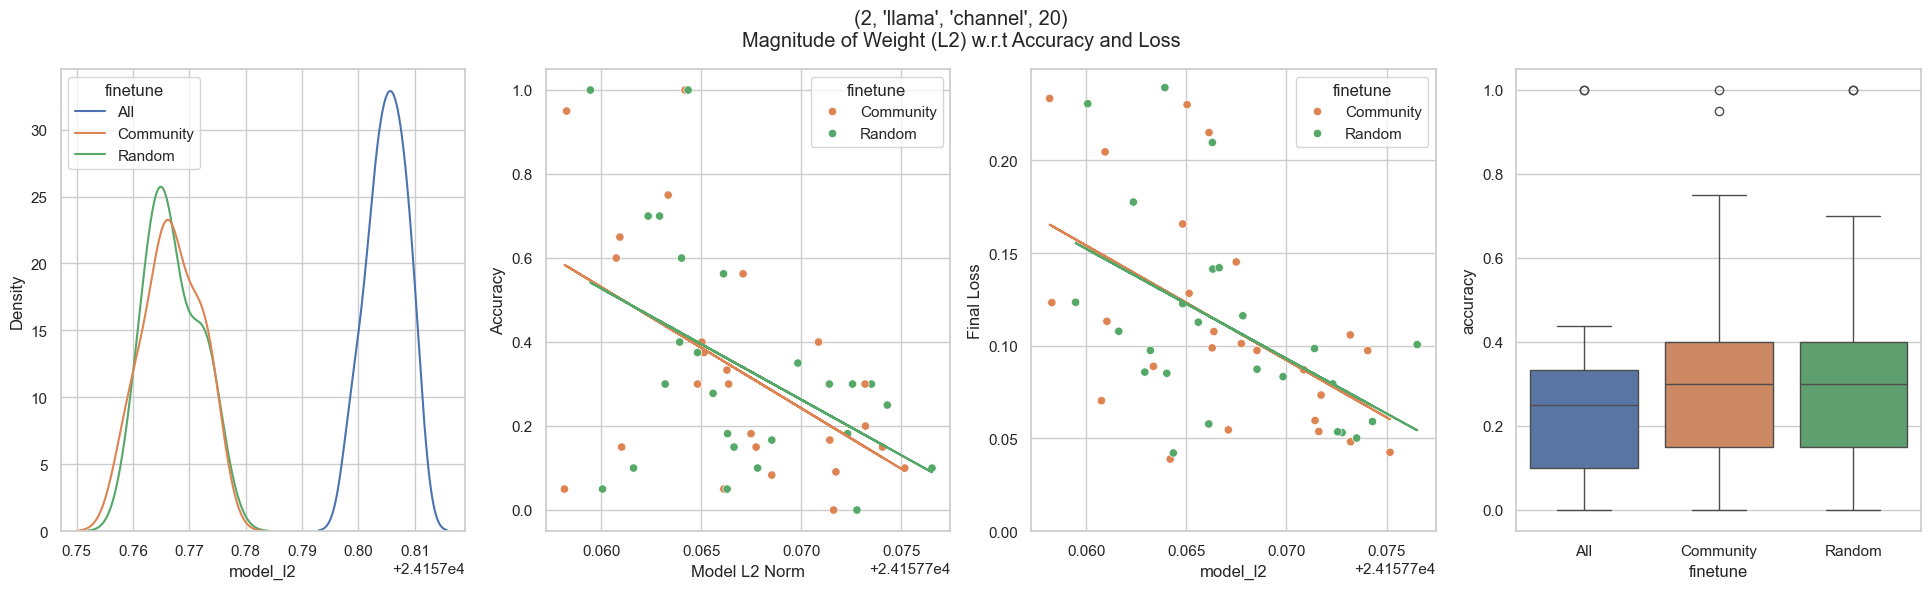

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2, 'llama_chat', 'block', 20)
Correlation between L2 norm and final loss(All): 0.14683032747412617
Correlation between L2 norm and final loss(Actual): -0.5906588790873952
Correlation between L2 norm and final loss(Random): -0.6309452740130557
T-test for accuracy difference between actual and Randoms: t-stat=0.21685217464364695, p-value=0.8294836087879852
Spearman correlation between loss and accuracy (All): -0.07997028356463376
Spearman correlation between loss and accuracy (Actual): -0.028636

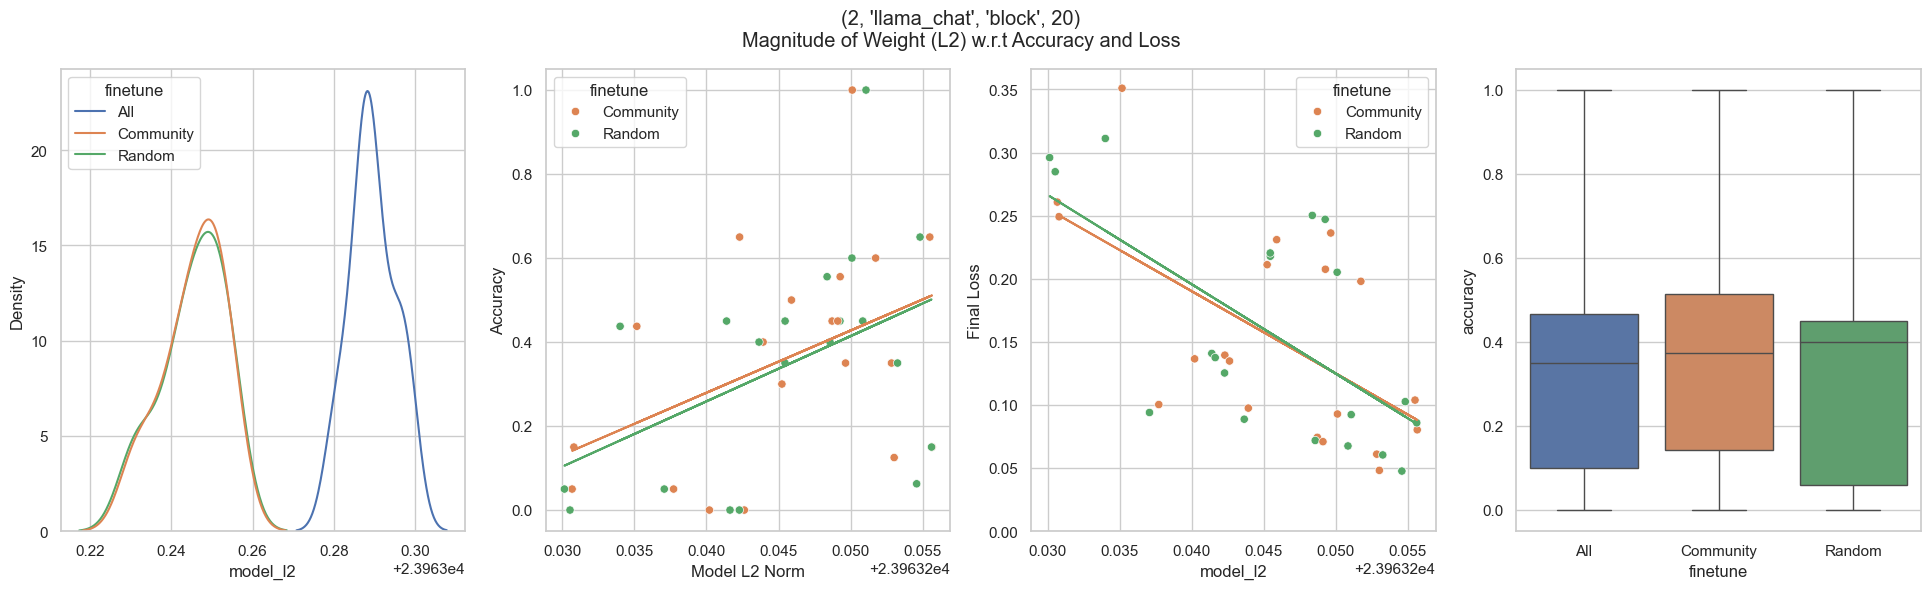

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2, 'llama_chat', 'channel', 20)
Correlation between L2 norm and final loss(All): -0.1498334999686742
Correlation between L2 norm and final loss(Actual): -0.27513499035328837
Correlation between L2 norm and final loss(Random): -0.26615179607472267
T-test for accuracy difference between actual and Randoms: t-stat=0.05826592950486905, p-value=0.9537370878651046
Spearman correlation between loss and accuracy (All): -0.17019742122321602
Spearman correlation between loss and accuracy (Actual): -0.59

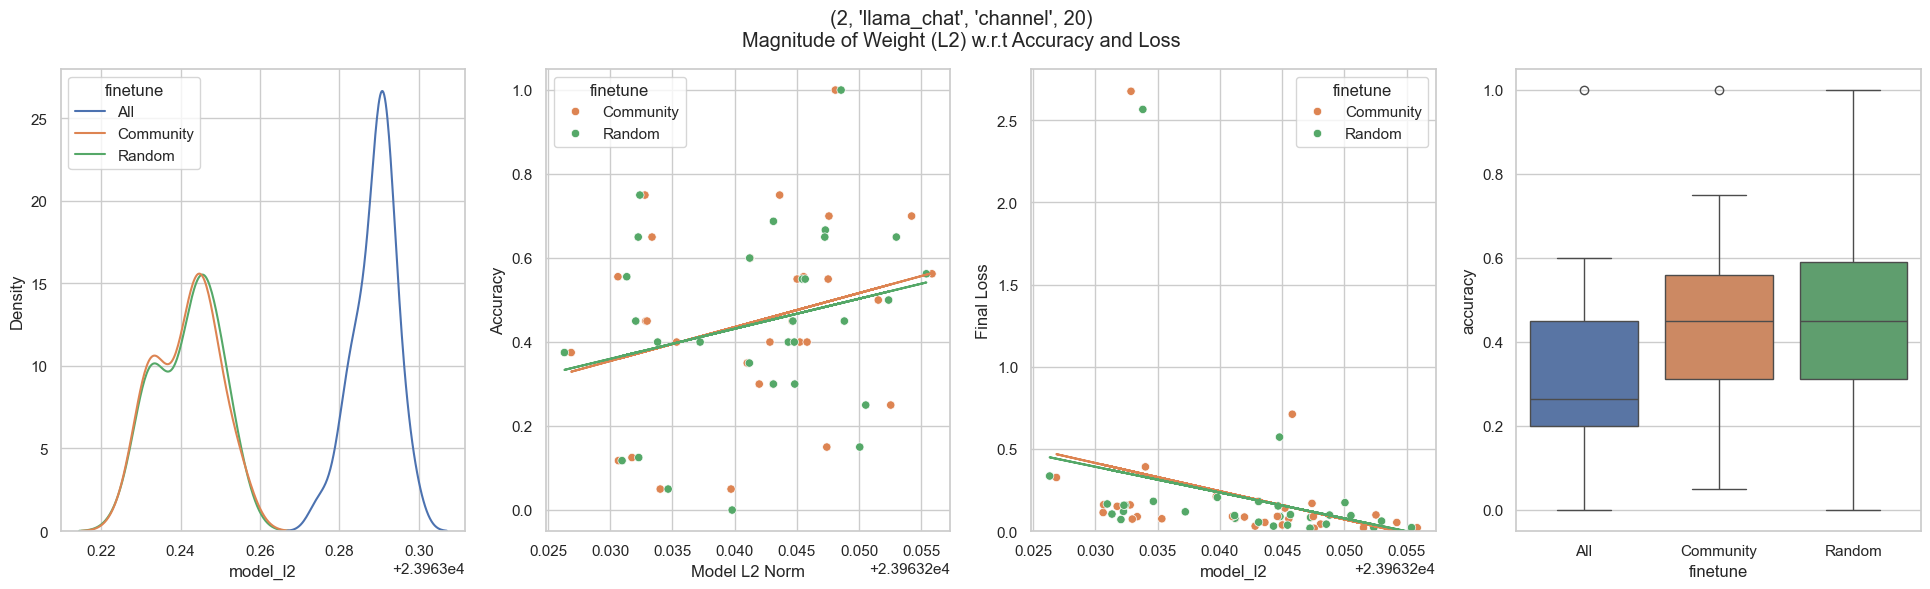

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2, 'vicuna', 'block', 20)
Correlation between L2 norm and final loss(All): 0.5605849227367536
Correlation between L2 norm and final loss(Actual): -0.5609326331594723
Correlation between L2 norm and final loss(Random): -0.5788680541663124
T-test for accuracy difference between actual and Randoms: t-stat=-0.01680549954202066, p-value=0.9866614434940504
Spearman correlation between loss and accuracy (All): 0.20366526884783495
Spearman correlation between loss and accuracy (Actual): -0.38790492888

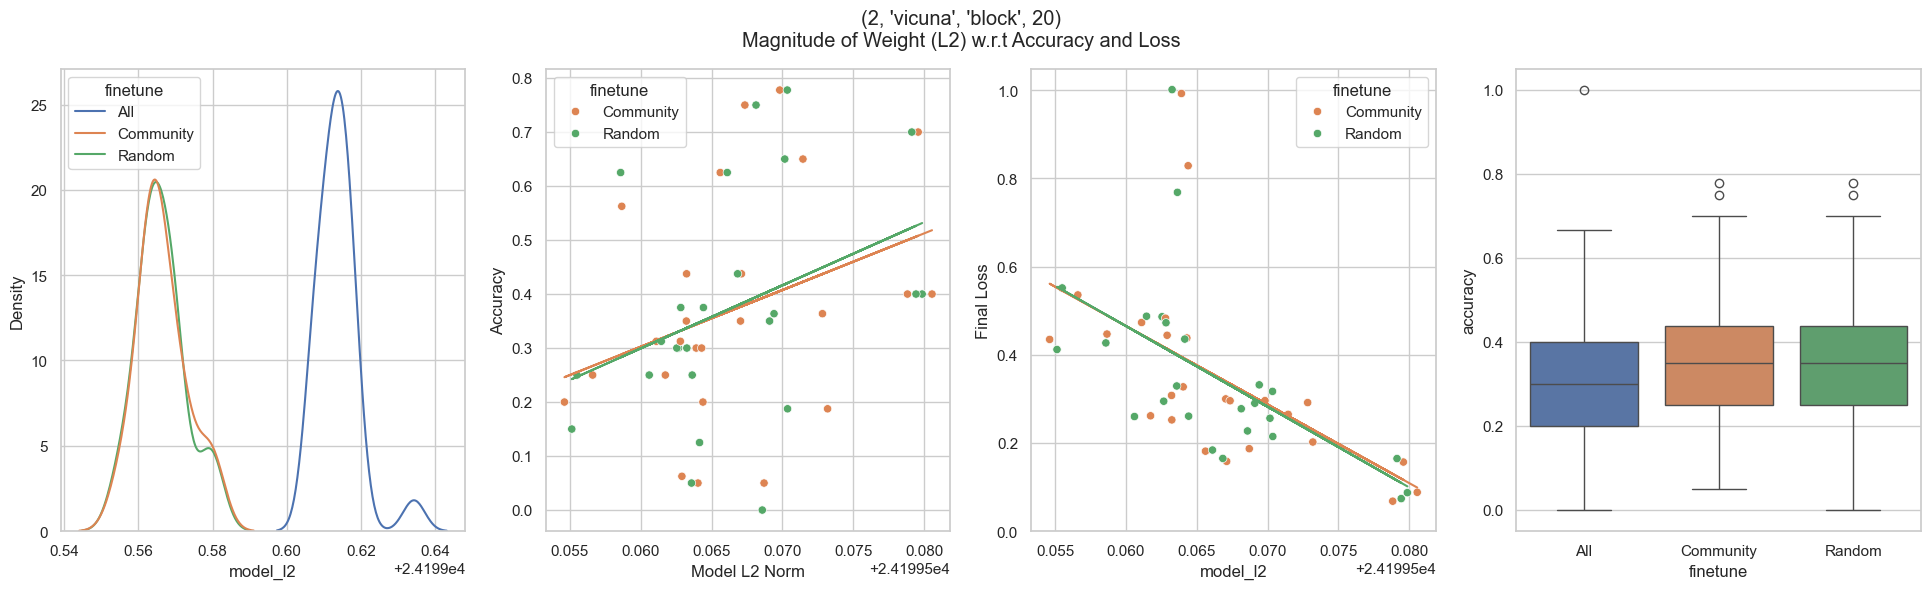

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(2, 'vicuna', 'channel', 20)
Correlation between L2 norm and final loss(All): 0.019556475203558153
Correlation between L2 norm and final loss(Actual): -0.041226993229891665
Correlation between L2 norm and final loss(Random): -0.027279165960247837
T-test for accuracy difference between actual and Randoms: t-stat=0.024266543352153655, p-value=0.980740603124751
Spearman correlation between loss and accuracy (All): -0.13153381946422674
Spearman correlation between loss and accuracy (Actual): -0.268

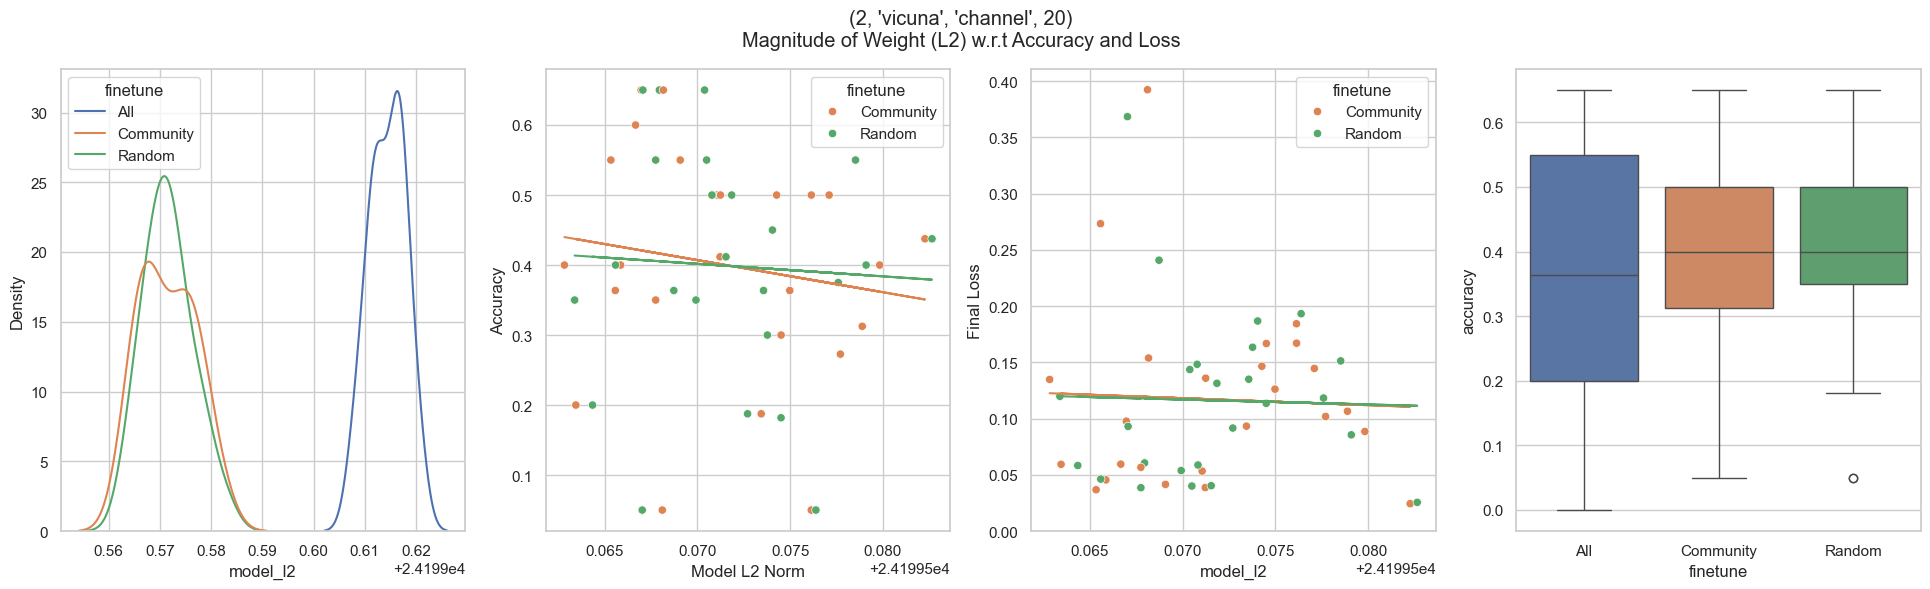

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [33]:
from scipy.stats import ttest_ind, pearsonr, spearmanr
grouped = df_2.groupby(['iteration', 'model', 'pruning_style', 'pruning_ratio'])
for group_name, grouped_df in grouped:
    print(group_name)
    all_df = grouped_df[grouped_df['finetune'] == 'All']  # Replace 'modules' with actual label if different
    actual_df = grouped_df[grouped_df['finetune'] == 'Community']  # Replace 'modules' with actual label if different
    random_df = grouped_df[grouped_df['finetune'] == 'Random']  # Replace 'modules' with random label if different

    
    '''# Compare model L2 norm distributions
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data = grouped_df, x='model_l2', hue="finetune", palette=["C0", "C1", "C2"]) 
    plt.title(f'Model L2 Norm Distribution | {group_name}')
    plt.xlabel('L2 Norm')
    plt.ylabel('Density')
    plt.show()'''

    # Correlation between L2 norm and final loss per epoch
    all_l2_loss_corr, _ = pearsonr(all_df['model_l2'].tolist()[0], all_df['min_loss'].tolist()[0])
    actual_l2_loss_corr, _ = pearsonr(actual_df['model_l2'].tolist()[0], actual_df['min_loss'].tolist()[0])
    random_l2_loss_corr, _ = pearsonr(random_df['model_l2'].tolist()[0], random_df['min_loss'].tolist()[0])
    print(f'Correlation between L2 norm and final loss(All): {all_l2_loss_corr}')
    print(f'Correlation between L2 norm and final loss(Actual): {actual_l2_loss_corr}')
    print(f'Correlation between L2 norm and final loss(Random): {random_l2_loss_corr}')

    # T-test on accuracy between actual and Randoms
    t_stat, p_val = ttest_ind(actual_df['accuracy'], random_df['accuracy'])
    print(f'T-test for accuracy difference between actual and Randoms: t-stat={t_stat}, p-value={p_val}')



    # Loss and accuracy correlation
    all_loss_accuracy_corr, _ = spearmanr(all_df['min_loss'], all_df['accuracy'])
    actual_loss_accuracy_corr, _ = spearmanr(actual_df['min_loss'], actual_df['accuracy'])
    random_loss_accuracy_corr, _ = spearmanr(random_df['min_loss'], random_df['accuracy'])
    print(f'Spearman correlation between loss and accuracy (All): {all_loss_accuracy_corr}')
    print(f'Spearman correlation between loss and accuracy (Actual): {actual_loss_accuracy_corr}')
    print(f'Spearman correlation between loss and accuracy (Random): {random_loss_accuracy_corr}')
    
    fig, [axx,ax0,ax1,axll] = plt.subplots(figsize=(24, 6),ncols=4)

    # Scatter plot with hue for different modules
    #sns.scatterplot(data=grouped_df, x='model_l2', y='accuracy', hue='finetune')
    sns.kdeplot(data = grouped_df, x='model_l2', hue="finetune", palette=["C0", "C1", "C2"],ax=axx) 
    sns.boxplot(data=grouped_df, x='finetune', y='accuracy', palette=["C0", "C1", "C2"],ax=axll)

    sns.scatterplot(data=grouped_df[grouped_df["finetune"]!="All"], x='model_l2', y='accuracy', hue='finetune', palette=["C1", "C2"],ax=ax0)
    sns.scatterplot(data=grouped_df[grouped_df["finetune"]!="All"], x='model_l2', y='min_loss', hue='finetune', palette=["C1", "C2"],ax=ax1)

    # Fit and plot a line of best fit for each module subset
    #for finetune, subset in [("All",all_df,"C0"),("Community",actual_df,"C1" ),("Random", random_df,"C2")]:
    for finetune, subset, color in [("Community",actual_df,"C1" ),("Random", random_df,"C2")]:
        slope, intercept = np.polyfit(subset['model_l2'], subset['accuracy'], 1)
        ax0.plot(subset['model_l2'], slope * subset["model_l2"] + intercept, color=color)
        slope, intercept = np.polyfit(subset['model_l2'], subset['min_loss'], 1)
        ax1.plot(subset['model_l2'], slope * subset["model_l2"] + intercept, color=color)
        ax1.set_ylim(ymin=0)
    # Add labels and title
    ax0.set_xlabel('Model L2 Norm')
    ax0.set_ylabel('Accuracy')
    ax1.set_ylabel('Final Loss')
    fig.suptitle(f'{group_name}\nMagnitude of Weight (L2) w.r.t Accuracy and Loss')
    plt.show()

    print("+"*500)


# Compare community and skill distribution

<Figure size 640x480 with 0 Axes>

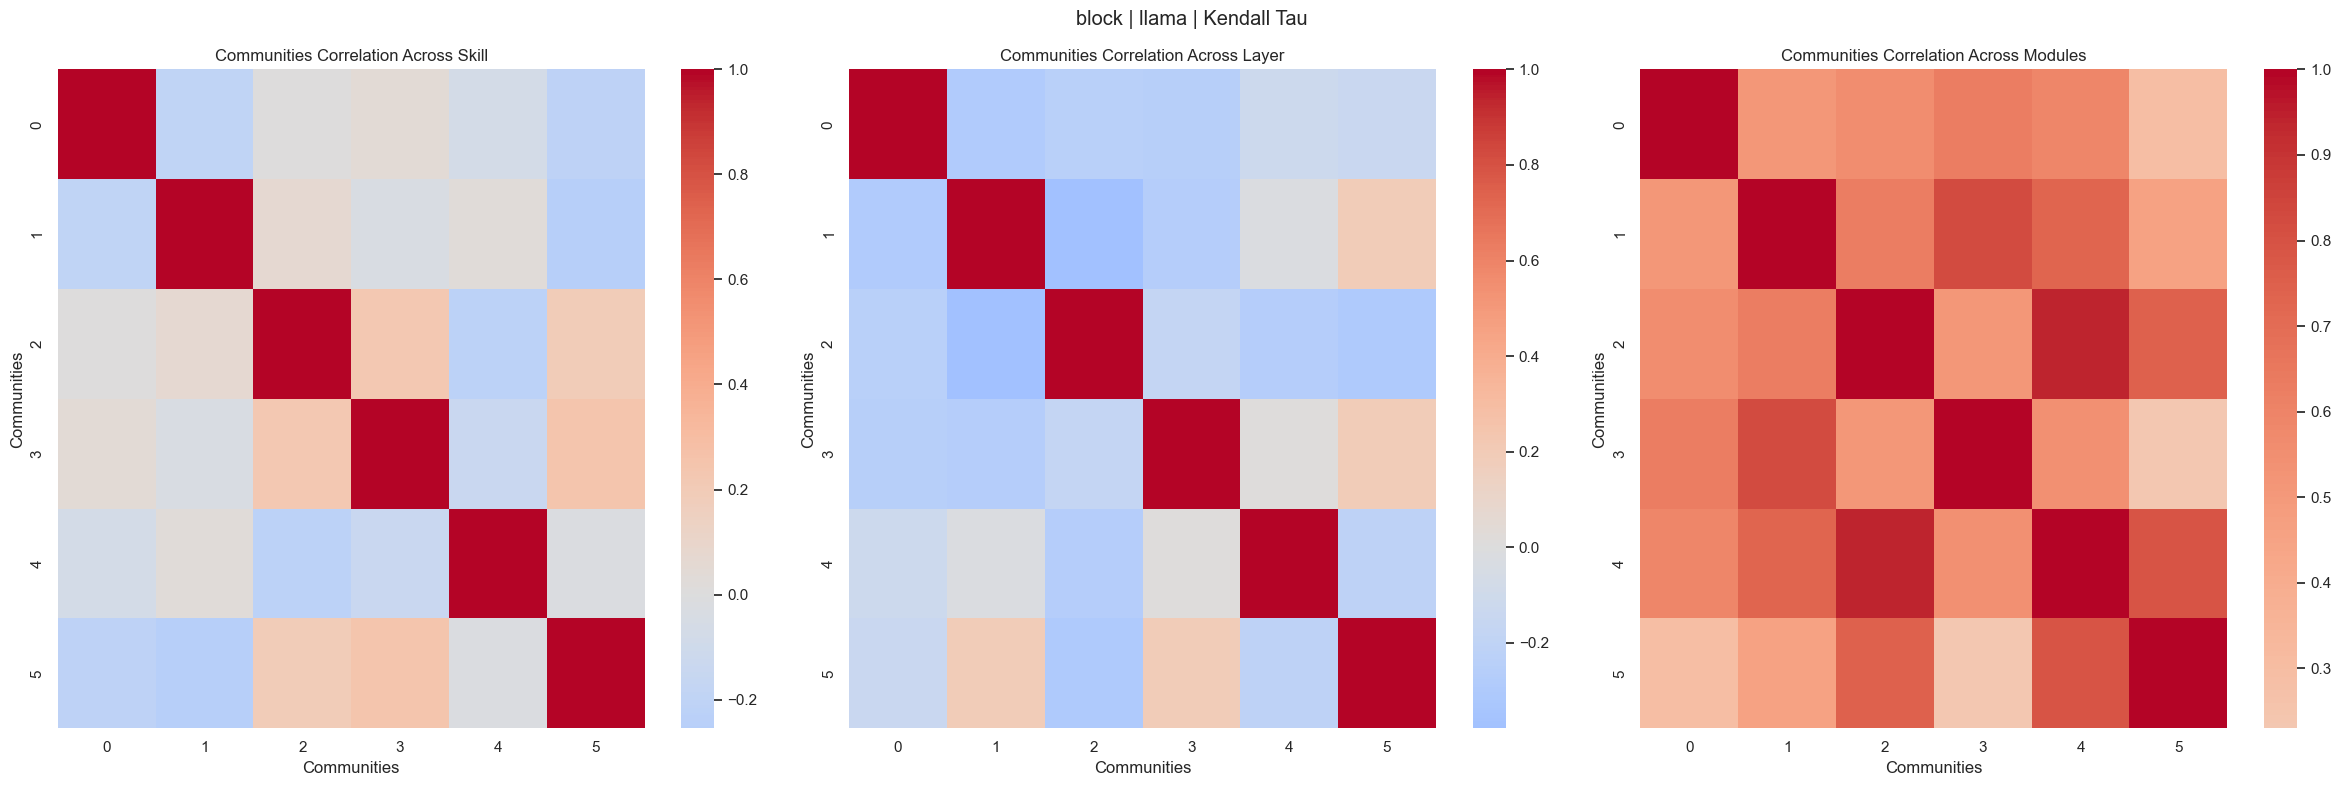

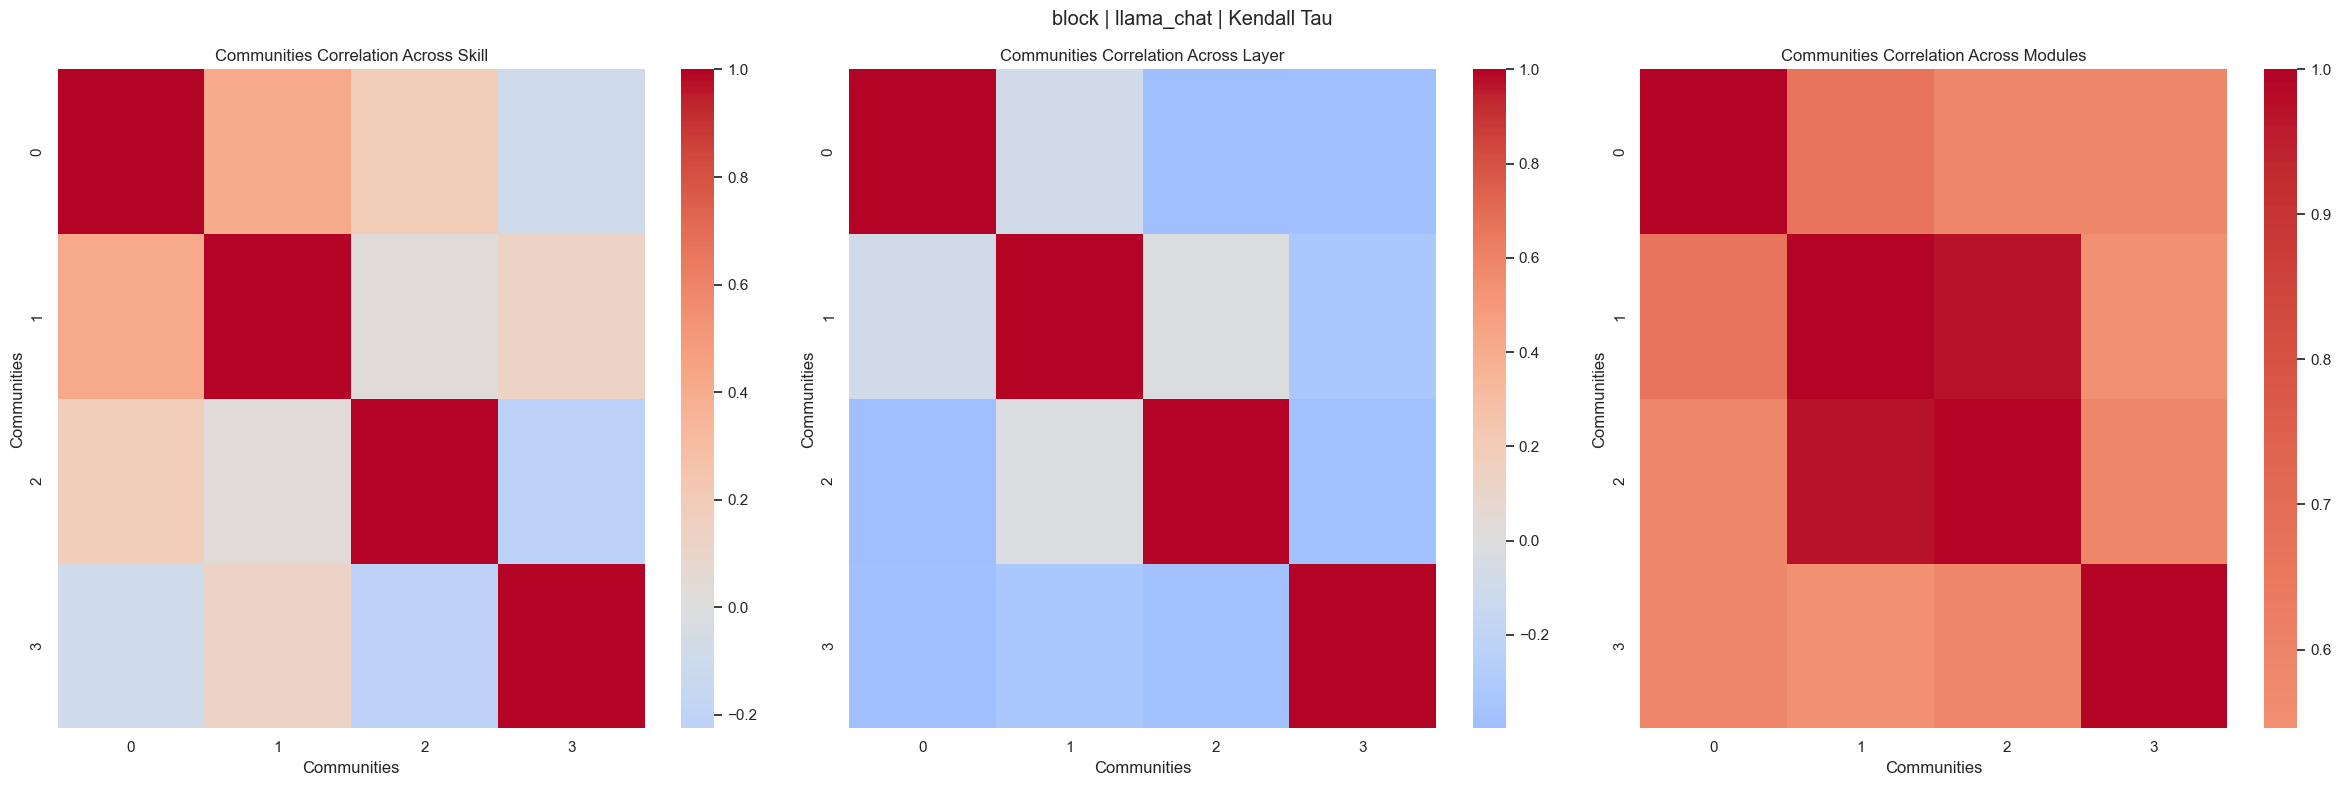

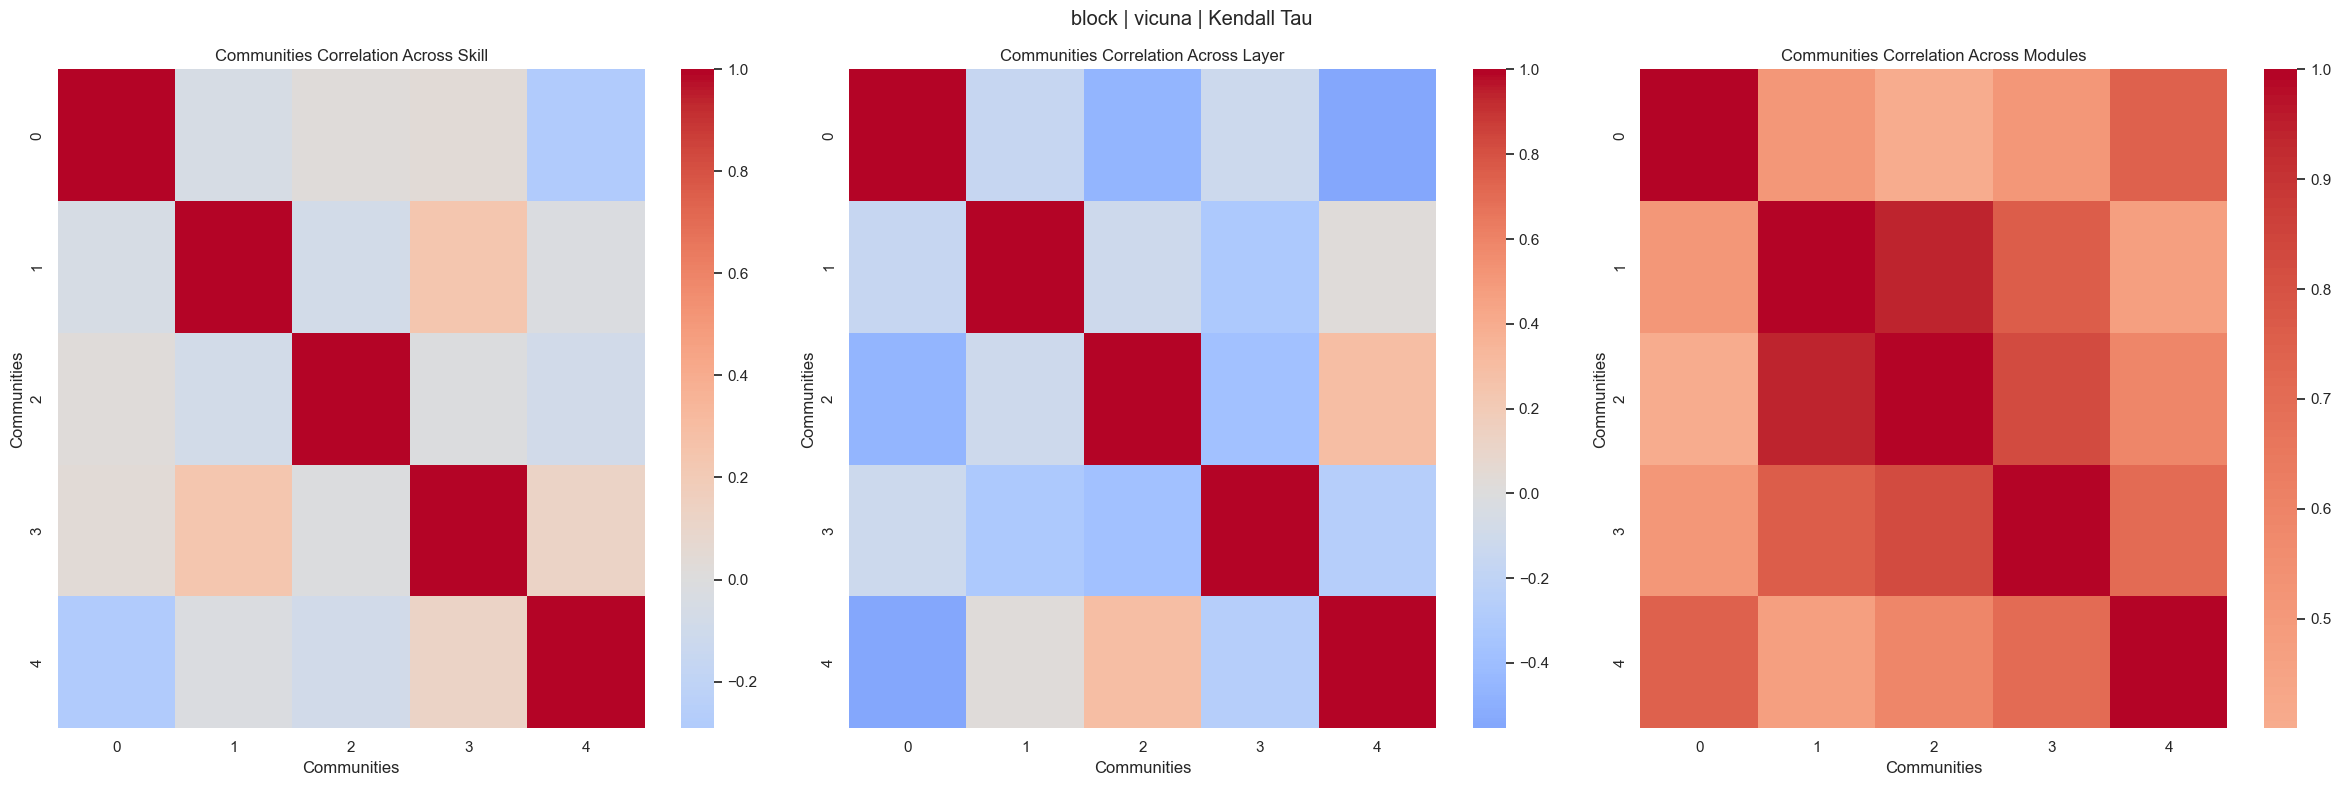

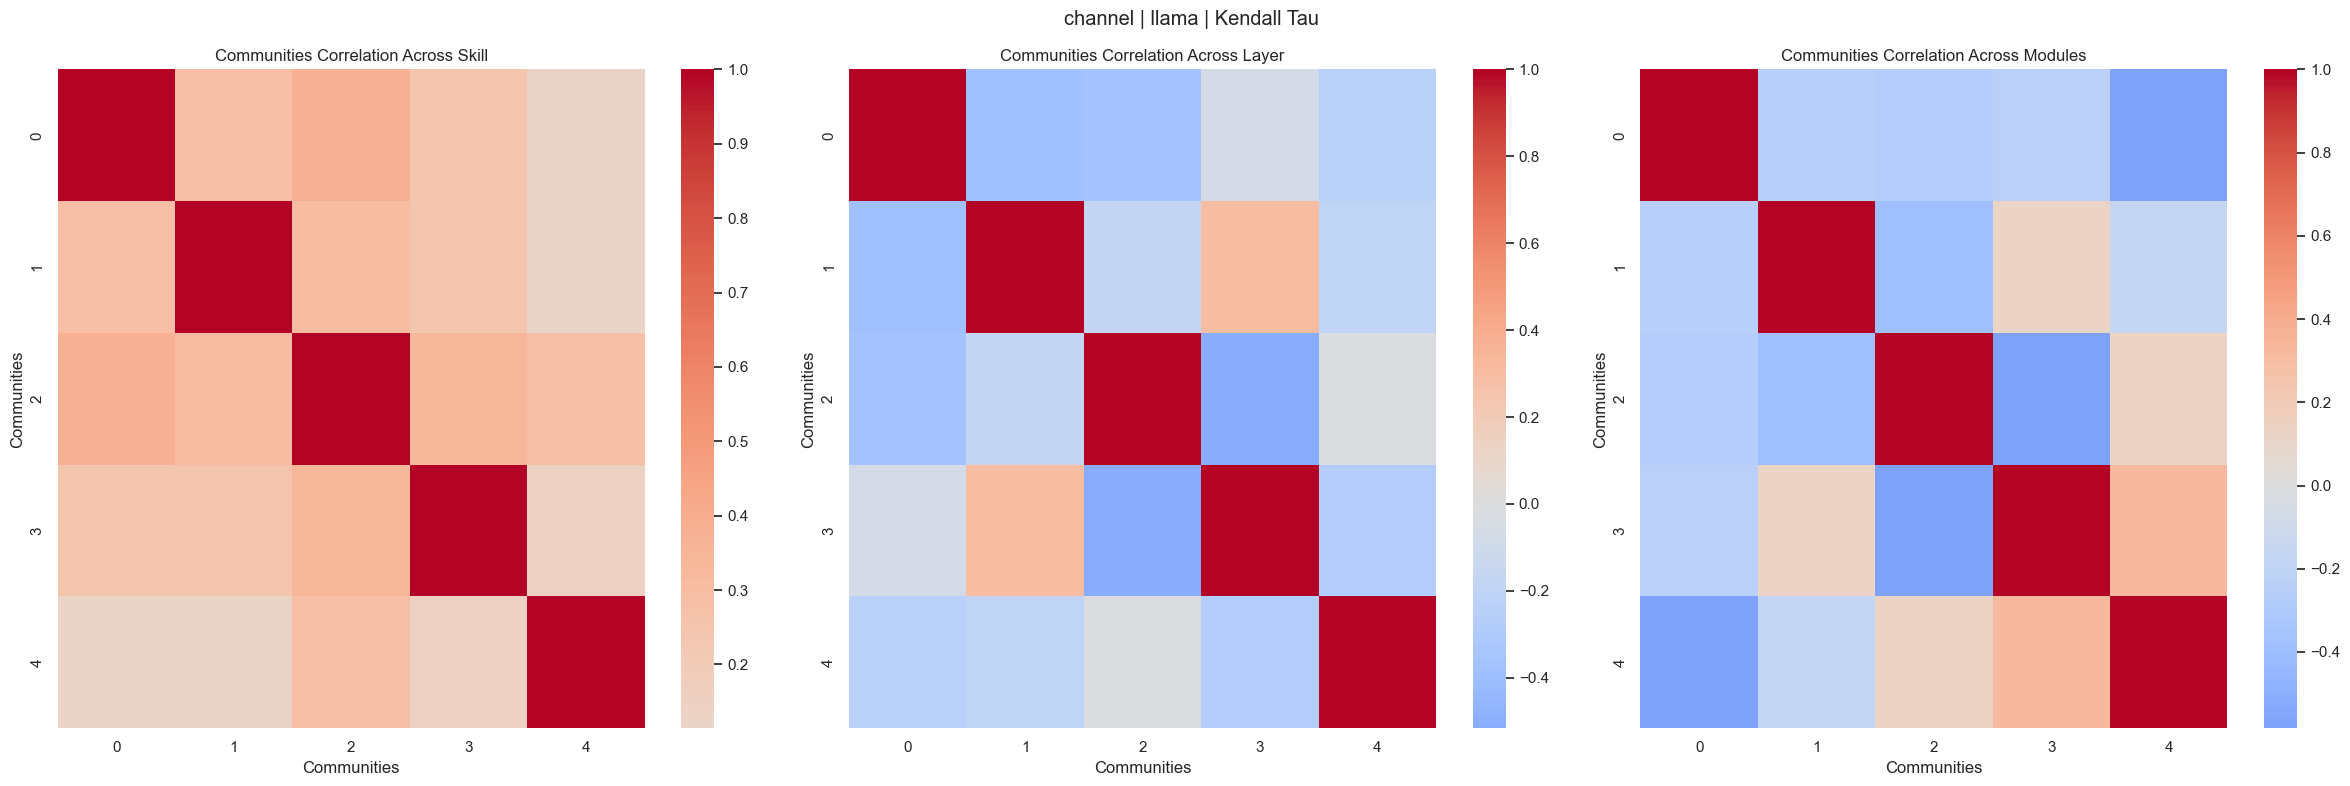

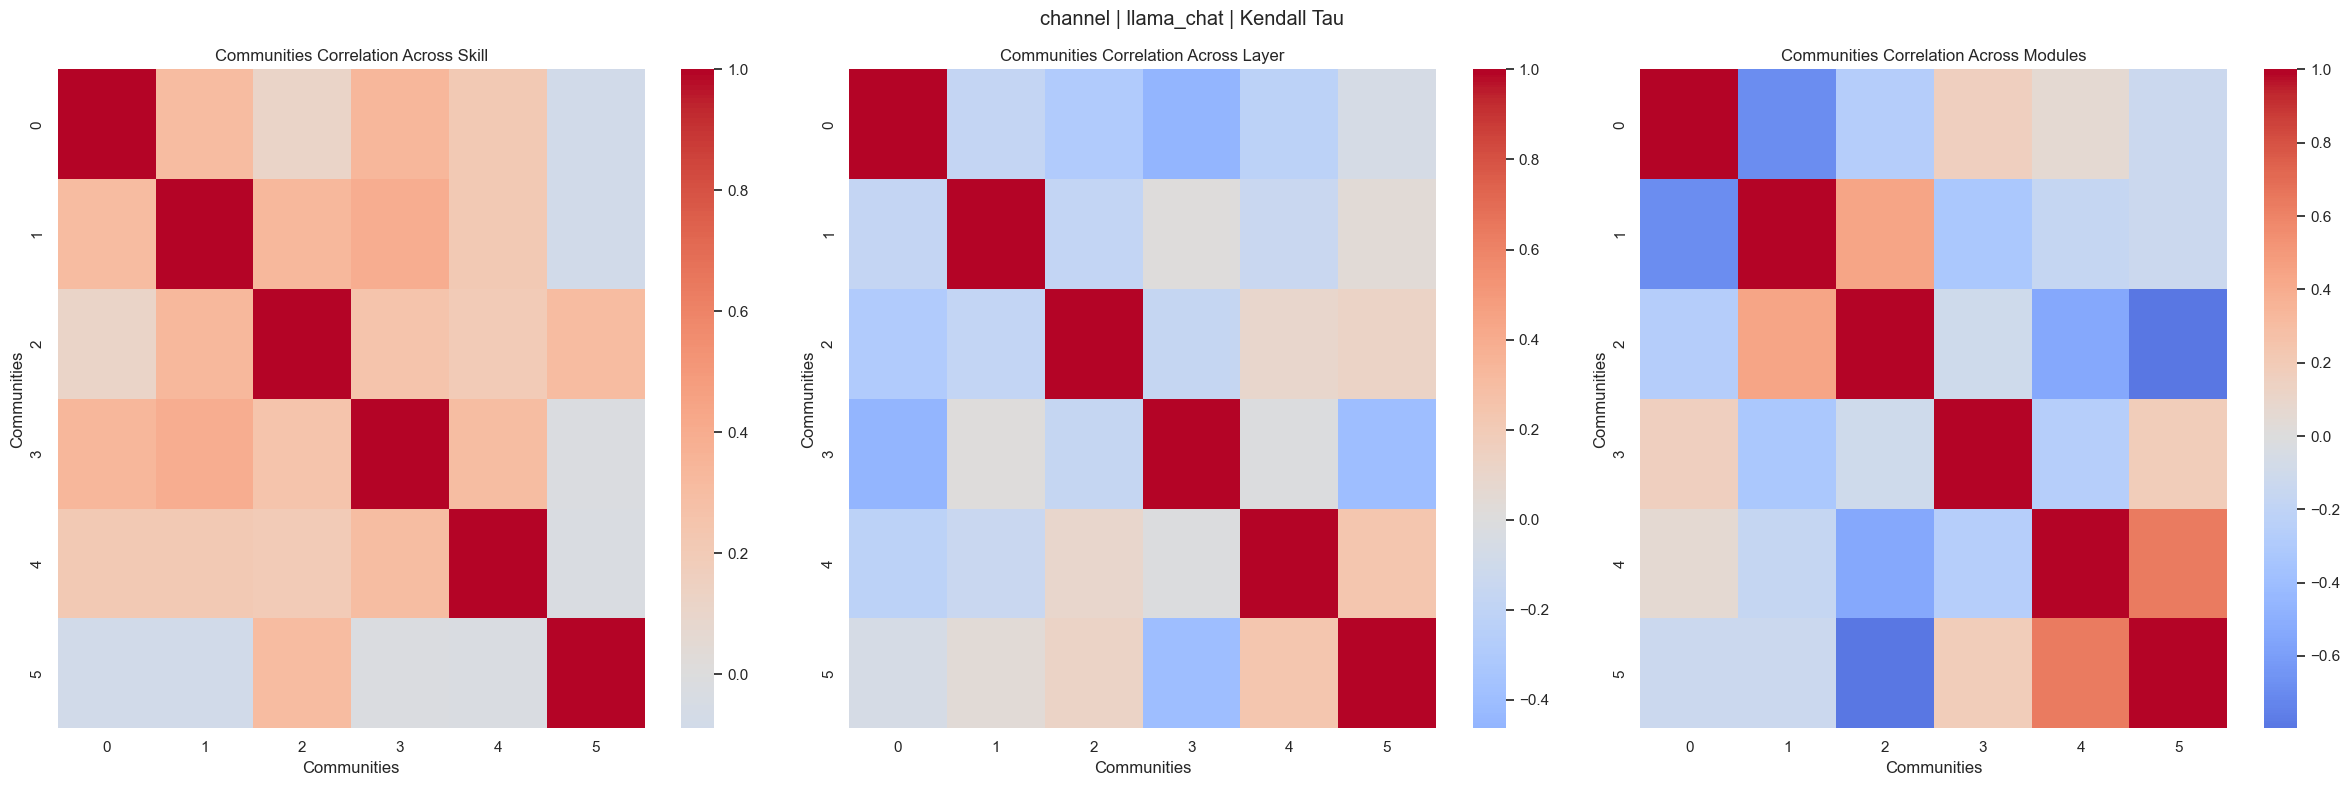

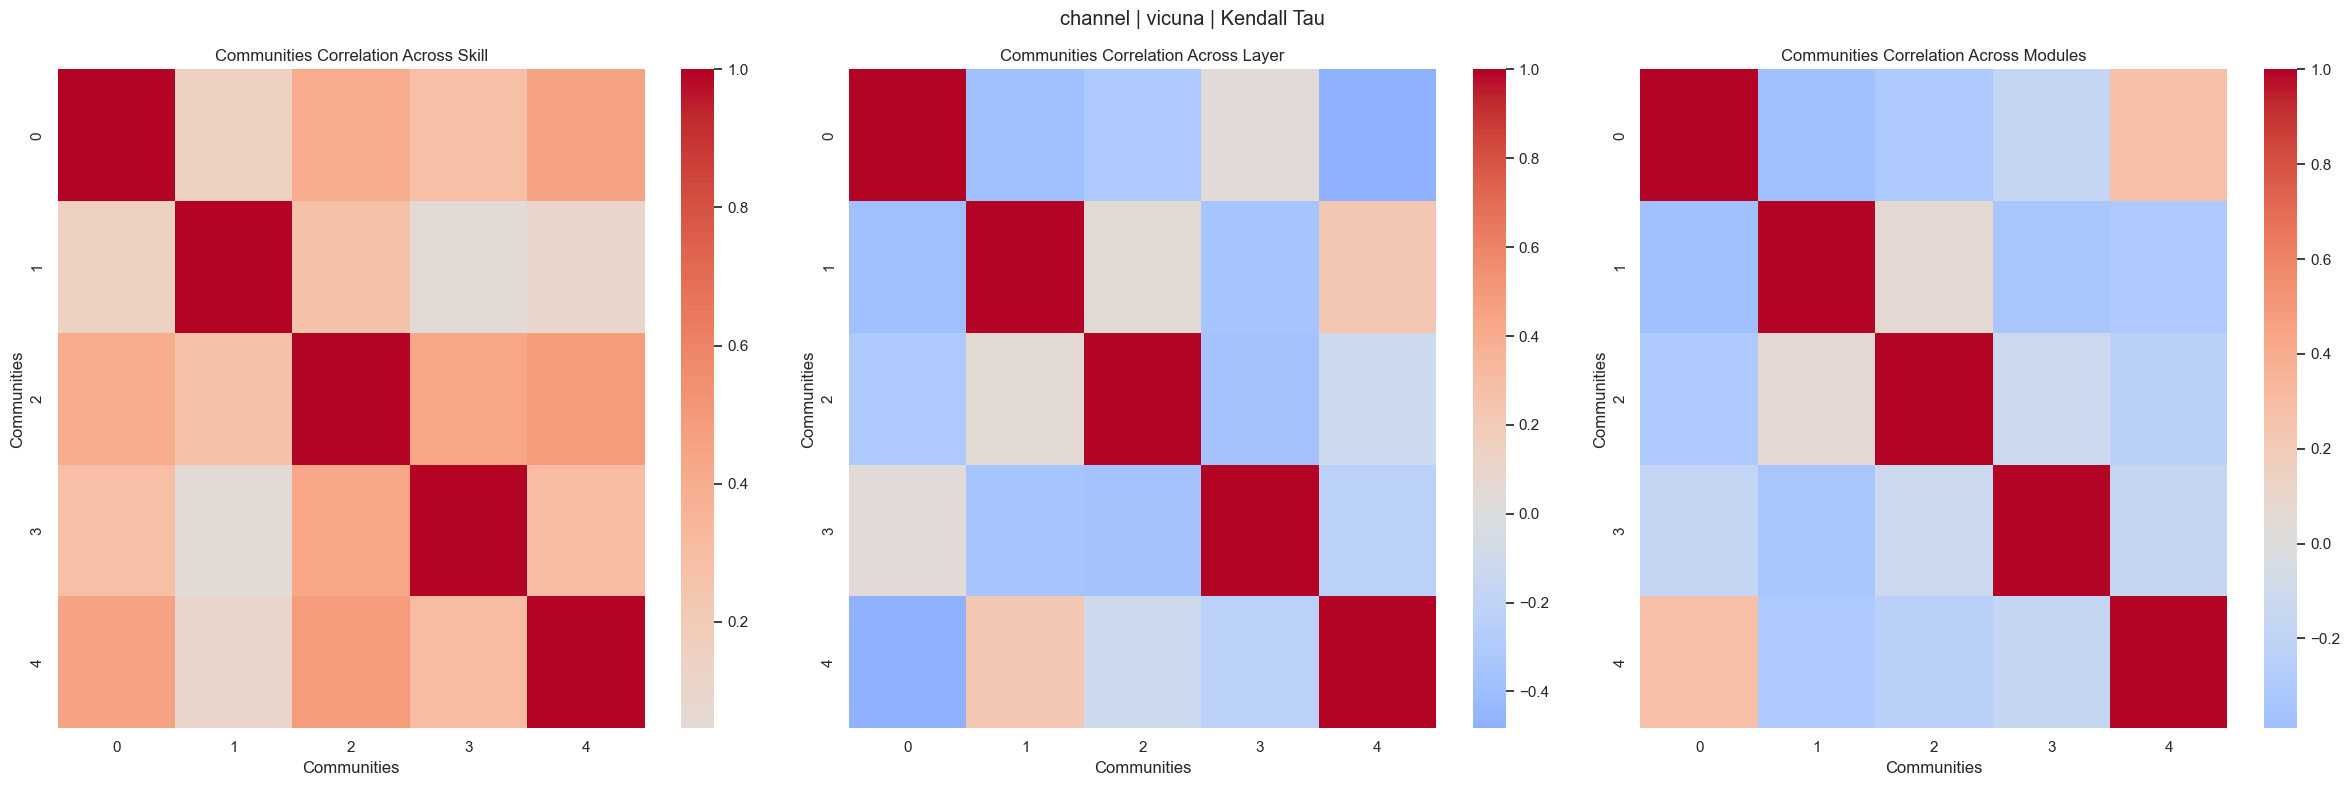

In [106]:
plt.clf()
blocks=["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
layers=[ str(i) for i in range(3,31)]
for idx, model in enumerate(modules_community_dataset["model"]):
    pruner_style = modules_community_dataset["pruner_style"][idx]
    G = modules_community_dataset["graph"][idx]
    layer_block_data = modules_community_dataset["network_property"][idx]["community"]
    skill_distribution = modules_community_dataset["frequency_skill"][idx]
    skill_distribution["skills"]=all_label_skills

    # Convert to DataFrame
    skill_df = pd.DataFrame(skill_distribution).set_index("skills")

    layer_counts = {}
    block_counts = {}

    # Count layers and blocks per community
    for comm, modules in layer_block_data.items():
        layer_counter = Counter()
        block_counter = Counter()
        
        for module in modules:
            layer, block = module.split('_', 1)
            layer_counter[layer] += 1
            block_counter[block] += 1
        
        # Ensure all possible layers and blocks are represented, filling missing ones with 0
        layer_counts[comm] = {layer: layer_counter.get(layer, 0) for layer in layers}
        block_counts[comm] = {block: block_counter.get(block, 0) for block in blocks}

    # Convert counts to DataFrames
    layer_df = pd.DataFrame(layer_counts)
    block_df = pd.DataFrame(block_counts).fillna(0)

    # Step 1: Calculate correlations of skills and layers for each community
    skill_correlation = skill_df.corr(method = "kendall")  
    layer_correlation = layer_df.corr(method = "kendall")      
    modules_correlation = block_df.corr(method = "kendall")      

    # Step 2: Visualize both correlation matrices
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Skill Correlation Heatmap
    sns.heatmap(skill_correlation, cmap="coolwarm", center=0, ax=axes[0])
    axes[0].set_title("Communities Correlation Across Skill")
    axes[0].set_xlabel("Communities")
    axes[0].set_ylabel("Communities")

    # Layer Correlation Heatmap
    sns.heatmap(layer_correlation, cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title("Communities Correlation Across Layer")
    axes[1].set_xlabel("Communities")
    axes[1].set_ylabel("Communities")
    
    sns.heatmap(modules_correlation,  cmap="coolwarm", center=0, ax=axes[2])
    axes[2].set_title("Communities Correlation Across Modules")
    axes[2].set_xlabel("Communities")
    axes[2].set_ylabel("Communities")

    fig.suptitle(f"{pruner_style} | {model} | Kendall Tau")
    plt.tight_layout()
    plt.show()

    '''# Step 4: Calculate correlation of skills with layers and skills with blocks
    layer_skill_correlation = skill_df.T.corrwith(layer_df.T, axis=1)
    block_skill_correlation = skill_df.T.corrwith(block_df.T, axis=1
                                                  )

    print(layer_skill_correlation)
    # Step 5: Visualize the two correlation matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 10))

    # Layer-Skill Correlation Heatmap
    sns.heatmap(layer_skill_correlation, annot=True, cmap="coolwarm", center=0, ax=axes[0])
    axes[0].set_title("Correlation of Skills with Layers")
    axes[0].set_xlabel("Layers")
    axes[0].set_ylabel("Skills")

    # Block-Skill Correlation Heatmap
    sns.heatmap(block_skill_correlation, annot=True, cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title("Correlation of Skills with Blocks")
    axes[1].set_xlabel("Blocks")
    axes[1].set_ylabel("Skills")

    plt.tight_layout()
    plt.show()'''

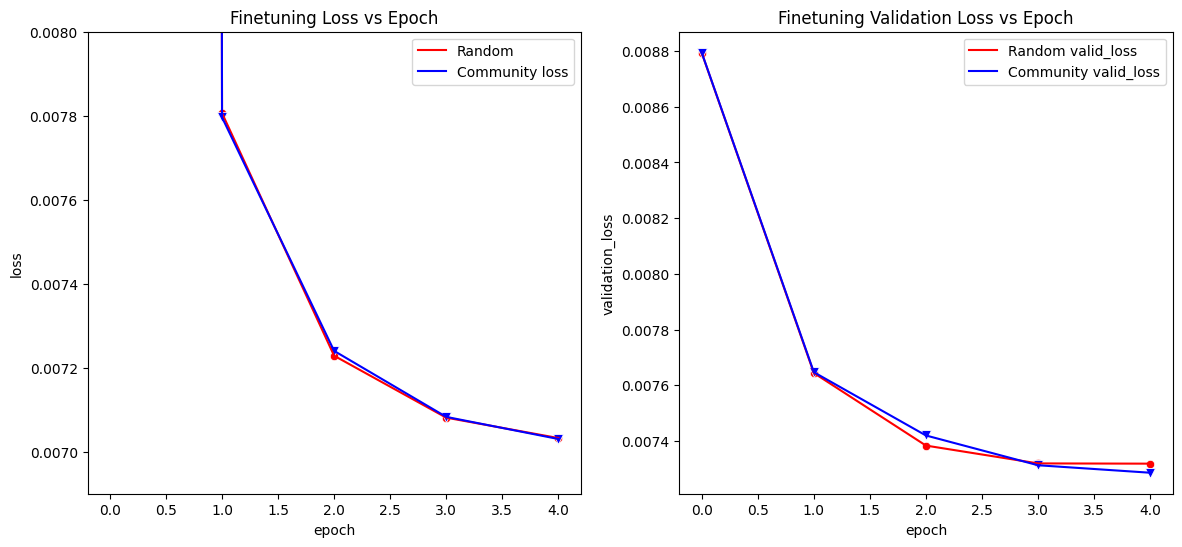

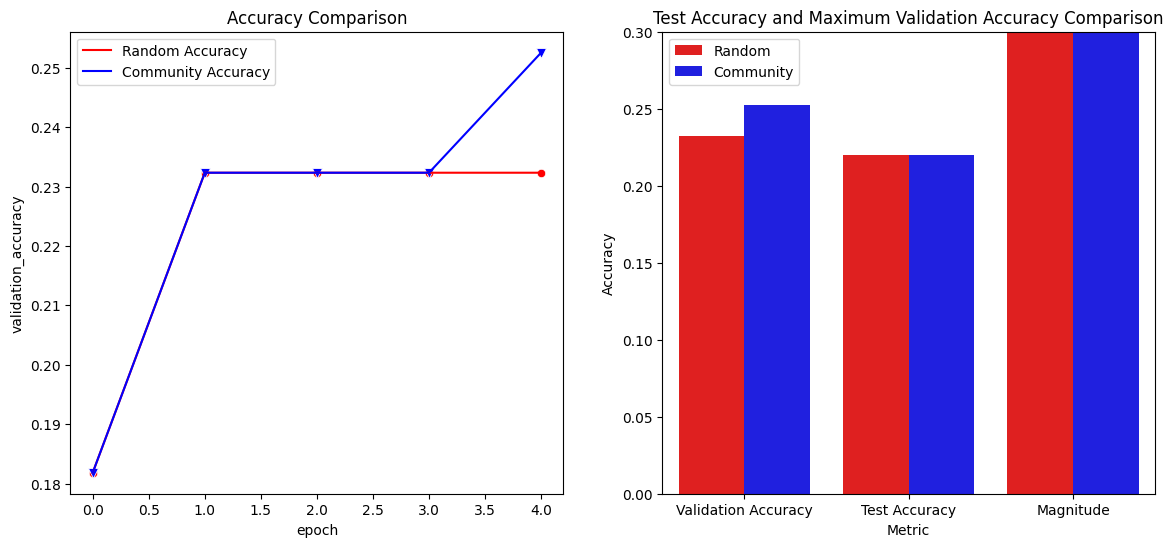

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
data = {
    "Random":{
        "epoch":[0,1,2,3,4],
        "loss" : ['0.16985096037387848', '0.007806216832250357', '0.007228560745716095', '0.007081119809299707', '0.007032547611743212'],
        "validation_loss" : ['0.008793061599135399', '0.0076442379504442215', '0.0073838564567267895', '0.007319859694689512', '0.007318983320146799'],
        "validation_accuracy" : ['0.1818181872367859', '0.23232322931289673', '0.23232322931289673', '0.23232322931289673', '0.23232322931289673'],
        "test_accuracy": 0.22,
        "magnitude":24155.91640162468
    },
    "Community": {
            "epoch":[0,1,2,3,4],
            "loss" : ['0.1691683530807495', '0.007796146906912327', '0.00724008260294795', '0.007082964759320021', '0.0070303212851285934'],
            "validation_loss" :  ['0.00879395566880703', '0.007647279649972916', '0.00742013705894351', '0.007313245441764593', '0.007286437321454287'],
            "validation_accuracy" : ['0.1818181872367859', '0.23232322931289673', '0.23232322931289673', '0.23232322931289673', '0.2525252401828766'],
            "test_accuracy":0.22,
            "magnitude":24155.917002677917
    }
}



df_Random = pd.DataFrame.from_dict(data["Random"])
df_Community = pd.DataFrame.from_dict(data["Community"])
for val in ["loss","validation_loss","validation_accuracy"]:
    df_Random[val] = df_Random[val].astype(float)
    df_Community[val] = df_Community[val].astype(float)
data_for_bar = {
    "Model": ["Random", "Random", "Random", "Community", "Community", "Community"],
    "Metric": ["Validation Accuracy", "Test Accuracy","Magnitude", "Validation Accuracy", "Test Accuracy","Magnitude"],
    "Accuracy": [df_Random["validation_accuracy"].max(), data["Random"]["test_accuracy"],data["Community"]["magnitude"], df_Community["validation_accuracy"].max(),  data["Community"]["test_accuracy"],data["Community"]["magnitude"]]
}
df_bar = pd.DataFrame(data_for_bar)
fig, [ax_loss, ax_val_loss] = plt.subplots(1, 2, figsize=(14,6))
sns.lineplot(data=df_Random, x="epoch",y="loss",color="red",label="Random", ax=ax_loss)
sns.scatterplot(data=df_Random, x="epoch",y="loss",color="red",markers='o', ax=ax_loss)
sns.lineplot(data=df_Community, x="epoch",y="loss",color="blue",label="Community loss", ax=ax_loss)
sns.scatterplot(data=df_Community, x="epoch",y="loss",color="blue",marker='v',s=50, ax=ax_loss)
ax_loss.set_ylim(0.0069, 0.008) 
ax_loss.set_title("Finetuning Loss vs Epoch")

sns.lineplot(data=df_Random, x="epoch",y="validation_loss",color="red",label="Random valid_loss", ax=ax_val_loss)
sns.scatterplot(data=df_Random, x="epoch",y="validation_loss",color="red",markers='o', ax=ax_val_loss)
sns.lineplot(data=df_Community, x="epoch",y="validation_loss",color="blue",label="Community valid_loss",ax=ax_val_loss)
sns.scatterplot(data=df_Community, x="epoch",y="validation_loss",color="blue",marker='v',s=50,ax=ax_val_loss)
#ax_val_loss.set_ylim(0.0072, 0.09)
ax_val_loss.set_title("Finetuning Validation Loss vs Epoch") 
plt.legend()
plt.show()

fig, [ax_accuracy, ax_test_accuracy] = plt.subplots(1, 2, figsize=(14,6)) 
sns.lineplot(data=df_Random, x="epoch",y="validation_accuracy",color="red",label = "Random Accuracy", ax=ax_accuracy)
sns.scatterplot(data=df_Random, x="epoch",y="validation_accuracy",color="red",markers='o', ax=ax_accuracy)
sns.lineplot(data=df_Community, x="epoch",y="validation_accuracy",color="blue",label = "Community Accuracy", ax=ax_accuracy)
sns.scatterplot(data=df_Community, x="epoch",y="validation_accuracy",color="blue",marker='v',s=50, ax=ax_accuracy)
ax_accuracy.set_title("Finetuning Validation Accuracy vs Epoch") 

sns.barplot(data=df_bar, x="Metric", y="Accuracy", hue="Model", ax=ax_test_accuracy, palette={"Random": "red", "Community": "blue"})
ax_test_accuracy.set_title("Test Accuracy and Maximum Validation Accuracy Comparison")
ax_test_accuracy.set_ylim(0.0, 0.3) 
ax_accuracy.set_title("Accuracy Comparison") 
plt.legend()
plt.show()

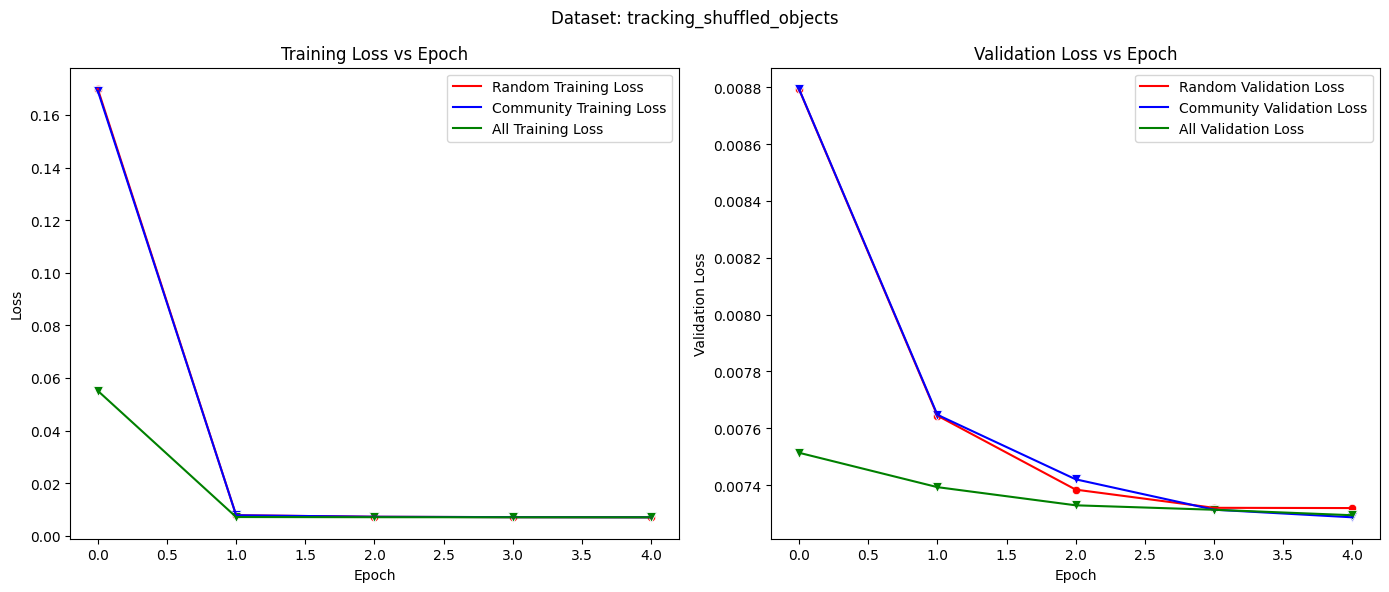

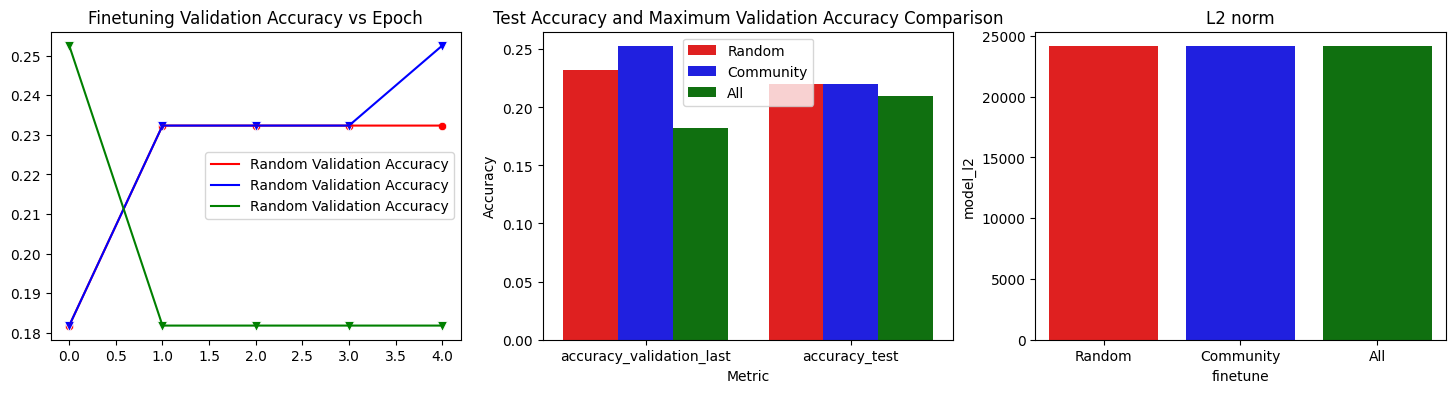

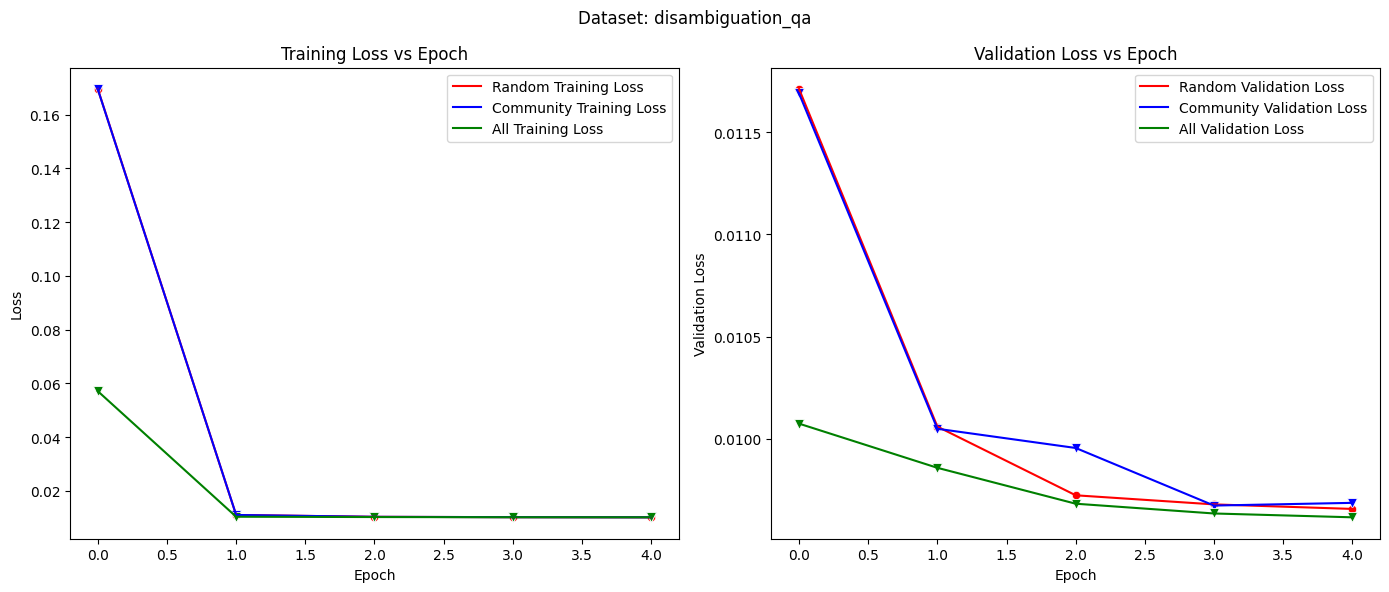

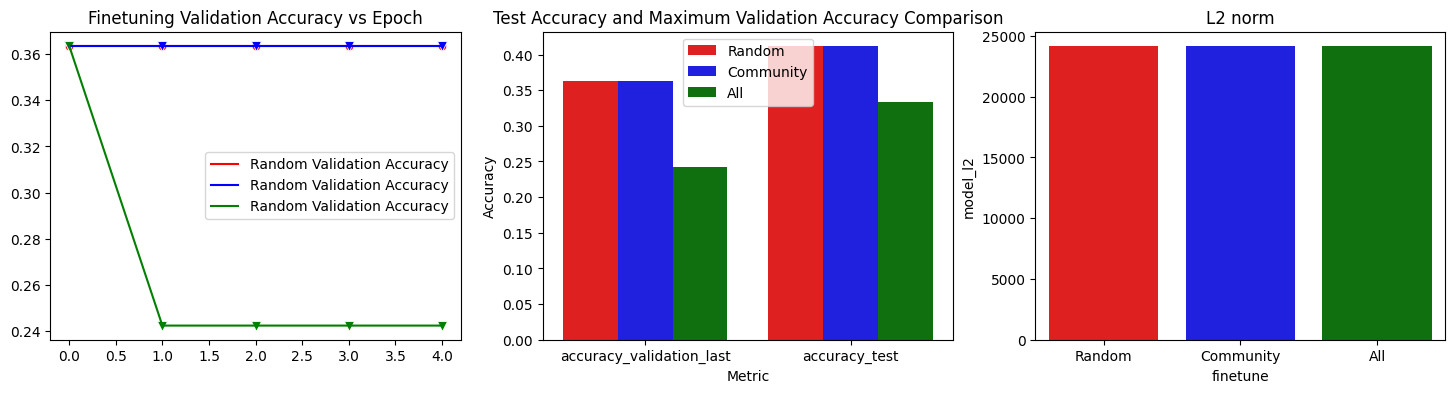

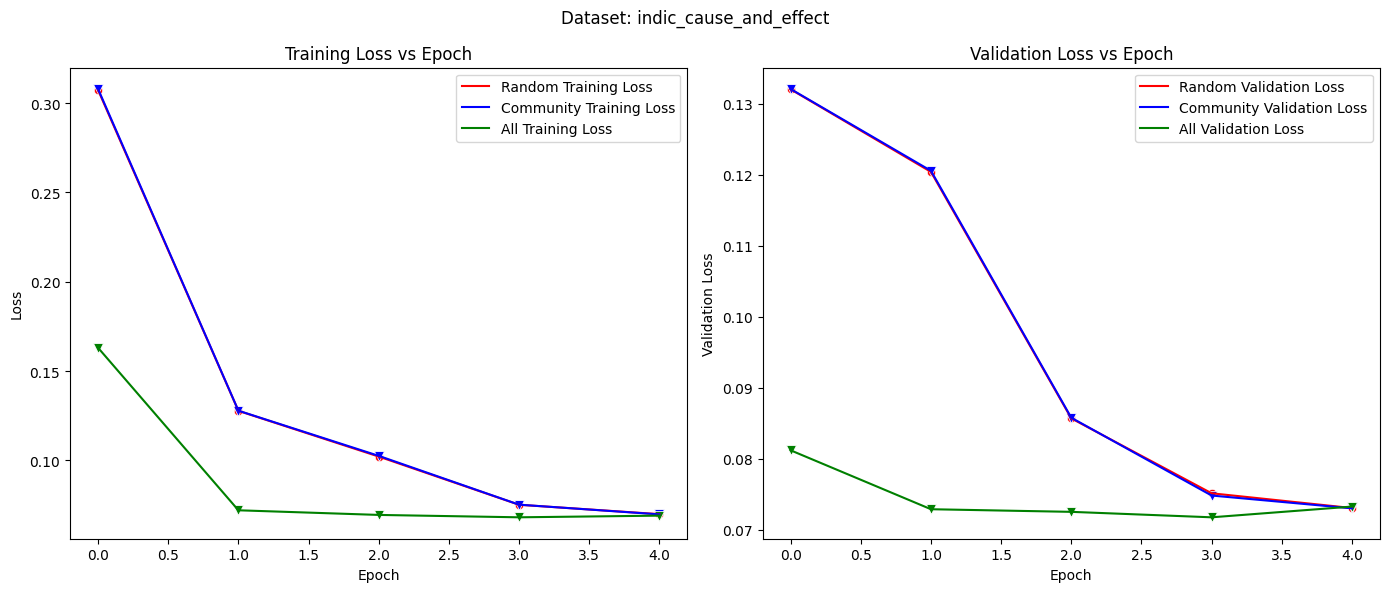

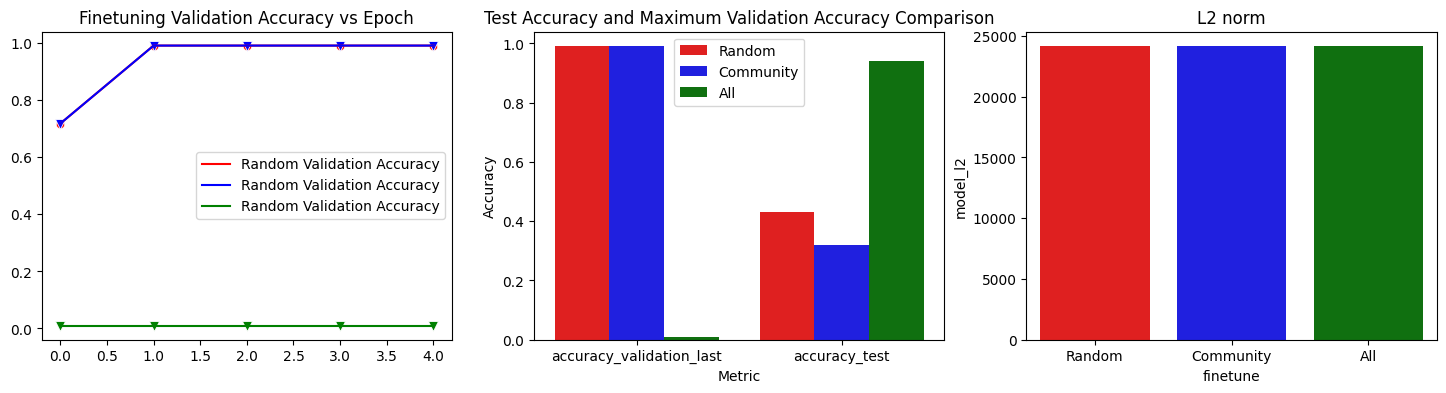

IndexError: list index out of range

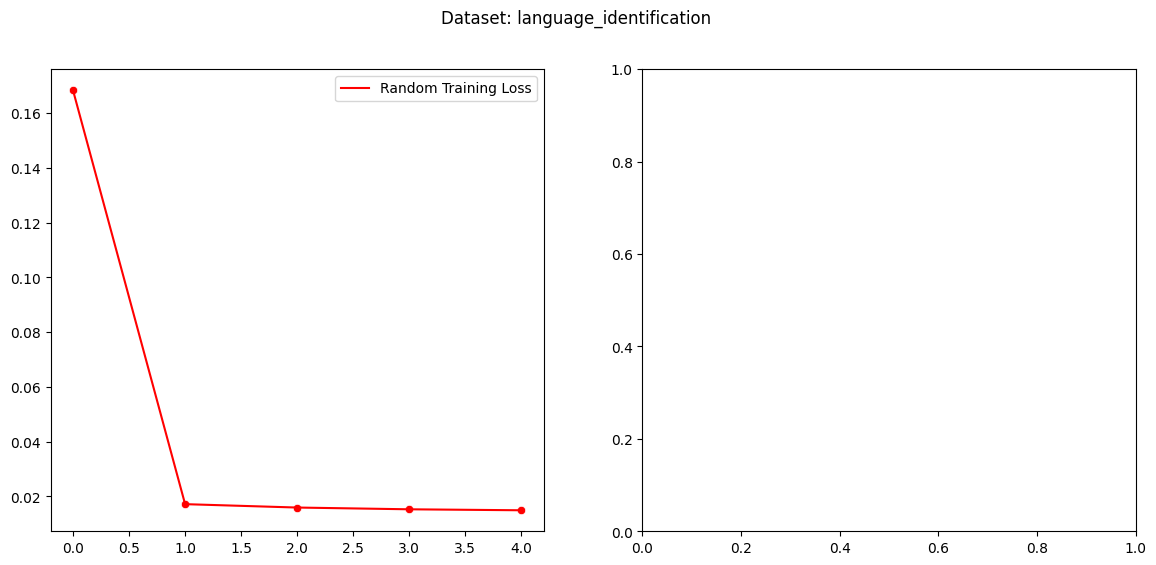

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ast import literal_eval
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

def change_list_type_df(x):
    x_list = literal_eval(x) 
    return [literal_eval(x) for x in x_list]

df = pd.read_csv("result/randomize_accuracy/randomize_data_new_kl_longer_2.csv")
df["loss_training"] = df["loss_training"].apply(change_list_type_df) 
df["loss_validation"] = df["loss_validation"].apply(change_list_type_df)  
df["model_l2_0"] = df["model_l2_0"].apply(change_list_type_df)  
df["accuracy_validation"] = df["accuracy_validation"].apply(change_list_type_df)  
# Ensure epochs are present for proper plotting
df["epoch"] = range(1, len(df) + 1)  # Modify this if epochs are explicitly defined in your data
# Get unique communities
unique_dataset = df['dataset'].unique()

# Iterate through each community and plot
for dataset in unique_dataset:
    # Filter data for the current community
    df_community = df[df['dataset'] == dataset]
    df_Random = df_community[df_community['finetune'] == "Random"]
    df_Community = df_community[df_community['finetune'] == "Community"]
    df_All = df_community[df_community['finetune'] == "All"]


    # Create a new figure for the community
    fig, [ax_loss, ax_val_loss] = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Dataset: {dataset}")

    # Plot training loss
    sns.lineplot(data=df_Random["loss_training"].tolist()[0], color="red", label="Random Training Loss", ax=ax_loss)
    sns.scatterplot(data=df_Random["loss_training"].tolist()[0], color="red", marker='o', ax=ax_loss)
    sns.lineplot(data=df_Community["loss_training"].tolist()[0], color="blue", label="Community Training Loss", ax=ax_loss)
    sns.scatterplot(data=df_Community["loss_training"].tolist()[0], color="blue", marker='v', s=50, ax=ax_loss)
    sns.lineplot(data=df_All["loss_training"].tolist()[0], color="green", label="All Training Loss", ax=ax_loss)
    sns.scatterplot(data=df_All["loss_training"].tolist()[0], color="green", marker='v', s=50, ax=ax_loss)
    ax_loss.set_title("Training Loss vs Epoch")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    # Plot validation loss
    sns.lineplot(data=df_Random["loss_validation"].tolist()[0], color="red", label="Random Validation Loss", ax=ax_val_loss)
    sns.scatterplot(data=df_Random["loss_validation"].tolist()[0], color="red", marker='o', ax=ax_val_loss)
    sns.lineplot(data=df_Community["loss_validation"].tolist()[0], color="blue", label="Community Validation Loss", ax=ax_val_loss)
    sns.scatterplot(data=df_Community["loss_validation"].tolist()[0], color="blue", marker='v', s=50, ax=ax_val_loss)
    sns.lineplot(data=df_All["loss_validation"].tolist()[0], color="green", label="All Validation Loss", ax=ax_val_loss)
    sns.scatterplot(data=df_All["loss_validation"].tolist()[0], color="green", marker='v', s=50, ax=ax_val_loss)
    ax_val_loss.set_title("Validation Loss vs Epoch")
    ax_val_loss.set_xlabel("Epoch")
    ax_val_loss.set_ylabel("Validation Loss")

    # Show legends and plot
    ax_loss.legend()
    ax_val_loss.legend()
    plt.tight_layout()
    plt.show()
    
    
    columns_to_transform = ["accuracy_validation_last", "accuracy_test"]
    df_community["accuracy_validation_last"]= df_community["accuracy_validation"].apply(lambda x: x[-1])
    df_melted = df_community.melt(
        id_vars=["finetune"],  # Retain other columns
        value_vars=columns_to_transform,  # Columns to transform
        var_name='Metric', 
        value_name='Accuracy'

    )
    fig, [ax_accuracy, ax_test_accuracy, ax_magnitude] = plt.subplots(1, 3, figsize=(18,4))
    
    sns.lineplot(data=df_Random["accuracy_validation"].tolist()[0], color="red", label="Random Validation Accuracy", ax=ax_accuracy)
    sns.scatterplot(data=df_Random["accuracy_validation"].tolist()[0], color="red", marker='o', ax=ax_accuracy)
    sns.lineplot(data=df_Community["accuracy_validation"].tolist()[0], color="blue", label="Random Validation Accuracy", ax=ax_accuracy)
    sns.scatterplot(data=df_Community["accuracy_validation"].tolist()[0], color="blue", marker='v', s=50, ax=ax_accuracy)
    sns.lineplot(data=df_All["accuracy_validation"].tolist()[0], color="green", label="Random Validation Accuracy", ax=ax_accuracy)
    sns.scatterplot(data=df_All["accuracy_validation"].tolist()[0], color="green", marker='v', s=50, ax=ax_accuracy)
    ax_accuracy.set_title("Finetuning Validation Accuracy vs Epoch") 

    sns.barplot(data=df_melted, x="Metric", y="Accuracy", hue="finetune", ax=ax_test_accuracy, palette={"Random": "red", "Community": "blue","All":"green"})
    ax_test_accuracy.set_title("Test Accuracy and Maximum Validation Accuracy Comparison")
    #ax_test_accuracy.set_ylim(0.0, 0.3) 


    sns.barplot(data=df_community, x="finetune", y="model_l2", ax=ax_magnitude, palette={"Random": "red", "Community": "blue","All":"green"})
    ax_magnitude.set_title("L2 norm")
    

    ax_accuracy.legend()
    ax_test_accuracy.legend() 
    plt.show()